# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


Here I'll create a model like normal, using the same one from my solution for part 4.

In [3]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [4]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [5]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [6]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implement for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [7]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 1.5625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [8]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    test_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad() :
            hit_count = 0
            valid_size = 0
            for test_images, test_labels in testloader :
                ps = torch.exp(model(test_images))
                tloss = criterion(model(test_images), test_labels)
                pred = ps.topk(1, dim=1)[1]
                hit_count += torch.sum((test_labels.view(*pred.shape) == pred).type(torch.FloatTensor))
                valid_size += len(test_labels)
                
                test_loss += tloss.item()
            accuracy = hit_count/valid_size
        print(f'Accuracy: {accuracy.item()*100}%')
        
    train_losses.append(running_loss)
    test_losses.append(test_loss)

Accuracy: 83.91000032424927%
Accuracy: 85.89000105857849%
Accuracy: 86.54000163078308%
Accuracy: 86.40000224113464%
Accuracy: 86.21000051498413%
Accuracy: 87.66999840736389%
Accuracy: 85.98999977111816%
Accuracy: 86.91999912261963%
Accuracy: 86.80999875068665%
Accuracy: 87.79000043869019%
Accuracy: 87.00000047683716%
Accuracy: 88.02000284194946%
Accuracy: 88.13999891281128%
Accuracy: 86.61999702453613%
Accuracy: 87.92999982833862%
Accuracy: 88.17999958992004%
Accuracy: 87.90000081062317%
Accuracy: 88.71999979019165%
Accuracy: 87.77999877929688%
Accuracy: 88.27000260353088%
Accuracy: 88.58000040054321%
Accuracy: 88.10999989509583%
Accuracy: 87.91999816894531%
Accuracy: 87.65000104904175%
Accuracy: 87.9800021648407%
Accuracy: 88.30000162124634%
Accuracy: 88.02000284194946%
Accuracy: 88.5200023651123%
Accuracy: 88.7000024318695%
Accuracy: 87.62999773025513%


## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [24]:
## TODO: Define your model with dropout added
import torch.nn as nn
model = nn.Sequential(nn.Linear(784, 256),
                     nn.ReLU(),
                     nn.Dropout(0.2),
                     nn.Linear(256, 128),
                     nn.ReLU(),
                     nn.Dropout(0.2),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Dropout(0.2),
                     nn.Linear(64, 10),
                     nn.LogSoftmax(dim=1))

In [30]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

model.train()
epoch = 10
train_losses, test_losses = [], []
acc = 0
for e in range(epochs):
    
    running_loss = 0
    
    for images, labels in trainloader:
        
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        logit = model(images)
        loss = criterion(logit, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        acc = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader : 
                images = images.view(images.shape[0], -1)
                
                logit = model(images)
                test_loss += criterion(logit, labels)
                
                pred = torch.exp(logit)
                _, max_lab = pred.topk(1, dim=1)
                hit = (max_lab == labels.view(*max_lab.shape))
                acc += torch.mean(hit.type(torch.FloatTensor))
                
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))        
            
        print(f'Epoch: {e}')    
        print(f'Train loss: {running_loss/len(trainloader)}')
        print(f'Test loss: {test_loss/len(testloader)}')
        print(f'Acc: {acc/len(testloader)}')
        

tensor(0.2352, grad_fn=<NllLossBackward>)
tensor(0.2710, grad_fn=<NllLossBackward>)
tensor(0.2102, grad_fn=<NllLossBackward>)
tensor(0.2563, grad_fn=<NllLossBackward>)
tensor(0.3994, grad_fn=<NllLossBackward>)
tensor(0.4004, grad_fn=<NllLossBackward>)
tensor(0.3512, grad_fn=<NllLossBackward>)
tensor(0.4461, grad_fn=<NllLossBackward>)
tensor(0.4757, grad_fn=<NllLossBackward>)
tensor(0.6253, grad_fn=<NllLossBackward>)
tensor(0.6118, grad_fn=<NllLossBackward>)
tensor(0.3429, grad_fn=<NllLossBackward>)
tensor(0.7151, grad_fn=<NllLossBackward>)
tensor(0.3025, grad_fn=<NllLossBackward>)
tensor(0.2254, grad_fn=<NllLossBackward>)
tensor(0.2450, grad_fn=<NllLossBackward>)
tensor(0.4865, grad_fn=<NllLossBackward>)
tensor(0.4853, grad_fn=<NllLossBackward>)
tensor(0.2733, grad_fn=<NllLossBackward>)
tensor(0.3406, grad_fn=<NllLossBackward>)
tensor(0.2813, grad_fn=<NllLossBackward>)
tensor(0.2559, grad_fn=<NllLossBackward>)
tensor(0.9214, grad_fn=<NllLossBackward>)
tensor(0.4945, grad_fn=<NllLossBac

tensor(0.3670, grad_fn=<NllLossBackward>)
tensor(0.2389, grad_fn=<NllLossBackward>)
tensor(0.4664, grad_fn=<NllLossBackward>)
tensor(0.4145, grad_fn=<NllLossBackward>)
tensor(0.4957, grad_fn=<NllLossBackward>)
tensor(0.3230, grad_fn=<NllLossBackward>)
tensor(0.3618, grad_fn=<NllLossBackward>)
tensor(0.4217, grad_fn=<NllLossBackward>)
tensor(0.1789, grad_fn=<NllLossBackward>)
tensor(0.6300, grad_fn=<NllLossBackward>)
tensor(0.5619, grad_fn=<NllLossBackward>)
tensor(0.2747, grad_fn=<NllLossBackward>)
tensor(0.4329, grad_fn=<NllLossBackward>)
tensor(0.2356, grad_fn=<NllLossBackward>)
tensor(0.3679, grad_fn=<NllLossBackward>)
tensor(0.3373, grad_fn=<NllLossBackward>)
tensor(0.4551, grad_fn=<NllLossBackward>)
tensor(0.7714, grad_fn=<NllLossBackward>)
tensor(0.3283, grad_fn=<NllLossBackward>)
tensor(0.4089, grad_fn=<NllLossBackward>)
tensor(0.3463, grad_fn=<NllLossBackward>)
tensor(0.4976, grad_fn=<NllLossBackward>)
tensor(0.3419, grad_fn=<NllLossBackward>)
tensor(0.4341, grad_fn=<NllLossBac

tensor(0.1292, grad_fn=<NllLossBackward>)
tensor(0.4106, grad_fn=<NllLossBackward>)
tensor(0.5544, grad_fn=<NllLossBackward>)
tensor(0.2146, grad_fn=<NllLossBackward>)
tensor(0.2763, grad_fn=<NllLossBackward>)
tensor(0.3215, grad_fn=<NllLossBackward>)
tensor(0.3616, grad_fn=<NllLossBackward>)
tensor(0.4557, grad_fn=<NllLossBackward>)
tensor(0.5256, grad_fn=<NllLossBackward>)
tensor(0.2933, grad_fn=<NllLossBackward>)
tensor(0.4870, grad_fn=<NllLossBackward>)
tensor(0.2781, grad_fn=<NllLossBackward>)
tensor(0.4182, grad_fn=<NllLossBackward>)
tensor(0.3131, grad_fn=<NllLossBackward>)
tensor(0.4003, grad_fn=<NllLossBackward>)
tensor(0.4541, grad_fn=<NllLossBackward>)
tensor(0.5150, grad_fn=<NllLossBackward>)
tensor(0.3660, grad_fn=<NllLossBackward>)
tensor(0.2963, grad_fn=<NllLossBackward>)
tensor(0.4279, grad_fn=<NllLossBackward>)
tensor(0.4561, grad_fn=<NllLossBackward>)
tensor(0.2504, grad_fn=<NllLossBackward>)
tensor(0.2350, grad_fn=<NllLossBackward>)
tensor(0.3416, grad_fn=<NllLossBac

tensor(0.2445, grad_fn=<NllLossBackward>)
tensor(0.2524, grad_fn=<NllLossBackward>)
tensor(0.3669, grad_fn=<NllLossBackward>)
tensor(0.2817, grad_fn=<NllLossBackward>)
tensor(0.4388, grad_fn=<NllLossBackward>)
tensor(0.5421, grad_fn=<NllLossBackward>)
tensor(0.3097, grad_fn=<NllLossBackward>)
tensor(0.3258, grad_fn=<NllLossBackward>)
tensor(0.3080, grad_fn=<NllLossBackward>)
tensor(0.1609, grad_fn=<NllLossBackward>)
tensor(0.2307, grad_fn=<NllLossBackward>)
tensor(0.5189, grad_fn=<NllLossBackward>)
tensor(0.2733, grad_fn=<NllLossBackward>)
tensor(0.3378, grad_fn=<NllLossBackward>)
tensor(0.2820, grad_fn=<NllLossBackward>)
tensor(0.2708, grad_fn=<NllLossBackward>)
tensor(0.3970, grad_fn=<NllLossBackward>)
tensor(0.2349, grad_fn=<NllLossBackward>)
tensor(0.2247, grad_fn=<NllLossBackward>)
tensor(0.3486, grad_fn=<NllLossBackward>)
tensor(0.1964, grad_fn=<NllLossBackward>)
tensor(0.3302, grad_fn=<NllLossBackward>)
tensor(0.2492, grad_fn=<NllLossBackward>)
tensor(0.3985, grad_fn=<NllLossBac

tensor(0.3242, grad_fn=<NllLossBackward>)
tensor(0.4807, grad_fn=<NllLossBackward>)
tensor(0.3737, grad_fn=<NllLossBackward>)
tensor(0.2348, grad_fn=<NllLossBackward>)
tensor(0.1627, grad_fn=<NllLossBackward>)
tensor(0.2891, grad_fn=<NllLossBackward>)
tensor(0.6027, grad_fn=<NllLossBackward>)
tensor(0.2701, grad_fn=<NllLossBackward>)
tensor(0.3504, grad_fn=<NllLossBackward>)
tensor(0.2194, grad_fn=<NllLossBackward>)
tensor(0.3263, grad_fn=<NllLossBackward>)
tensor(0.3973, grad_fn=<NllLossBackward>)
tensor(0.3922, grad_fn=<NllLossBackward>)
tensor(0.4282, grad_fn=<NllLossBackward>)
tensor(0.4384, grad_fn=<NllLossBackward>)
tensor(0.2138, grad_fn=<NllLossBackward>)
tensor(0.2929, grad_fn=<NllLossBackward>)
tensor(0.2036, grad_fn=<NllLossBackward>)
tensor(0.3049, grad_fn=<NllLossBackward>)
tensor(0.2488, grad_fn=<NllLossBackward>)
tensor(0.4700, grad_fn=<NllLossBackward>)
tensor(0.2371, grad_fn=<NllLossBackward>)
tensor(0.2553, grad_fn=<NllLossBackward>)
tensor(0.2438, grad_fn=<NllLossBac

tensor(0.2871, grad_fn=<NllLossBackward>)
tensor(0.2487, grad_fn=<NllLossBackward>)
tensor(0.1931, grad_fn=<NllLossBackward>)
tensor(0.3645, grad_fn=<NllLossBackward>)
tensor(0.2269, grad_fn=<NllLossBackward>)
tensor(0.4604, grad_fn=<NllLossBackward>)
tensor(0.1684, grad_fn=<NllLossBackward>)
tensor(0.3813, grad_fn=<NllLossBackward>)
tensor(0.2013, grad_fn=<NllLossBackward>)
tensor(0.2580, grad_fn=<NllLossBackward>)
tensor(0.4180, grad_fn=<NllLossBackward>)
tensor(0.3871, grad_fn=<NllLossBackward>)
tensor(0.5360, grad_fn=<NllLossBackward>)
tensor(0.2304, grad_fn=<NllLossBackward>)
tensor(0.3860, grad_fn=<NllLossBackward>)
tensor(0.2364, grad_fn=<NllLossBackward>)
tensor(0.3785, grad_fn=<NllLossBackward>)
tensor(0.5904, grad_fn=<NllLossBackward>)
tensor(0.2749, grad_fn=<NllLossBackward>)
tensor(0.2592, grad_fn=<NllLossBackward>)
tensor(0.3359, grad_fn=<NllLossBackward>)
tensor(0.4032, grad_fn=<NllLossBackward>)
tensor(0.4310, grad_fn=<NllLossBackward>)
tensor(0.4321, grad_fn=<NllLossBac

tensor(0.3623, grad_fn=<NllLossBackward>)
tensor(0.2190, grad_fn=<NllLossBackward>)
tensor(0.2764, grad_fn=<NllLossBackward>)
tensor(0.4990, grad_fn=<NllLossBackward>)
tensor(0.5247, grad_fn=<NllLossBackward>)
tensor(0.3296, grad_fn=<NllLossBackward>)
tensor(0.4326, grad_fn=<NllLossBackward>)
tensor(0.2109, grad_fn=<NllLossBackward>)
tensor(0.4343, grad_fn=<NllLossBackward>)
tensor(0.4946, grad_fn=<NllLossBackward>)
tensor(0.3315, grad_fn=<NllLossBackward>)
tensor(0.3072, grad_fn=<NllLossBackward>)
tensor(0.3433, grad_fn=<NllLossBackward>)
tensor(0.3243, grad_fn=<NllLossBackward>)
tensor(0.3496, grad_fn=<NllLossBackward>)
tensor(0.2699, grad_fn=<NllLossBackward>)
tensor(0.4283, grad_fn=<NllLossBackward>)
tensor(0.1850, grad_fn=<NllLossBackward>)
tensor(0.4814, grad_fn=<NllLossBackward>)
tensor(0.2958, grad_fn=<NllLossBackward>)
tensor(0.3795, grad_fn=<NllLossBackward>)
tensor(0.4741, grad_fn=<NllLossBackward>)
tensor(0.4046, grad_fn=<NllLossBackward>)
tensor(0.4490, grad_fn=<NllLossBac

tensor(0.2946, grad_fn=<NllLossBackward>)
tensor(0.3826, grad_fn=<NllLossBackward>)
tensor(0.4804, grad_fn=<NllLossBackward>)
tensor(0.3376, grad_fn=<NllLossBackward>)
tensor(0.3995, grad_fn=<NllLossBackward>)
tensor(0.2877, grad_fn=<NllLossBackward>)
tensor(0.2945, grad_fn=<NllLossBackward>)
tensor(0.4162, grad_fn=<NllLossBackward>)
tensor(0.6634, grad_fn=<NllLossBackward>)
tensor(0.4232, grad_fn=<NllLossBackward>)
tensor(0.2947, grad_fn=<NllLossBackward>)
tensor(0.4731, grad_fn=<NllLossBackward>)
tensor(0.3693, grad_fn=<NllLossBackward>)
tensor(0.3555, grad_fn=<NllLossBackward>)
tensor(0.2909, grad_fn=<NllLossBackward>)
tensor(0.2970, grad_fn=<NllLossBackward>)
tensor(0.2136, grad_fn=<NllLossBackward>)
tensor(0.2962, grad_fn=<NllLossBackward>)
tensor(0.3598, grad_fn=<NllLossBackward>)
tensor(0.2677, grad_fn=<NllLossBackward>)
tensor(0.3076, grad_fn=<NllLossBackward>)
tensor(0.3292, grad_fn=<NllLossBackward>)
tensor(0.3869, grad_fn=<NllLossBackward>)
tensor(0.5491, grad_fn=<NllLossBac

tensor(0.3234, grad_fn=<NllLossBackward>)
tensor(0.3374, grad_fn=<NllLossBackward>)
tensor(0.2976, grad_fn=<NllLossBackward>)
tensor(0.2584, grad_fn=<NllLossBackward>)
tensor(0.3074, grad_fn=<NllLossBackward>)
tensor(0.2455, grad_fn=<NllLossBackward>)
tensor(0.4004, grad_fn=<NllLossBackward>)
tensor(0.5947, grad_fn=<NllLossBackward>)
tensor(0.5623, grad_fn=<NllLossBackward>)
tensor(0.3930, grad_fn=<NllLossBackward>)
tensor(0.3167, grad_fn=<NllLossBackward>)
tensor(0.2558, grad_fn=<NllLossBackward>)
tensor(0.3489, grad_fn=<NllLossBackward>)
tensor(0.1882, grad_fn=<NllLossBackward>)
tensor(0.4417, grad_fn=<NllLossBackward>)
tensor(0.2657, grad_fn=<NllLossBackward>)
tensor(0.3128, grad_fn=<NllLossBackward>)
tensor(0.3258, grad_fn=<NllLossBackward>)
tensor(0.4342, grad_fn=<NllLossBackward>)
tensor(0.2143, grad_fn=<NllLossBackward>)
tensor(0.3602, grad_fn=<NllLossBackward>)
tensor(0.2539, grad_fn=<NllLossBackward>)
tensor(0.6577, grad_fn=<NllLossBackward>)
tensor(0.3419, grad_fn=<NllLossBac

tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.3803, grad_fn=<NllLossBackward>)
tensor(0.3445, grad_fn=<NllLossBackward>)
tensor(0.2195, grad_fn=<NllLossBackward>)
tensor(0.3597, grad_fn=<NllLossBackward>)
tensor(0.2787, grad_fn=<NllLossBackward>)
tensor(0.2275, grad_fn=<NllLossBackward>)
tensor(0.2622, grad_fn=<NllLossBackward>)
tensor(0.4575, grad_fn=<NllLossBackward>)
tensor(0.2374, grad_fn=<NllLossBackward>)
tensor(0.3221, grad_fn=<NllLossBackward>)
tensor(0.3443, grad_fn=<NllLossBackward>)
tensor(0.4314, grad_fn=<NllLossBackward>)
tensor(0.2985, grad_fn=<NllLossBackward>)
tensor(0.3412, grad_fn=<NllLossBackward>)
tensor(0.2916, grad_fn=<NllLossBackward>)
tensor(0.2775, grad_fn=<NllLossBackward>)
tensor(0.4950, grad_fn=<NllLossBackward>)
tensor(0.7677, grad_fn=<NllLossBackward>)
tensor(0.1480, grad_fn=<NllLossBackward>)
tensor(0.3446, grad_fn=<NllLossBackward>)
tensor(0.1256, grad_fn=<NllLossBackward>)
tensor(0.3947, grad_fn=<NllLossBackward>)
tensor(0.2939, grad_fn=<NllLossBac

tensor(0.4666, grad_fn=<NllLossBackward>)
tensor(0.6320, grad_fn=<NllLossBackward>)
tensor(0.1727, grad_fn=<NllLossBackward>)
tensor(0.6110, grad_fn=<NllLossBackward>)
tensor(0.3175, grad_fn=<NllLossBackward>)
tensor(0.2527, grad_fn=<NllLossBackward>)
tensor(0.5890, grad_fn=<NllLossBackward>)
tensor(0.4190, grad_fn=<NllLossBackward>)
tensor(0.3201, grad_fn=<NllLossBackward>)
tensor(0.3232, grad_fn=<NllLossBackward>)
tensor(0.2805, grad_fn=<NllLossBackward>)
tensor(0.4459, grad_fn=<NllLossBackward>)
tensor(0.2441, grad_fn=<NllLossBackward>)
tensor(0.3377, grad_fn=<NllLossBackward>)
tensor(0.3622, grad_fn=<NllLossBackward>)
tensor(0.2855, grad_fn=<NllLossBackward>)
tensor(0.2773, grad_fn=<NllLossBackward>)
tensor(0.3529, grad_fn=<NllLossBackward>)
tensor(0.2609, grad_fn=<NllLossBackward>)
tensor(0.2422, grad_fn=<NllLossBackward>)
tensor(0.2938, grad_fn=<NllLossBackward>)
tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.1737, grad_fn=<NllLossBackward>)
tensor(0.4246, grad_fn=<NllLossBac

tensor(0.3431, grad_fn=<NllLossBackward>)
tensor(0.3221, grad_fn=<NllLossBackward>)
tensor(0.3640, grad_fn=<NllLossBackward>)
tensor(0.3766, grad_fn=<NllLossBackward>)
tensor(0.3084, grad_fn=<NllLossBackward>)
tensor(0.2709, grad_fn=<NllLossBackward>)
tensor(0.3054, grad_fn=<NllLossBackward>)
tensor(0.2176, grad_fn=<NllLossBackward>)
tensor(0.2615, grad_fn=<NllLossBackward>)
tensor(0.2144, grad_fn=<NllLossBackward>)
tensor(0.3970, grad_fn=<NllLossBackward>)
tensor(0.2253, grad_fn=<NllLossBackward>)
tensor(0.2550, grad_fn=<NllLossBackward>)
tensor(0.2907, grad_fn=<NllLossBackward>)
tensor(0.1112, grad_fn=<NllLossBackward>)
tensor(0.3582, grad_fn=<NllLossBackward>)
tensor(0.2263, grad_fn=<NllLossBackward>)
tensor(0.3027, grad_fn=<NllLossBackward>)
tensor(0.1762, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.5170, grad_fn=<NllLossBackward>)
tensor(0.1964, grad_fn=<NllLossBackward>)
tensor(0.4150, grad_fn=<NllLossBackward>)
tensor(0.3469, grad_fn=<NllLossBac

tensor(0.4625, grad_fn=<NllLossBackward>)
tensor(0.4509, grad_fn=<NllLossBackward>)
tensor(0.2456, grad_fn=<NllLossBackward>)
tensor(0.1647, grad_fn=<NllLossBackward>)
tensor(0.2995, grad_fn=<NllLossBackward>)
tensor(0.5364, grad_fn=<NllLossBackward>)
tensor(0.4908, grad_fn=<NllLossBackward>)
tensor(0.3319, grad_fn=<NllLossBackward>)
tensor(0.2211, grad_fn=<NllLossBackward>)
tensor(0.4804, grad_fn=<NllLossBackward>)
tensor(0.2612, grad_fn=<NllLossBackward>)
tensor(0.4252, grad_fn=<NllLossBackward>)
tensor(0.2940, grad_fn=<NllLossBackward>)
tensor(0.4056, grad_fn=<NllLossBackward>)
tensor(0.5985, grad_fn=<NllLossBackward>)
tensor(0.3306, grad_fn=<NllLossBackward>)
tensor(0.5957, grad_fn=<NllLossBackward>)
tensor(0.1835, grad_fn=<NllLossBackward>)
tensor(0.4341, grad_fn=<NllLossBackward>)
tensor(0.2977, grad_fn=<NllLossBackward>)
tensor(0.2522, grad_fn=<NllLossBackward>)
tensor(0.3032, grad_fn=<NllLossBackward>)
tensor(0.3044, grad_fn=<NllLossBackward>)
tensor(0.4738, grad_fn=<NllLossBac

tensor(0.4742, grad_fn=<NllLossBackward>)
tensor(0.4744, grad_fn=<NllLossBackward>)
tensor(0.3259, grad_fn=<NllLossBackward>)
tensor(0.6346, grad_fn=<NllLossBackward>)
tensor(0.4160, grad_fn=<NllLossBackward>)
tensor(0.5720, grad_fn=<NllLossBackward>)
tensor(0.4943, grad_fn=<NllLossBackward>)
tensor(0.2665, grad_fn=<NllLossBackward>)
tensor(0.2267, grad_fn=<NllLossBackward>)
tensor(0.3849, grad_fn=<NllLossBackward>)
tensor(0.2382, grad_fn=<NllLossBackward>)
tensor(0.3744, grad_fn=<NllLossBackward>)
tensor(0.2899, grad_fn=<NllLossBackward>)
tensor(0.4256, grad_fn=<NllLossBackward>)
tensor(0.4544, grad_fn=<NllLossBackward>)
tensor(0.3182, grad_fn=<NllLossBackward>)
tensor(0.5477, grad_fn=<NllLossBackward>)
tensor(0.2912, grad_fn=<NllLossBackward>)
tensor(0.3310, grad_fn=<NllLossBackward>)
tensor(0.4289, grad_fn=<NllLossBackward>)
tensor(0.3098, grad_fn=<NllLossBackward>)
tensor(0.1433, grad_fn=<NllLossBackward>)
tensor(0.4420, grad_fn=<NllLossBackward>)
tensor(0.4209, grad_fn=<NllLossBac

tensor(0.3189, grad_fn=<NllLossBackward>)
tensor(0.2145, grad_fn=<NllLossBackward>)
tensor(0.4326, grad_fn=<NllLossBackward>)
tensor(0.5766, grad_fn=<NllLossBackward>)
tensor(0.4789, grad_fn=<NllLossBackward>)
tensor(0.3065, grad_fn=<NllLossBackward>)
tensor(0.3281, grad_fn=<NllLossBackward>)
tensor(0.5265, grad_fn=<NllLossBackward>)
tensor(0.2936, grad_fn=<NllLossBackward>)
tensor(0.3620, grad_fn=<NllLossBackward>)
tensor(0.4432, grad_fn=<NllLossBackward>)
tensor(0.3637, grad_fn=<NllLossBackward>)
tensor(0.4606, grad_fn=<NllLossBackward>)
tensor(0.2020, grad_fn=<NllLossBackward>)
tensor(0.2662, grad_fn=<NllLossBackward>)
tensor(0.2516, grad_fn=<NllLossBackward>)
tensor(0.4794, grad_fn=<NllLossBackward>)
tensor(0.3762, grad_fn=<NllLossBackward>)
tensor(0.3034, grad_fn=<NllLossBackward>)
tensor(0.2288, grad_fn=<NllLossBackward>)
tensor(0.4825, grad_fn=<NllLossBackward>)
tensor(0.2958, grad_fn=<NllLossBackward>)
tensor(0.2265, grad_fn=<NllLossBackward>)
tensor(0.4523, grad_fn=<NllLossBac

tensor(0.3211, grad_fn=<NllLossBackward>)
tensor(0.2854, grad_fn=<NllLossBackward>)
tensor(0.2671, grad_fn=<NllLossBackward>)
tensor(0.3663, grad_fn=<NllLossBackward>)
tensor(0.3891, grad_fn=<NllLossBackward>)
tensor(0.4191, grad_fn=<NllLossBackward>)
tensor(0.5244, grad_fn=<NllLossBackward>)
tensor(0.3761, grad_fn=<NllLossBackward>)
tensor(0.2414, grad_fn=<NllLossBackward>)
tensor(0.2502, grad_fn=<NllLossBackward>)
tensor(0.1802, grad_fn=<NllLossBackward>)
tensor(0.2233, grad_fn=<NllLossBackward>)
tensor(0.5227, grad_fn=<NllLossBackward>)
tensor(0.3393, grad_fn=<NllLossBackward>)
tensor(0.3528, grad_fn=<NllLossBackward>)
tensor(0.3531, grad_fn=<NllLossBackward>)
tensor(0.3873, grad_fn=<NllLossBackward>)
tensor(0.5583, grad_fn=<NllLossBackward>)
tensor(0.3461, grad_fn=<NllLossBackward>)
tensor(0.1606, grad_fn=<NllLossBackward>)
tensor(0.5843, grad_fn=<NllLossBackward>)
tensor(0.5164, grad_fn=<NllLossBackward>)
tensor(0.7979, grad_fn=<NllLossBackward>)
tensor(0.3624, grad_fn=<NllLossBac

tensor(0.1309, grad_fn=<NllLossBackward>)
tensor(0.4443, grad_fn=<NllLossBackward>)
tensor(0.4893, grad_fn=<NllLossBackward>)
tensor(0.1626, grad_fn=<NllLossBackward>)
tensor(0.6145, grad_fn=<NllLossBackward>)
tensor(0.3246, grad_fn=<NllLossBackward>)
tensor(0.1491, grad_fn=<NllLossBackward>)
tensor(0.4275, grad_fn=<NllLossBackward>)
tensor(0.2475, grad_fn=<NllLossBackward>)
tensor(0.7494, grad_fn=<NllLossBackward>)
tensor(0.4181, grad_fn=<NllLossBackward>)
tensor(0.3282, grad_fn=<NllLossBackward>)
tensor(0.3184, grad_fn=<NllLossBackward>)
tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.3854, grad_fn=<NllLossBackward>)
tensor(0.2255, grad_fn=<NllLossBackward>)
tensor(0.4107, grad_fn=<NllLossBackward>)
tensor(0.4362, grad_fn=<NllLossBackward>)
tensor(0.6082, grad_fn=<NllLossBackward>)
tensor(0.2084, grad_fn=<NllLossBackward>)
tensor(0.4911, grad_fn=<NllLossBackward>)
tensor(0.3845, grad_fn=<NllLossBackward>)
tensor(0.2581, grad_fn=<NllLossBackward>)
tensor(0.3566, grad_fn=<NllLossBac

tensor(0.4988, grad_fn=<NllLossBackward>)
tensor(0.2292, grad_fn=<NllLossBackward>)
tensor(0.2292, grad_fn=<NllLossBackward>)
tensor(0.2379, grad_fn=<NllLossBackward>)
tensor(0.3548, grad_fn=<NllLossBackward>)
tensor(0.4275, grad_fn=<NllLossBackward>)
tensor(0.3762, grad_fn=<NllLossBackward>)
tensor(0.3908, grad_fn=<NllLossBackward>)
tensor(0.4287, grad_fn=<NllLossBackward>)
tensor(0.3423, grad_fn=<NllLossBackward>)
tensor(0.2780, grad_fn=<NllLossBackward>)
tensor(0.2272, grad_fn=<NllLossBackward>)
tensor(0.4577, grad_fn=<NllLossBackward>)
tensor(0.2363, grad_fn=<NllLossBackward>)
tensor(0.2358, grad_fn=<NllLossBackward>)
tensor(0.3584, grad_fn=<NllLossBackward>)
tensor(0.3695, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.3368, grad_fn=<NllLossBackward>)
tensor(0.3008, grad_fn=<NllLossBackward>)
tensor(0.3736, grad_fn=<NllLossBackward>)
tensor(0.4481, grad_fn=<NllLossBackward>)
tensor(0.1600, grad_fn=<NllLossBackward>)
tensor(0.3474, grad_fn=<NllLossBac

tensor(0.4879, grad_fn=<NllLossBackward>)
tensor(0.3250, grad_fn=<NllLossBackward>)
tensor(0.3770, grad_fn=<NllLossBackward>)
tensor(0.2378, grad_fn=<NllLossBackward>)
tensor(0.2579, grad_fn=<NllLossBackward>)
tensor(0.4579, grad_fn=<NllLossBackward>)
tensor(0.3386, grad_fn=<NllLossBackward>)
tensor(0.2532, grad_fn=<NllLossBackward>)
tensor(0.4046, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.4691, grad_fn=<NllLossBackward>)
tensor(0.2602, grad_fn=<NllLossBackward>)
tensor(0.2846, grad_fn=<NllLossBackward>)
tensor(0.1611, grad_fn=<NllLossBackward>)
tensor(0.3633, grad_fn=<NllLossBackward>)
tensor(0.2276, grad_fn=<NllLossBackward>)
tensor(0.4614, grad_fn=<NllLossBackward>)
tensor(0.4200, grad_fn=<NllLossBackward>)
tensor(0.3763, grad_fn=<NllLossBackward>)
tensor(0.2439, grad_fn=<NllLossBackward>)
tensor(0.3730, grad_fn=<NllLossBackward>)
tensor(0.2995, grad_fn=<NllLossBackward>)
tensor(0.3807, grad_fn=<NllLossBackward>)
tensor(0.2923, grad_fn=<NllLossBac

tensor(0.2870, grad_fn=<NllLossBackward>)
tensor(0.2824, grad_fn=<NllLossBackward>)
tensor(0.2730, grad_fn=<NllLossBackward>)
tensor(0.2272, grad_fn=<NllLossBackward>)
tensor(0.2559, grad_fn=<NllLossBackward>)
tensor(0.6940, grad_fn=<NllLossBackward>)
tensor(0.3295, grad_fn=<NllLossBackward>)
tensor(0.5924, grad_fn=<NllLossBackward>)
tensor(0.3307, grad_fn=<NllLossBackward>)
tensor(0.2428, grad_fn=<NllLossBackward>)
tensor(0.3131, grad_fn=<NllLossBackward>)
tensor(0.3511, grad_fn=<NllLossBackward>)
tensor(0.2457, grad_fn=<NllLossBackward>)
tensor(0.3028, grad_fn=<NllLossBackward>)
tensor(0.4007, grad_fn=<NllLossBackward>)
tensor(0.4045, grad_fn=<NllLossBackward>)
tensor(0.1858, grad_fn=<NllLossBackward>)
tensor(0.2218, grad_fn=<NllLossBackward>)
tensor(0.2913, grad_fn=<NllLossBackward>)
tensor(0.3314, grad_fn=<NllLossBackward>)
tensor(0.2804, grad_fn=<NllLossBackward>)
tensor(0.4147, grad_fn=<NllLossBackward>)
tensor(0.4293, grad_fn=<NllLossBackward>)
tensor(0.3094, grad_fn=<NllLossBac

tensor(0.3184, grad_fn=<NllLossBackward>)
tensor(0.3426, grad_fn=<NllLossBackward>)
tensor(0.2970, grad_fn=<NllLossBackward>)
tensor(0.4376, grad_fn=<NllLossBackward>)
tensor(0.1875, grad_fn=<NllLossBackward>)
tensor(0.3054, grad_fn=<NllLossBackward>)
tensor(0.3374, grad_fn=<NllLossBackward>)
tensor(0.1571, grad_fn=<NllLossBackward>)
tensor(0.2056, grad_fn=<NllLossBackward>)
tensor(0.4063, grad_fn=<NllLossBackward>)
tensor(0.1889, grad_fn=<NllLossBackward>)
tensor(0.2732, grad_fn=<NllLossBackward>)
tensor(0.2270, grad_fn=<NllLossBackward>)
tensor(0.2230, grad_fn=<NllLossBackward>)
tensor(0.5178, grad_fn=<NllLossBackward>)
tensor(0.2480, grad_fn=<NllLossBackward>)
tensor(0.3758, grad_fn=<NllLossBackward>)
tensor(0.3519, grad_fn=<NllLossBackward>)
tensor(0.3420, grad_fn=<NllLossBackward>)
tensor(0.2329, grad_fn=<NllLossBackward>)
tensor(0.2588, grad_fn=<NllLossBackward>)
tensor(0.2977, grad_fn=<NllLossBackward>)
tensor(0.3662, grad_fn=<NllLossBackward>)
tensor(0.1682, grad_fn=<NllLossBac

tensor(0.3274, grad_fn=<NllLossBackward>)
tensor(0.2010, grad_fn=<NllLossBackward>)
tensor(0.3066, grad_fn=<NllLossBackward>)
tensor(0.2893, grad_fn=<NllLossBackward>)
tensor(0.3186, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.3526, grad_fn=<NllLossBackward>)
tensor(0.2689, grad_fn=<NllLossBackward>)
tensor(0.3940, grad_fn=<NllLossBackward>)
tensor(0.4162, grad_fn=<NllLossBackward>)
tensor(0.5728, grad_fn=<NllLossBackward>)
tensor(0.2064, grad_fn=<NllLossBackward>)
tensor(0.2860, grad_fn=<NllLossBackward>)
tensor(0.3196, grad_fn=<NllLossBackward>)
tensor(0.3094, grad_fn=<NllLossBackward>)
tensor(0.3753, grad_fn=<NllLossBackward>)
tensor(0.2323, grad_fn=<NllLossBackward>)
tensor(0.2606, grad_fn=<NllLossBackward>)
tensor(0.2607, grad_fn=<NllLossBackward>)
tensor(0.3151, grad_fn=<NllLossBackward>)
tensor(0.2584, grad_fn=<NllLossBackward>)
tensor(0.2398, grad_fn=<NllLossBackward>)
tensor(0.2074, grad_fn=<NllLossBackward>)
tensor(0.3346, grad_fn=<NllLossBac

tensor(0.2096, grad_fn=<NllLossBackward>)
tensor(0.3496, grad_fn=<NllLossBackward>)
tensor(0.4035, grad_fn=<NllLossBackward>)
tensor(0.2940, grad_fn=<NllLossBackward>)
tensor(0.3784, grad_fn=<NllLossBackward>)
tensor(0.3538, grad_fn=<NllLossBackward>)
tensor(0.3975, grad_fn=<NllLossBackward>)
tensor(0.3354, grad_fn=<NllLossBackward>)
tensor(0.2452, grad_fn=<NllLossBackward>)
tensor(0.4574, grad_fn=<NllLossBackward>)
tensor(0.3649, grad_fn=<NllLossBackward>)
tensor(0.3102, grad_fn=<NllLossBackward>)
tensor(0.3874, grad_fn=<NllLossBackward>)
tensor(0.4635, grad_fn=<NllLossBackward>)
tensor(0.6678, grad_fn=<NllLossBackward>)
tensor(0.2752, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.2941, grad_fn=<NllLossBackward>)
tensor(0.2414, grad_fn=<NllLossBackward>)
tensor(0.1295, grad_fn=<NllLossBackward>)
tensor(0.3841, grad_fn=<NllLossBackward>)
tensor(0.2158, grad_fn=<NllLossBackward>)
tensor(0.4946, grad_fn=<NllLossBackward>)
tensor(0.2205, grad_fn=<NllLossBac

tensor(0.1588, grad_fn=<NllLossBackward>)
tensor(0.5008, grad_fn=<NllLossBackward>)
tensor(0.3569, grad_fn=<NllLossBackward>)
tensor(0.2625, grad_fn=<NllLossBackward>)
tensor(0.2013, grad_fn=<NllLossBackward>)
tensor(0.4869, grad_fn=<NllLossBackward>)
tensor(0.3425, grad_fn=<NllLossBackward>)
tensor(0.3898, grad_fn=<NllLossBackward>)
tensor(0.2344, grad_fn=<NllLossBackward>)
tensor(0.4751, grad_fn=<NllLossBackward>)
tensor(0.2667, grad_fn=<NllLossBackward>)
tensor(0.3900, grad_fn=<NllLossBackward>)
tensor(0.2771, grad_fn=<NllLossBackward>)
tensor(0.3388, grad_fn=<NllLossBackward>)
tensor(0.3716, grad_fn=<NllLossBackward>)
tensor(0.2841, grad_fn=<NllLossBackward>)
tensor(0.2052, grad_fn=<NllLossBackward>)
tensor(0.2707, grad_fn=<NllLossBackward>)
tensor(0.3989, grad_fn=<NllLossBackward>)
tensor(0.3119, grad_fn=<NllLossBackward>)
tensor(0.2355, grad_fn=<NllLossBackward>)
Epoch: 4
Train loss: 0.33638261689115434
Test loss: 0.3862413167953491
Acc: 0.8726114630699158
tensor(0.2320, grad_fn=

tensor(0.2323, grad_fn=<NllLossBackward>)
tensor(0.4117, grad_fn=<NllLossBackward>)
tensor(0.2387, grad_fn=<NllLossBackward>)
tensor(0.2844, grad_fn=<NllLossBackward>)
tensor(0.3832, grad_fn=<NllLossBackward>)
tensor(0.1962, grad_fn=<NllLossBackward>)
tensor(0.3459, grad_fn=<NllLossBackward>)
tensor(0.3055, grad_fn=<NllLossBackward>)
tensor(0.2085, grad_fn=<NllLossBackward>)
tensor(0.2929, grad_fn=<NllLossBackward>)
tensor(0.2342, grad_fn=<NllLossBackward>)
tensor(0.1948, grad_fn=<NllLossBackward>)
tensor(0.1770, grad_fn=<NllLossBackward>)
tensor(0.6182, grad_fn=<NllLossBackward>)
tensor(0.1812, grad_fn=<NllLossBackward>)
tensor(0.2723, grad_fn=<NllLossBackward>)
tensor(0.1920, grad_fn=<NllLossBackward>)
tensor(0.2424, grad_fn=<NllLossBackward>)
tensor(0.6117, grad_fn=<NllLossBackward>)
tensor(0.2983, grad_fn=<NllLossBackward>)
tensor(0.2336, grad_fn=<NllLossBackward>)
tensor(0.3080, grad_fn=<NllLossBackward>)
tensor(0.2952, grad_fn=<NllLossBackward>)
tensor(0.6202, grad_fn=<NllLossBac

tensor(0.7051, grad_fn=<NllLossBackward>)
tensor(0.3126, grad_fn=<NllLossBackward>)
tensor(0.2907, grad_fn=<NllLossBackward>)
tensor(0.3700, grad_fn=<NllLossBackward>)
tensor(0.3565, grad_fn=<NllLossBackward>)
tensor(0.3916, grad_fn=<NllLossBackward>)
tensor(0.3778, grad_fn=<NllLossBackward>)
tensor(0.2689, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.2885, grad_fn=<NllLossBackward>)
tensor(0.2936, grad_fn=<NllLossBackward>)
tensor(0.3049, grad_fn=<NllLossBackward>)
tensor(0.2173, grad_fn=<NllLossBackward>)
tensor(0.2261, grad_fn=<NllLossBackward>)
tensor(0.1770, grad_fn=<NllLossBackward>)
tensor(0.4943, grad_fn=<NllLossBackward>)
tensor(0.3934, grad_fn=<NllLossBackward>)
tensor(0.4313, grad_fn=<NllLossBackward>)
tensor(0.3803, grad_fn=<NllLossBackward>)
tensor(0.1647, grad_fn=<NllLossBackward>)
tensor(0.5006, grad_fn=<NllLossBackward>)
tensor(0.0866, grad_fn=<NllLossBackward>)
tensor(0.3573, grad_fn=<NllLossBackward>)
tensor(0.3541, grad_fn=<NllLossBac

tensor(0.3993, grad_fn=<NllLossBackward>)
tensor(0.3286, grad_fn=<NllLossBackward>)
tensor(0.3531, grad_fn=<NllLossBackward>)
tensor(0.5515, grad_fn=<NllLossBackward>)
tensor(0.2320, grad_fn=<NllLossBackward>)
tensor(0.3399, grad_fn=<NllLossBackward>)
tensor(0.2172, grad_fn=<NllLossBackward>)
tensor(0.3915, grad_fn=<NllLossBackward>)
tensor(0.2960, grad_fn=<NllLossBackward>)
tensor(0.3471, grad_fn=<NllLossBackward>)
tensor(0.3823, grad_fn=<NllLossBackward>)
tensor(0.2959, grad_fn=<NllLossBackward>)
tensor(0.2766, grad_fn=<NllLossBackward>)
tensor(0.6330, grad_fn=<NllLossBackward>)
tensor(0.4184, grad_fn=<NllLossBackward>)
tensor(0.2876, grad_fn=<NllLossBackward>)
tensor(0.4298, grad_fn=<NllLossBackward>)
tensor(0.6827, grad_fn=<NllLossBackward>)
tensor(0.2867, grad_fn=<NllLossBackward>)
tensor(0.3881, grad_fn=<NllLossBackward>)
tensor(0.2682, grad_fn=<NllLossBackward>)
tensor(0.3823, grad_fn=<NllLossBackward>)
tensor(0.3855, grad_fn=<NllLossBackward>)
tensor(0.5269, grad_fn=<NllLossBac

tensor(0.3324, grad_fn=<NllLossBackward>)
tensor(0.4681, grad_fn=<NllLossBackward>)
tensor(0.2834, grad_fn=<NllLossBackward>)
tensor(0.2549, grad_fn=<NllLossBackward>)
tensor(0.2061, grad_fn=<NllLossBackward>)
tensor(0.1492, grad_fn=<NllLossBackward>)
tensor(0.3677, grad_fn=<NllLossBackward>)
tensor(0.2701, grad_fn=<NllLossBackward>)
tensor(0.5701, grad_fn=<NllLossBackward>)
tensor(0.3799, grad_fn=<NllLossBackward>)
tensor(0.2616, grad_fn=<NllLossBackward>)
tensor(0.3444, grad_fn=<NllLossBackward>)
tensor(0.2772, grad_fn=<NllLossBackward>)
tensor(0.3575, grad_fn=<NllLossBackward>)
tensor(0.3113, grad_fn=<NllLossBackward>)
tensor(0.3435, grad_fn=<NllLossBackward>)
tensor(0.5070, grad_fn=<NllLossBackward>)
tensor(0.5860, grad_fn=<NllLossBackward>)
tensor(0.5046, grad_fn=<NllLossBackward>)
tensor(0.2638, grad_fn=<NllLossBackward>)
tensor(0.4648, grad_fn=<NllLossBackward>)
tensor(0.3882, grad_fn=<NllLossBackward>)
tensor(0.3053, grad_fn=<NllLossBackward>)
tensor(0.3268, grad_fn=<NllLossBac

tensor(0.2401, grad_fn=<NllLossBackward>)
tensor(0.3942, grad_fn=<NllLossBackward>)
tensor(0.1875, grad_fn=<NllLossBackward>)
tensor(0.2683, grad_fn=<NllLossBackward>)
tensor(0.2581, grad_fn=<NllLossBackward>)
tensor(0.5162, grad_fn=<NllLossBackward>)
tensor(0.2414, grad_fn=<NllLossBackward>)
tensor(0.3258, grad_fn=<NllLossBackward>)
tensor(0.4644, grad_fn=<NllLossBackward>)
tensor(0.2515, grad_fn=<NllLossBackward>)
tensor(0.3884, grad_fn=<NllLossBackward>)
tensor(0.5384, grad_fn=<NllLossBackward>)
tensor(0.3588, grad_fn=<NllLossBackward>)
tensor(0.3884, grad_fn=<NllLossBackward>)
tensor(0.1939, grad_fn=<NllLossBackward>)
tensor(0.4784, grad_fn=<NllLossBackward>)
tensor(0.4020, grad_fn=<NllLossBackward>)
tensor(0.2651, grad_fn=<NllLossBackward>)
tensor(0.2748, grad_fn=<NllLossBackward>)
tensor(0.1994, grad_fn=<NllLossBackward>)
tensor(0.2322, grad_fn=<NllLossBackward>)
tensor(0.2398, grad_fn=<NllLossBackward>)
tensor(0.3467, grad_fn=<NllLossBackward>)
tensor(0.3474, grad_fn=<NllLossBac

tensor(0.3753, grad_fn=<NllLossBackward>)
tensor(0.3202, grad_fn=<NllLossBackward>)
tensor(0.3765, grad_fn=<NllLossBackward>)
tensor(0.2426, grad_fn=<NllLossBackward>)
tensor(0.2404, grad_fn=<NllLossBackward>)
tensor(0.2133, grad_fn=<NllLossBackward>)
tensor(0.2109, grad_fn=<NllLossBackward>)
tensor(0.4013, grad_fn=<NllLossBackward>)
tensor(0.3504, grad_fn=<NllLossBackward>)
tensor(0.1219, grad_fn=<NllLossBackward>)
tensor(0.4877, grad_fn=<NllLossBackward>)
tensor(0.2529, grad_fn=<NllLossBackward>)
tensor(0.3184, grad_fn=<NllLossBackward>)
tensor(0.4692, grad_fn=<NllLossBackward>)
tensor(0.3500, grad_fn=<NllLossBackward>)
tensor(0.2392, grad_fn=<NllLossBackward>)
tensor(0.2545, grad_fn=<NllLossBackward>)
tensor(0.1555, grad_fn=<NllLossBackward>)
tensor(0.3234, grad_fn=<NllLossBackward>)
tensor(0.3373, grad_fn=<NllLossBackward>)
tensor(0.2694, grad_fn=<NllLossBackward>)
tensor(0.5162, grad_fn=<NllLossBackward>)
tensor(0.6911, grad_fn=<NllLossBackward>)
tensor(0.2759, grad_fn=<NllLossBac

tensor(0.3720, grad_fn=<NllLossBackward>)
tensor(0.3656, grad_fn=<NllLossBackward>)
tensor(0.3112, grad_fn=<NllLossBackward>)
tensor(0.2689, grad_fn=<NllLossBackward>)
tensor(0.3759, grad_fn=<NllLossBackward>)
tensor(0.2338, grad_fn=<NllLossBackward>)
tensor(0.2715, grad_fn=<NllLossBackward>)
tensor(0.1769, grad_fn=<NllLossBackward>)
tensor(0.2436, grad_fn=<NllLossBackward>)
tensor(0.5625, grad_fn=<NllLossBackward>)
tensor(0.3168, grad_fn=<NllLossBackward>)
tensor(0.2521, grad_fn=<NllLossBackward>)
tensor(0.2893, grad_fn=<NllLossBackward>)
tensor(0.2958, grad_fn=<NllLossBackward>)
tensor(0.3298, grad_fn=<NllLossBackward>)
tensor(0.3006, grad_fn=<NllLossBackward>)
tensor(0.5152, grad_fn=<NllLossBackward>)
tensor(0.3008, grad_fn=<NllLossBackward>)
tensor(0.2323, grad_fn=<NllLossBackward>)
tensor(0.4320, grad_fn=<NllLossBackward>)
tensor(0.2653, grad_fn=<NllLossBackward>)
tensor(0.4416, grad_fn=<NllLossBackward>)
tensor(0.3818, grad_fn=<NllLossBackward>)
tensor(0.2175, grad_fn=<NllLossBac

tensor(0.3682, grad_fn=<NllLossBackward>)
tensor(0.3659, grad_fn=<NllLossBackward>)
tensor(0.2805, grad_fn=<NllLossBackward>)
tensor(0.4121, grad_fn=<NllLossBackward>)
tensor(0.3932, grad_fn=<NllLossBackward>)
tensor(0.5852, grad_fn=<NllLossBackward>)
tensor(0.2483, grad_fn=<NllLossBackward>)
tensor(0.2357, grad_fn=<NllLossBackward>)
tensor(0.4460, grad_fn=<NllLossBackward>)
tensor(0.3293, grad_fn=<NllLossBackward>)
tensor(0.4587, grad_fn=<NllLossBackward>)
tensor(0.4299, grad_fn=<NllLossBackward>)
tensor(0.1524, grad_fn=<NllLossBackward>)
tensor(0.1520, grad_fn=<NllLossBackward>)
tensor(0.2963, grad_fn=<NllLossBackward>)
tensor(0.4554, grad_fn=<NllLossBackward>)
tensor(0.3269, grad_fn=<NllLossBackward>)
tensor(0.4679, grad_fn=<NllLossBackward>)
tensor(0.3682, grad_fn=<NllLossBackward>)
tensor(0.2828, grad_fn=<NllLossBackward>)
tensor(0.5109, grad_fn=<NllLossBackward>)
tensor(0.0981, grad_fn=<NllLossBackward>)
tensor(0.2772, grad_fn=<NllLossBackward>)
tensor(0.3093, grad_fn=<NllLossBac

tensor(0.3588, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.2828, grad_fn=<NllLossBackward>)
tensor(0.1979, grad_fn=<NllLossBackward>)
tensor(0.1832, grad_fn=<NllLossBackward>)
tensor(0.2908, grad_fn=<NllLossBackward>)
tensor(0.2353, grad_fn=<NllLossBackward>)
tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.4255, grad_fn=<NllLossBackward>)
tensor(0.2904, grad_fn=<NllLossBackward>)
tensor(0.3658, grad_fn=<NllLossBackward>)
tensor(0.3478, grad_fn=<NllLossBackward>)
tensor(0.2317, grad_fn=<NllLossBackward>)
tensor(0.4674, grad_fn=<NllLossBackward>)
tensor(0.2561, grad_fn=<NllLossBackward>)
tensor(0.2514, grad_fn=<NllLossBackward>)
tensor(0.3766, grad_fn=<NllLossBackward>)
tensor(0.2720, grad_fn=<NllLossBackward>)
tensor(0.4835, grad_fn=<NllLossBackward>)
tensor(0.3360, grad_fn=<NllLossBackward>)
tensor(0.4879, grad_fn=<NllLossBackward>)
tensor(0.2645, grad_fn=<NllLossBackward>)
tensor(0.4981, grad_fn=<NllLossBackward>)
tensor(0.2244, grad_fn=<NllLossBac

tensor(0.2932, grad_fn=<NllLossBackward>)
tensor(0.2043, grad_fn=<NllLossBackward>)
tensor(0.1436, grad_fn=<NllLossBackward>)
tensor(0.2268, grad_fn=<NllLossBackward>)
tensor(0.2429, grad_fn=<NllLossBackward>)
tensor(0.2683, grad_fn=<NllLossBackward>)
tensor(0.3148, grad_fn=<NllLossBackward>)
tensor(0.1787, grad_fn=<NllLossBackward>)
tensor(0.1684, grad_fn=<NllLossBackward>)
tensor(0.2806, grad_fn=<NllLossBackward>)
tensor(0.1658, grad_fn=<NllLossBackward>)
tensor(0.3583, grad_fn=<NllLossBackward>)
tensor(0.4756, grad_fn=<NllLossBackward>)
tensor(0.4267, grad_fn=<NllLossBackward>)
tensor(0.2139, grad_fn=<NllLossBackward>)
tensor(0.2543, grad_fn=<NllLossBackward>)
tensor(0.2408, grad_fn=<NllLossBackward>)
tensor(0.2264, grad_fn=<NllLossBackward>)
tensor(0.2066, grad_fn=<NllLossBackward>)
tensor(0.3270, grad_fn=<NllLossBackward>)
tensor(0.2047, grad_fn=<NllLossBackward>)
tensor(0.3109, grad_fn=<NllLossBackward>)
tensor(0.4362, grad_fn=<NllLossBackward>)
tensor(0.4461, grad_fn=<NllLossBac

tensor(0.3143, grad_fn=<NllLossBackward>)
tensor(0.1810, grad_fn=<NllLossBackward>)
tensor(0.4663, grad_fn=<NllLossBackward>)
tensor(0.3772, grad_fn=<NllLossBackward>)
tensor(0.1555, grad_fn=<NllLossBackward>)
tensor(0.5851, grad_fn=<NllLossBackward>)
tensor(0.2700, grad_fn=<NllLossBackward>)
tensor(0.4112, grad_fn=<NllLossBackward>)
tensor(0.4077, grad_fn=<NllLossBackward>)
tensor(0.3184, grad_fn=<NllLossBackward>)
tensor(0.4104, grad_fn=<NllLossBackward>)
tensor(0.2990, grad_fn=<NllLossBackward>)
tensor(0.2661, grad_fn=<NllLossBackward>)
tensor(0.3762, grad_fn=<NllLossBackward>)
tensor(0.3485, grad_fn=<NllLossBackward>)
tensor(0.3728, grad_fn=<NllLossBackward>)
tensor(0.2755, grad_fn=<NllLossBackward>)
tensor(0.3742, grad_fn=<NllLossBackward>)
tensor(0.2569, grad_fn=<NllLossBackward>)
tensor(0.2650, grad_fn=<NllLossBackward>)
tensor(0.5052, grad_fn=<NllLossBackward>)
tensor(0.3869, grad_fn=<NllLossBackward>)
tensor(0.6721, grad_fn=<NllLossBackward>)
tensor(0.2431, grad_fn=<NllLossBac

tensor(0.3479, grad_fn=<NllLossBackward>)
tensor(0.3119, grad_fn=<NllLossBackward>)
tensor(0.2855, grad_fn=<NllLossBackward>)
tensor(0.2861, grad_fn=<NllLossBackward>)
tensor(0.5488, grad_fn=<NllLossBackward>)
tensor(0.3884, grad_fn=<NllLossBackward>)
tensor(0.3480, grad_fn=<NllLossBackward>)
tensor(0.3748, grad_fn=<NllLossBackward>)
tensor(0.4382, grad_fn=<NllLossBackward>)
tensor(0.3969, grad_fn=<NllLossBackward>)
tensor(0.6047, grad_fn=<NllLossBackward>)
tensor(0.5337, grad_fn=<NllLossBackward>)
tensor(0.3563, grad_fn=<NllLossBackward>)
tensor(0.3563, grad_fn=<NllLossBackward>)
tensor(0.4584, grad_fn=<NllLossBackward>)
tensor(0.3728, grad_fn=<NllLossBackward>)
tensor(0.2794, grad_fn=<NllLossBackward>)
tensor(0.2006, grad_fn=<NllLossBackward>)
tensor(0.2905, grad_fn=<NllLossBackward>)
tensor(0.1820, grad_fn=<NllLossBackward>)
tensor(0.2714, grad_fn=<NllLossBackward>)
tensor(0.4506, grad_fn=<NllLossBackward>)
tensor(0.3191, grad_fn=<NllLossBackward>)
tensor(0.4926, grad_fn=<NllLossBac

tensor(0.3038, grad_fn=<NllLossBackward>)
tensor(0.3560, grad_fn=<NllLossBackward>)
tensor(0.4416, grad_fn=<NllLossBackward>)
tensor(0.3944, grad_fn=<NllLossBackward>)
tensor(0.2171, grad_fn=<NllLossBackward>)
tensor(0.3831, grad_fn=<NllLossBackward>)
tensor(0.4123, grad_fn=<NllLossBackward>)
tensor(0.2643, grad_fn=<NllLossBackward>)
tensor(0.3128, grad_fn=<NllLossBackward>)
tensor(0.2749, grad_fn=<NllLossBackward>)
tensor(0.1376, grad_fn=<NllLossBackward>)
tensor(0.3299, grad_fn=<NllLossBackward>)
tensor(0.2621, grad_fn=<NllLossBackward>)
tensor(0.2209, grad_fn=<NllLossBackward>)
tensor(0.2665, grad_fn=<NllLossBackward>)
tensor(0.2935, grad_fn=<NllLossBackward>)
tensor(0.2603, grad_fn=<NllLossBackward>)
tensor(0.6663, grad_fn=<NllLossBackward>)
tensor(0.2085, grad_fn=<NllLossBackward>)
tensor(0.4532, grad_fn=<NllLossBackward>)
tensor(0.2439, grad_fn=<NllLossBackward>)
tensor(0.2826, grad_fn=<NllLossBackward>)
tensor(0.2736, grad_fn=<NllLossBackward>)
tensor(0.2001, grad_fn=<NllLossBac

tensor(0.4591, grad_fn=<NllLossBackward>)
tensor(0.4533, grad_fn=<NllLossBackward>)
tensor(0.2994, grad_fn=<NllLossBackward>)
tensor(0.2237, grad_fn=<NllLossBackward>)
tensor(0.4421, grad_fn=<NllLossBackward>)
tensor(0.2056, grad_fn=<NllLossBackward>)
tensor(0.2070, grad_fn=<NllLossBackward>)
tensor(0.2901, grad_fn=<NllLossBackward>)
tensor(0.5281, grad_fn=<NllLossBackward>)
tensor(0.4427, grad_fn=<NllLossBackward>)
tensor(0.3783, grad_fn=<NllLossBackward>)
tensor(0.3054, grad_fn=<NllLossBackward>)
tensor(0.3936, grad_fn=<NllLossBackward>)
tensor(0.2883, grad_fn=<NllLossBackward>)
tensor(0.6400, grad_fn=<NllLossBackward>)
Epoch: 7
Train loss: 0.3339204454043908
Test loss: 0.4166489243507385
Acc: 0.8726114630699158
tensor(0.5944, grad_fn=<NllLossBackward>)
tensor(0.5270, grad_fn=<NllLossBackward>)
tensor(0.2433, grad_fn=<NllLossBackward>)
tensor(0.1193, grad_fn=<NllLossBackward>)
tensor(0.2671, grad_fn=<NllLossBackward>)
tensor(0.1328, grad_fn=<NllLossBackward>)
tensor(0.1949, grad_fn=<

tensor(0.1353, grad_fn=<NllLossBackward>)
tensor(0.3542, grad_fn=<NllLossBackward>)
tensor(0.2300, grad_fn=<NllLossBackward>)
tensor(0.1344, grad_fn=<NllLossBackward>)
tensor(0.3846, grad_fn=<NllLossBackward>)
tensor(0.2412, grad_fn=<NllLossBackward>)
tensor(0.5189, grad_fn=<NllLossBackward>)
tensor(0.2845, grad_fn=<NllLossBackward>)
tensor(0.3523, grad_fn=<NllLossBackward>)
tensor(0.3875, grad_fn=<NllLossBackward>)
tensor(0.4132, grad_fn=<NllLossBackward>)
tensor(0.1687, grad_fn=<NllLossBackward>)
tensor(0.5086, grad_fn=<NllLossBackward>)
tensor(0.3587, grad_fn=<NllLossBackward>)
tensor(0.3036, grad_fn=<NllLossBackward>)
tensor(0.3351, grad_fn=<NllLossBackward>)
tensor(0.1221, grad_fn=<NllLossBackward>)
tensor(0.3634, grad_fn=<NllLossBackward>)
tensor(0.2305, grad_fn=<NllLossBackward>)
tensor(0.5629, grad_fn=<NllLossBackward>)
tensor(0.3883, grad_fn=<NllLossBackward>)
tensor(0.4037, grad_fn=<NllLossBackward>)
tensor(0.3494, grad_fn=<NllLossBackward>)
tensor(0.2197, grad_fn=<NllLossBac

tensor(0.1565, grad_fn=<NllLossBackward>)
tensor(0.3978, grad_fn=<NllLossBackward>)
tensor(0.4728, grad_fn=<NllLossBackward>)
tensor(0.3826, grad_fn=<NllLossBackward>)
tensor(0.2755, grad_fn=<NllLossBackward>)
tensor(0.3365, grad_fn=<NllLossBackward>)
tensor(0.3056, grad_fn=<NllLossBackward>)
tensor(0.3094, grad_fn=<NllLossBackward>)
tensor(0.2564, grad_fn=<NllLossBackward>)
tensor(0.3230, grad_fn=<NllLossBackward>)
tensor(0.2252, grad_fn=<NllLossBackward>)
tensor(0.4095, grad_fn=<NllLossBackward>)
tensor(0.3735, grad_fn=<NllLossBackward>)
tensor(0.3780, grad_fn=<NllLossBackward>)
tensor(0.3015, grad_fn=<NllLossBackward>)
tensor(0.2959, grad_fn=<NllLossBackward>)
tensor(0.5037, grad_fn=<NllLossBackward>)
tensor(0.2818, grad_fn=<NllLossBackward>)
tensor(0.3438, grad_fn=<NllLossBackward>)
tensor(0.3207, grad_fn=<NllLossBackward>)
tensor(0.3674, grad_fn=<NllLossBackward>)
tensor(0.2669, grad_fn=<NllLossBackward>)
tensor(0.4780, grad_fn=<NllLossBackward>)
tensor(0.4112, grad_fn=<NllLossBac

tensor(0.3118, grad_fn=<NllLossBackward>)
tensor(0.3697, grad_fn=<NllLossBackward>)
tensor(0.3057, grad_fn=<NllLossBackward>)
tensor(0.2637, grad_fn=<NllLossBackward>)
tensor(0.2146, grad_fn=<NllLossBackward>)
tensor(0.3354, grad_fn=<NllLossBackward>)
tensor(0.4597, grad_fn=<NllLossBackward>)
tensor(0.3347, grad_fn=<NllLossBackward>)
tensor(0.3675, grad_fn=<NllLossBackward>)
tensor(0.3743, grad_fn=<NllLossBackward>)
tensor(0.1375, grad_fn=<NllLossBackward>)
tensor(0.3562, grad_fn=<NllLossBackward>)
tensor(0.1783, grad_fn=<NllLossBackward>)
tensor(0.4034, grad_fn=<NllLossBackward>)
tensor(0.3130, grad_fn=<NllLossBackward>)
tensor(0.1772, grad_fn=<NllLossBackward>)
tensor(0.6073, grad_fn=<NllLossBackward>)
tensor(0.3357, grad_fn=<NllLossBackward>)
tensor(0.2929, grad_fn=<NllLossBackward>)
tensor(0.3991, grad_fn=<NllLossBackward>)
tensor(0.3250, grad_fn=<NllLossBackward>)
tensor(0.2046, grad_fn=<NllLossBackward>)
tensor(0.3464, grad_fn=<NllLossBackward>)
tensor(0.2163, grad_fn=<NllLossBac

tensor(0.4119, grad_fn=<NllLossBackward>)
tensor(0.4581, grad_fn=<NllLossBackward>)
tensor(0.2391, grad_fn=<NllLossBackward>)
tensor(0.3243, grad_fn=<NllLossBackward>)
tensor(0.3398, grad_fn=<NllLossBackward>)
tensor(0.5182, grad_fn=<NllLossBackward>)
tensor(0.5277, grad_fn=<NllLossBackward>)
tensor(0.6479, grad_fn=<NllLossBackward>)
tensor(0.2598, grad_fn=<NllLossBackward>)
tensor(0.3386, grad_fn=<NllLossBackward>)
tensor(0.3711, grad_fn=<NllLossBackward>)
tensor(0.5671, grad_fn=<NllLossBackward>)
tensor(0.3340, grad_fn=<NllLossBackward>)
tensor(0.3171, grad_fn=<NllLossBackward>)
tensor(0.1956, grad_fn=<NllLossBackward>)
tensor(0.3464, grad_fn=<NllLossBackward>)
tensor(0.2523, grad_fn=<NllLossBackward>)
tensor(0.2254, grad_fn=<NllLossBackward>)
tensor(0.1353, grad_fn=<NllLossBackward>)
tensor(0.2822, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.5699, grad_fn=<NllLossBackward>)
tensor(0.2038, grad_fn=<NllLossBackward>)
tensor(0.4486, grad_fn=<NllLossBac

tensor(0.2530, grad_fn=<NllLossBackward>)
tensor(0.3143, grad_fn=<NllLossBackward>)
tensor(0.1465, grad_fn=<NllLossBackward>)
tensor(0.1917, grad_fn=<NllLossBackward>)
tensor(0.2704, grad_fn=<NllLossBackward>)
tensor(0.2592, grad_fn=<NllLossBackward>)
tensor(0.2928, grad_fn=<NllLossBackward>)
tensor(0.2488, grad_fn=<NllLossBackward>)
tensor(0.2407, grad_fn=<NllLossBackward>)
tensor(0.4469, grad_fn=<NllLossBackward>)
tensor(0.1737, grad_fn=<NllLossBackward>)
tensor(0.1302, grad_fn=<NllLossBackward>)
tensor(0.1466, grad_fn=<NllLossBackward>)
tensor(0.4591, grad_fn=<NllLossBackward>)
tensor(0.3530, grad_fn=<NllLossBackward>)
tensor(0.3604, grad_fn=<NllLossBackward>)
tensor(0.3124, grad_fn=<NllLossBackward>)
tensor(0.2082, grad_fn=<NllLossBackward>)
tensor(0.2910, grad_fn=<NllLossBackward>)
tensor(0.4194, grad_fn=<NllLossBackward>)
tensor(0.2587, grad_fn=<NllLossBackward>)
tensor(0.3719, grad_fn=<NllLossBackward>)
tensor(0.2548, grad_fn=<NllLossBackward>)
tensor(0.2489, grad_fn=<NllLossBac

tensor(0.4572, grad_fn=<NllLossBackward>)
tensor(0.4237, grad_fn=<NllLossBackward>)
tensor(0.3832, grad_fn=<NllLossBackward>)
tensor(0.3351, grad_fn=<NllLossBackward>)
tensor(0.2646, grad_fn=<NllLossBackward>)
tensor(0.3469, grad_fn=<NllLossBackward>)
tensor(0.3492, grad_fn=<NllLossBackward>)
tensor(0.2607, grad_fn=<NllLossBackward>)
tensor(0.1910, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.1785, grad_fn=<NllLossBackward>)
tensor(0.3711, grad_fn=<NllLossBackward>)
tensor(0.3135, grad_fn=<NllLossBackward>)
tensor(0.2427, grad_fn=<NllLossBackward>)
tensor(0.3229, grad_fn=<NllLossBackward>)
tensor(0.4265, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.6077, grad_fn=<NllLossBackward>)
tensor(0.3463, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.2510, grad_fn=<NllLossBackward>)
tensor(0.1814, grad_fn=<NllLossBackward>)
tensor(0.3291, grad_fn=<NllLossBackward>)
tensor(0.4079, grad_fn=<NllLossBac

tensor(0.2741, grad_fn=<NllLossBackward>)
tensor(0.2783, grad_fn=<NllLossBackward>)
tensor(0.1689, grad_fn=<NllLossBackward>)
tensor(0.4316, grad_fn=<NllLossBackward>)
tensor(0.5104, grad_fn=<NllLossBackward>)
tensor(0.2253, grad_fn=<NllLossBackward>)
tensor(0.2123, grad_fn=<NllLossBackward>)
tensor(0.4377, grad_fn=<NllLossBackward>)
tensor(0.2343, grad_fn=<NllLossBackward>)
tensor(0.4423, grad_fn=<NllLossBackward>)
tensor(0.3365, grad_fn=<NllLossBackward>)
tensor(0.1910, grad_fn=<NllLossBackward>)
tensor(0.3671, grad_fn=<NllLossBackward>)
tensor(0.3332, grad_fn=<NllLossBackward>)
tensor(0.3403, grad_fn=<NllLossBackward>)
tensor(0.5424, grad_fn=<NllLossBackward>)
tensor(0.2342, grad_fn=<NllLossBackward>)
tensor(0.1966, grad_fn=<NllLossBackward>)
tensor(0.3308, grad_fn=<NllLossBackward>)
tensor(0.4809, grad_fn=<NllLossBackward>)
tensor(0.3637, grad_fn=<NllLossBackward>)
tensor(0.4227, grad_fn=<NllLossBackward>)
tensor(0.2609, grad_fn=<NllLossBackward>)
tensor(0.2105, grad_fn=<NllLossBac

tensor(0.3619, grad_fn=<NllLossBackward>)
tensor(0.3558, grad_fn=<NllLossBackward>)
tensor(0.3972, grad_fn=<NllLossBackward>)
tensor(0.2366, grad_fn=<NllLossBackward>)
tensor(0.4394, grad_fn=<NllLossBackward>)
tensor(0.3368, grad_fn=<NllLossBackward>)
tensor(0.3945, grad_fn=<NllLossBackward>)
tensor(0.4245, grad_fn=<NllLossBackward>)
tensor(0.3320, grad_fn=<NllLossBackward>)
tensor(0.1916, grad_fn=<NllLossBackward>)
tensor(0.3230, grad_fn=<NllLossBackward>)
tensor(0.3404, grad_fn=<NllLossBackward>)
tensor(0.1783, grad_fn=<NllLossBackward>)
tensor(0.5687, grad_fn=<NllLossBackward>)
tensor(0.1900, grad_fn=<NllLossBackward>)
tensor(0.2065, grad_fn=<NllLossBackward>)
tensor(0.3389, grad_fn=<NllLossBackward>)
tensor(0.3531, grad_fn=<NllLossBackward>)
tensor(0.3649, grad_fn=<NllLossBackward>)
tensor(0.1716, grad_fn=<NllLossBackward>)
tensor(0.3580, grad_fn=<NllLossBackward>)
tensor(0.2609, grad_fn=<NllLossBackward>)
tensor(0.2337, grad_fn=<NllLossBackward>)
tensor(0.3018, grad_fn=<NllLossBac

tensor(0.4521, grad_fn=<NllLossBackward>)
tensor(0.3164, grad_fn=<NllLossBackward>)
tensor(0.2190, grad_fn=<NllLossBackward>)
tensor(0.2574, grad_fn=<NllLossBackward>)
tensor(0.4200, grad_fn=<NllLossBackward>)
tensor(0.4130, grad_fn=<NllLossBackward>)
tensor(0.3886, grad_fn=<NllLossBackward>)
tensor(0.2851, grad_fn=<NllLossBackward>)
tensor(0.2229, grad_fn=<NllLossBackward>)
tensor(0.1990, grad_fn=<NllLossBackward>)
tensor(0.3601, grad_fn=<NllLossBackward>)
tensor(0.3011, grad_fn=<NllLossBackward>)
tensor(0.2759, grad_fn=<NllLossBackward>)
tensor(0.3517, grad_fn=<NllLossBackward>)
tensor(0.3404, grad_fn=<NllLossBackward>)
tensor(0.4014, grad_fn=<NllLossBackward>)
tensor(0.1317, grad_fn=<NllLossBackward>)
tensor(0.3705, grad_fn=<NllLossBackward>)
tensor(0.3522, grad_fn=<NllLossBackward>)
tensor(0.2865, grad_fn=<NllLossBackward>)
tensor(0.1778, grad_fn=<NllLossBackward>)
tensor(0.2027, grad_fn=<NllLossBackward>)
tensor(0.2349, grad_fn=<NllLossBackward>)
tensor(0.2959, grad_fn=<NllLossBac

tensor(0.3196, grad_fn=<NllLossBackward>)
tensor(0.1893, grad_fn=<NllLossBackward>)
tensor(0.2247, grad_fn=<NllLossBackward>)
tensor(0.3315, grad_fn=<NllLossBackward>)
tensor(0.3804, grad_fn=<NllLossBackward>)
tensor(0.3659, grad_fn=<NllLossBackward>)
tensor(0.1988, grad_fn=<NllLossBackward>)
tensor(0.3139, grad_fn=<NllLossBackward>)
tensor(0.3281, grad_fn=<NllLossBackward>)
tensor(0.4887, grad_fn=<NllLossBackward>)
tensor(0.2172, grad_fn=<NllLossBackward>)
tensor(0.3339, grad_fn=<NllLossBackward>)
tensor(0.3242, grad_fn=<NllLossBackward>)
tensor(0.2546, grad_fn=<NllLossBackward>)
tensor(0.4591, grad_fn=<NllLossBackward>)
tensor(0.3126, grad_fn=<NllLossBackward>)
tensor(0.3632, grad_fn=<NllLossBackward>)
tensor(0.4177, grad_fn=<NllLossBackward>)
tensor(0.3283, grad_fn=<NllLossBackward>)
tensor(0.2917, grad_fn=<NllLossBackward>)
tensor(0.2190, grad_fn=<NllLossBackward>)
tensor(0.2304, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.3999, grad_fn=<NllLossBac

tensor(0.2220, grad_fn=<NllLossBackward>)
tensor(0.4443, grad_fn=<NllLossBackward>)
tensor(0.2435, grad_fn=<NllLossBackward>)
tensor(0.3962, grad_fn=<NllLossBackward>)
tensor(0.3578, grad_fn=<NllLossBackward>)
tensor(0.2888, grad_fn=<NllLossBackward>)
tensor(0.2674, grad_fn=<NllLossBackward>)
tensor(0.2379, grad_fn=<NllLossBackward>)
tensor(0.5909, grad_fn=<NllLossBackward>)
tensor(0.2125, grad_fn=<NllLossBackward>)
tensor(0.3726, grad_fn=<NllLossBackward>)
tensor(0.4974, grad_fn=<NllLossBackward>)
tensor(0.3005, grad_fn=<NllLossBackward>)
tensor(0.4192, grad_fn=<NllLossBackward>)
tensor(0.3738, grad_fn=<NllLossBackward>)
tensor(0.2667, grad_fn=<NllLossBackward>)
tensor(0.1124, grad_fn=<NllLossBackward>)
tensor(0.3179, grad_fn=<NllLossBackward>)
tensor(0.2782, grad_fn=<NllLossBackward>)
tensor(0.2572, grad_fn=<NllLossBackward>)
tensor(0.3180, grad_fn=<NllLossBackward>)
tensor(0.1636, grad_fn=<NllLossBackward>)
tensor(0.1837, grad_fn=<NllLossBackward>)
tensor(0.1406, grad_fn=<NllLossBac

tensor(0.3597, grad_fn=<NllLossBackward>)
tensor(0.2103, grad_fn=<NllLossBackward>)
tensor(0.3058, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.3865, grad_fn=<NllLossBackward>)
tensor(0.3339, grad_fn=<NllLossBackward>)
tensor(0.5061, grad_fn=<NllLossBackward>)
tensor(0.2394, grad_fn=<NllLossBackward>)
tensor(0.3156, grad_fn=<NllLossBackward>)
tensor(0.3328, grad_fn=<NllLossBackward>)
tensor(0.3541, grad_fn=<NllLossBackward>)
tensor(0.3448, grad_fn=<NllLossBackward>)
tensor(0.2968, grad_fn=<NllLossBackward>)
tensor(0.2734, grad_fn=<NllLossBackward>)
tensor(0.3205, grad_fn=<NllLossBackward>)
tensor(0.2378, grad_fn=<NllLossBackward>)
tensor(0.3750, grad_fn=<NllLossBackward>)
tensor(0.3901, grad_fn=<NllLossBackward>)
tensor(0.3679, grad_fn=<NllLossBackward>)
tensor(0.4038, grad_fn=<NllLossBackward>)
tensor(0.1912, grad_fn=<NllLossBackward>)
tensor(0.3508, grad_fn=<NllLossBackward>)
tensor(0.4597, grad_fn=<NllLossBackward>)
tensor(0.2331, grad_fn=<NllLossBac

tensor(0.2350, grad_fn=<NllLossBackward>)
tensor(0.1781, grad_fn=<NllLossBackward>)
tensor(0.3818, grad_fn=<NllLossBackward>)
tensor(0.2153, grad_fn=<NllLossBackward>)
tensor(0.3132, grad_fn=<NllLossBackward>)
tensor(0.4697, grad_fn=<NllLossBackward>)
tensor(0.1871, grad_fn=<NllLossBackward>)
tensor(0.4307, grad_fn=<NllLossBackward>)
tensor(0.4718, grad_fn=<NllLossBackward>)
tensor(0.2065, grad_fn=<NllLossBackward>)
tensor(0.5924, grad_fn=<NllLossBackward>)
tensor(0.3425, grad_fn=<NllLossBackward>)
tensor(0.3771, grad_fn=<NllLossBackward>)
tensor(0.2860, grad_fn=<NllLossBackward>)
tensor(0.4179, grad_fn=<NllLossBackward>)
tensor(0.3968, grad_fn=<NllLossBackward>)
tensor(0.5539, grad_fn=<NllLossBackward>)
tensor(0.4419, grad_fn=<NllLossBackward>)
tensor(0.5039, grad_fn=<NllLossBackward>)
tensor(0.4129, grad_fn=<NllLossBackward>)
tensor(0.2570, grad_fn=<NllLossBackward>)
tensor(0.2614, grad_fn=<NllLossBackward>)
tensor(0.3865, grad_fn=<NllLossBackward>)
tensor(0.2966, grad_fn=<NllLossBac

tensor(0.2267, grad_fn=<NllLossBackward>)
tensor(0.3736, grad_fn=<NllLossBackward>)
tensor(0.2235, grad_fn=<NllLossBackward>)
tensor(0.3093, grad_fn=<NllLossBackward>)
tensor(0.2298, grad_fn=<NllLossBackward>)
tensor(0.3399, grad_fn=<NllLossBackward>)
tensor(0.3472, grad_fn=<NllLossBackward>)
tensor(0.2290, grad_fn=<NllLossBackward>)
tensor(0.1392, grad_fn=<NllLossBackward>)
tensor(0.3153, grad_fn=<NllLossBackward>)
tensor(0.2548, grad_fn=<NllLossBackward>)
tensor(0.3877, grad_fn=<NllLossBackward>)
tensor(0.3896, grad_fn=<NllLossBackward>)
tensor(0.2514, grad_fn=<NllLossBackward>)
tensor(0.4289, grad_fn=<NllLossBackward>)
tensor(0.4369, grad_fn=<NllLossBackward>)
tensor(0.2952, grad_fn=<NllLossBackward>)
tensor(0.3286, grad_fn=<NllLossBackward>)
tensor(0.3479, grad_fn=<NllLossBackward>)
tensor(0.3498, grad_fn=<NllLossBackward>)
tensor(0.1986, grad_fn=<NllLossBackward>)
tensor(0.1790, grad_fn=<NllLossBackward>)
tensor(0.2207, grad_fn=<NllLossBackward>)
tensor(0.2837, grad_fn=<NllLossBac

tensor(0.4383, grad_fn=<NllLossBackward>)
tensor(0.3004, grad_fn=<NllLossBackward>)
tensor(0.3408, grad_fn=<NllLossBackward>)
tensor(0.4469, grad_fn=<NllLossBackward>)
tensor(0.1485, grad_fn=<NllLossBackward>)
tensor(0.1301, grad_fn=<NllLossBackward>)
tensor(0.2051, grad_fn=<NllLossBackward>)
tensor(0.4026, grad_fn=<NllLossBackward>)
tensor(0.2416, grad_fn=<NllLossBackward>)
tensor(0.2856, grad_fn=<NllLossBackward>)
tensor(0.3930, grad_fn=<NllLossBackward>)
tensor(0.2412, grad_fn=<NllLossBackward>)
tensor(0.5275, grad_fn=<NllLossBackward>)
tensor(0.3553, grad_fn=<NllLossBackward>)
tensor(0.1946, grad_fn=<NllLossBackward>)
tensor(0.2500, grad_fn=<NllLossBackward>)
tensor(0.3377, grad_fn=<NllLossBackward>)
tensor(0.3120, grad_fn=<NllLossBackward>)
tensor(0.4216, grad_fn=<NllLossBackward>)
tensor(0.4336, grad_fn=<NllLossBackward>)
tensor(0.1918, grad_fn=<NllLossBackward>)
tensor(0.2263, grad_fn=<NllLossBackward>)
tensor(0.1519, grad_fn=<NllLossBackward>)
tensor(0.4600, grad_fn=<NllLossBac

tensor(0.3873, grad_fn=<NllLossBackward>)
tensor(0.1933, grad_fn=<NllLossBackward>)
tensor(0.2934, grad_fn=<NllLossBackward>)
tensor(0.2691, grad_fn=<NllLossBackward>)
tensor(0.2862, grad_fn=<NllLossBackward>)
tensor(0.3869, grad_fn=<NllLossBackward>)
tensor(0.4105, grad_fn=<NllLossBackward>)
tensor(0.4712, grad_fn=<NllLossBackward>)
tensor(0.2627, grad_fn=<NllLossBackward>)
tensor(0.2588, grad_fn=<NllLossBackward>)
tensor(0.2298, grad_fn=<NllLossBackward>)
tensor(0.2724, grad_fn=<NllLossBackward>)
tensor(0.2641, grad_fn=<NllLossBackward>)
tensor(0.3091, grad_fn=<NllLossBackward>)
tensor(0.4739, grad_fn=<NllLossBackward>)
tensor(0.4923, grad_fn=<NllLossBackward>)
tensor(0.1810, grad_fn=<NllLossBackward>)
tensor(0.2709, grad_fn=<NllLossBackward>)
tensor(0.1809, grad_fn=<NllLossBackward>)
tensor(0.3178, grad_fn=<NllLossBackward>)
tensor(0.2351, grad_fn=<NllLossBackward>)
tensor(0.2852, grad_fn=<NllLossBackward>)
tensor(0.4909, grad_fn=<NllLossBackward>)
tensor(0.2667, grad_fn=<NllLossBac

tensor(0.2276, grad_fn=<NllLossBackward>)
tensor(0.2580, grad_fn=<NllLossBackward>)
tensor(0.3619, grad_fn=<NllLossBackward>)
tensor(0.3027, grad_fn=<NllLossBackward>)
tensor(0.2986, grad_fn=<NllLossBackward>)
tensor(0.4622, grad_fn=<NllLossBackward>)
tensor(0.4098, grad_fn=<NllLossBackward>)
tensor(0.3765, grad_fn=<NllLossBackward>)
tensor(0.3953, grad_fn=<NllLossBackward>)
tensor(0.2507, grad_fn=<NllLossBackward>)
tensor(0.1556, grad_fn=<NllLossBackward>)
tensor(0.4238, grad_fn=<NllLossBackward>)
tensor(0.3595, grad_fn=<NllLossBackward>)
tensor(0.4950, grad_fn=<NllLossBackward>)
tensor(0.4989, grad_fn=<NllLossBackward>)
tensor(0.2300, grad_fn=<NllLossBackward>)
tensor(0.3798, grad_fn=<NllLossBackward>)
tensor(0.2801, grad_fn=<NllLossBackward>)
tensor(0.4784, grad_fn=<NllLossBackward>)
tensor(0.2998, grad_fn=<NllLossBackward>)
tensor(0.4084, grad_fn=<NllLossBackward>)
tensor(0.4252, grad_fn=<NllLossBackward>)
tensor(0.3725, grad_fn=<NllLossBackward>)
tensor(0.1795, grad_fn=<NllLossBac

tensor(0.2522, grad_fn=<NllLossBackward>)
tensor(0.2402, grad_fn=<NllLossBackward>)
tensor(0.3043, grad_fn=<NllLossBackward>)
tensor(0.4720, grad_fn=<NllLossBackward>)
tensor(0.2576, grad_fn=<NllLossBackward>)
tensor(0.3713, grad_fn=<NllLossBackward>)
tensor(0.4321, grad_fn=<NllLossBackward>)
tensor(0.5170, grad_fn=<NllLossBackward>)
tensor(0.1397, grad_fn=<NllLossBackward>)
tensor(0.2722, grad_fn=<NllLossBackward>)
tensor(0.2697, grad_fn=<NllLossBackward>)
tensor(0.2685, grad_fn=<NllLossBackward>)
tensor(0.2325, grad_fn=<NllLossBackward>)
tensor(0.2289, grad_fn=<NllLossBackward>)
tensor(0.5110, grad_fn=<NllLossBackward>)
tensor(0.4080, grad_fn=<NllLossBackward>)
tensor(0.1700, grad_fn=<NllLossBackward>)
tensor(0.1419, grad_fn=<NllLossBackward>)
tensor(0.3938, grad_fn=<NllLossBackward>)
tensor(0.2637, grad_fn=<NllLossBackward>)
tensor(0.3766, grad_fn=<NllLossBackward>)
tensor(0.2905, grad_fn=<NllLossBackward>)
tensor(0.2429, grad_fn=<NllLossBackward>)
tensor(0.3148, grad_fn=<NllLossBac

tensor(0.2943, grad_fn=<NllLossBackward>)
tensor(0.3817, grad_fn=<NllLossBackward>)
tensor(0.4506, grad_fn=<NllLossBackward>)
tensor(0.2373, grad_fn=<NllLossBackward>)
tensor(0.2822, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.2891, grad_fn=<NllLossBackward>)
tensor(0.4205, grad_fn=<NllLossBackward>)
tensor(0.4836, grad_fn=<NllLossBackward>)
tensor(0.1565, grad_fn=<NllLossBackward>)
tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.3218, grad_fn=<NllLossBackward>)
tensor(0.4137, grad_fn=<NllLossBackward>)
tensor(0.1860, grad_fn=<NllLossBackward>)
tensor(0.2555, grad_fn=<NllLossBackward>)
tensor(0.2493, grad_fn=<NllLossBackward>)
tensor(0.3073, grad_fn=<NllLossBackward>)
tensor(0.3633, grad_fn=<NllLossBackward>)
tensor(0.4224, grad_fn=<NllLossBackward>)
tensor(0.3600, grad_fn=<NllLossBackward>)
tensor(0.3827, grad_fn=<NllLossBackward>)
tensor(0.2791, grad_fn=<NllLossBackward>)
tensor(0.4762, grad_fn=<NllLossBackward>)
tensor(0.2593, grad_fn=<NllLossBac

tensor(0.2118, grad_fn=<NllLossBackward>)
tensor(0.2796, grad_fn=<NllLossBackward>)
tensor(0.2909, grad_fn=<NllLossBackward>)
tensor(0.2242, grad_fn=<NllLossBackward>)
tensor(0.1669, grad_fn=<NllLossBackward>)
tensor(0.3325, grad_fn=<NllLossBackward>)
tensor(0.4704, grad_fn=<NllLossBackward>)
tensor(0.3617, grad_fn=<NllLossBackward>)
tensor(0.5623, grad_fn=<NllLossBackward>)
tensor(0.3283, grad_fn=<NllLossBackward>)
tensor(0.2517, grad_fn=<NllLossBackward>)
tensor(0.3236, grad_fn=<NllLossBackward>)
tensor(0.3800, grad_fn=<NllLossBackward>)
tensor(0.3159, grad_fn=<NllLossBackward>)
tensor(0.1968, grad_fn=<NllLossBackward>)
tensor(0.2678, grad_fn=<NllLossBackward>)
tensor(0.4602, grad_fn=<NllLossBackward>)
tensor(0.1684, grad_fn=<NllLossBackward>)
tensor(0.1287, grad_fn=<NllLossBackward>)
tensor(0.4884, grad_fn=<NllLossBackward>)
tensor(0.2214, grad_fn=<NllLossBackward>)
tensor(0.3961, grad_fn=<NllLossBackward>)
tensor(0.4987, grad_fn=<NllLossBackward>)
tensor(0.2951, grad_fn=<NllLossBac

tensor(0.3395, grad_fn=<NllLossBackward>)
tensor(0.6227, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.3033, grad_fn=<NllLossBackward>)
tensor(0.1400, grad_fn=<NllLossBackward>)
tensor(0.3264, grad_fn=<NllLossBackward>)
tensor(0.3391, grad_fn=<NllLossBackward>)
tensor(0.2450, grad_fn=<NllLossBackward>)
tensor(0.3637, grad_fn=<NllLossBackward>)
tensor(0.3042, grad_fn=<NllLossBackward>)
tensor(0.5874, grad_fn=<NllLossBackward>)
tensor(0.3652, grad_fn=<NllLossBackward>)
tensor(0.3213, grad_fn=<NllLossBackward>)
tensor(0.3908, grad_fn=<NllLossBackward>)
tensor(0.2283, grad_fn=<NllLossBackward>)
tensor(0.1685, grad_fn=<NllLossBackward>)
tensor(0.3568, grad_fn=<NllLossBackward>)
tensor(0.3330, grad_fn=<NllLossBackward>)
tensor(0.2599, grad_fn=<NllLossBackward>)
tensor(0.3224, grad_fn=<NllLossBackward>)
tensor(0.2390, grad_fn=<NllLossBackward>)
tensor(0.2623, grad_fn=<NllLossBackward>)
tensor(0.2507, grad_fn=<NllLossBackward>)
tensor(0.3832, grad_fn=<NllLossBac

tensor(0.2484, grad_fn=<NllLossBackward>)
tensor(0.4351, grad_fn=<NllLossBackward>)
tensor(0.5269, grad_fn=<NllLossBackward>)
tensor(0.1911, grad_fn=<NllLossBackward>)
tensor(0.3176, grad_fn=<NllLossBackward>)
tensor(0.3538, grad_fn=<NllLossBackward>)
tensor(0.3800, grad_fn=<NllLossBackward>)
tensor(0.4071, grad_fn=<NllLossBackward>)
tensor(0.2089, grad_fn=<NllLossBackward>)
tensor(0.2903, grad_fn=<NllLossBackward>)
tensor(0.2014, grad_fn=<NllLossBackward>)
tensor(0.2062, grad_fn=<NllLossBackward>)
tensor(0.5505, grad_fn=<NllLossBackward>)
tensor(0.2230, grad_fn=<NllLossBackward>)
tensor(0.3737, grad_fn=<NllLossBackward>)
tensor(0.3379, grad_fn=<NllLossBackward>)
tensor(0.5247, grad_fn=<NllLossBackward>)
tensor(0.3678, grad_fn=<NllLossBackward>)
tensor(0.3108, grad_fn=<NllLossBackward>)
tensor(0.3731, grad_fn=<NllLossBackward>)
tensor(0.4500, grad_fn=<NllLossBackward>)
tensor(0.2700, grad_fn=<NllLossBackward>)
tensor(0.5854, grad_fn=<NllLossBackward>)
tensor(0.2167, grad_fn=<NllLossBac

tensor(0.1868, grad_fn=<NllLossBackward>)
tensor(0.2674, grad_fn=<NllLossBackward>)
tensor(0.4440, grad_fn=<NllLossBackward>)
tensor(0.4838, grad_fn=<NllLossBackward>)
tensor(0.3428, grad_fn=<NllLossBackward>)
tensor(0.3373, grad_fn=<NllLossBackward>)
tensor(0.3249, grad_fn=<NllLossBackward>)
tensor(0.3210, grad_fn=<NllLossBackward>)
tensor(0.1975, grad_fn=<NllLossBackward>)
tensor(0.4441, grad_fn=<NllLossBackward>)
tensor(0.3275, grad_fn=<NllLossBackward>)
tensor(0.2520, grad_fn=<NllLossBackward>)
tensor(0.2668, grad_fn=<NllLossBackward>)
tensor(0.8362, grad_fn=<NllLossBackward>)
tensor(0.5740, grad_fn=<NllLossBackward>)
tensor(0.2101, grad_fn=<NllLossBackward>)
tensor(0.2167, grad_fn=<NllLossBackward>)
tensor(0.2714, grad_fn=<NllLossBackward>)
tensor(0.2762, grad_fn=<NllLossBackward>)
tensor(0.2942, grad_fn=<NllLossBackward>)
tensor(0.2362, grad_fn=<NllLossBackward>)
tensor(0.3051, grad_fn=<NllLossBackward>)
tensor(0.2306, grad_fn=<NllLossBackward>)
tensor(0.4635, grad_fn=<NllLossBac

tensor(0.3872, grad_fn=<NllLossBackward>)
tensor(0.2768, grad_fn=<NllLossBackward>)
tensor(0.2041, grad_fn=<NllLossBackward>)
tensor(0.2589, grad_fn=<NllLossBackward>)
tensor(0.2833, grad_fn=<NllLossBackward>)
tensor(0.2519, grad_fn=<NllLossBackward>)
tensor(0.1874, grad_fn=<NllLossBackward>)
tensor(0.2347, grad_fn=<NllLossBackward>)
tensor(0.3916, grad_fn=<NllLossBackward>)
tensor(0.2342, grad_fn=<NllLossBackward>)
tensor(0.2952, grad_fn=<NllLossBackward>)
tensor(0.3046, grad_fn=<NllLossBackward>)
tensor(0.3282, grad_fn=<NllLossBackward>)
tensor(0.1408, grad_fn=<NllLossBackward>)
tensor(0.3321, grad_fn=<NllLossBackward>)
tensor(0.5011, grad_fn=<NllLossBackward>)
tensor(0.4307, grad_fn=<NllLossBackward>)
tensor(0.1587, grad_fn=<NllLossBackward>)
tensor(0.3603, grad_fn=<NllLossBackward>)
tensor(0.2414, grad_fn=<NllLossBackward>)
tensor(0.2918, grad_fn=<NllLossBackward>)
tensor(0.5233, grad_fn=<NllLossBackward>)
tensor(0.2207, grad_fn=<NllLossBackward>)
tensor(0.4350, grad_fn=<NllLossBac

tensor(0.2745, grad_fn=<NllLossBackward>)
tensor(0.4578, grad_fn=<NllLossBackward>)
tensor(0.2862, grad_fn=<NllLossBackward>)
tensor(0.2758, grad_fn=<NllLossBackward>)
tensor(0.2038, grad_fn=<NllLossBackward>)
tensor(0.1931, grad_fn=<NllLossBackward>)
tensor(0.4338, grad_fn=<NllLossBackward>)
tensor(0.4528, grad_fn=<NllLossBackward>)
tensor(0.5231, grad_fn=<NllLossBackward>)
tensor(0.2639, grad_fn=<NllLossBackward>)
tensor(0.2031, grad_fn=<NllLossBackward>)
tensor(0.2551, grad_fn=<NllLossBackward>)
tensor(0.4353, grad_fn=<NllLossBackward>)
tensor(0.2478, grad_fn=<NllLossBackward>)
tensor(0.2675, grad_fn=<NllLossBackward>)
tensor(0.3922, grad_fn=<NllLossBackward>)
tensor(0.3416, grad_fn=<NllLossBackward>)
tensor(0.3375, grad_fn=<NllLossBackward>)
tensor(0.3218, grad_fn=<NllLossBackward>)
tensor(0.4970, grad_fn=<NllLossBackward>)
tensor(0.2627, grad_fn=<NllLossBackward>)
tensor(0.2813, grad_fn=<NllLossBackward>)
tensor(0.3759, grad_fn=<NllLossBackward>)
tensor(0.3987, grad_fn=<NllLossBac

tensor(0.2478, grad_fn=<NllLossBackward>)
tensor(0.1903, grad_fn=<NllLossBackward>)
tensor(0.2878, grad_fn=<NllLossBackward>)
tensor(0.2034, grad_fn=<NllLossBackward>)
tensor(0.3843, grad_fn=<NllLossBackward>)
tensor(0.2875, grad_fn=<NllLossBackward>)
tensor(0.1385, grad_fn=<NllLossBackward>)
tensor(0.1891, grad_fn=<NllLossBackward>)
tensor(0.3008, grad_fn=<NllLossBackward>)
tensor(0.2745, grad_fn=<NllLossBackward>)
tensor(0.2462, grad_fn=<NllLossBackward>)
tensor(0.2836, grad_fn=<NllLossBackward>)
tensor(0.2569, grad_fn=<NllLossBackward>)
tensor(0.2471, grad_fn=<NllLossBackward>)
tensor(0.4626, grad_fn=<NllLossBackward>)
tensor(0.4090, grad_fn=<NllLossBackward>)
tensor(0.4058, grad_fn=<NllLossBackward>)
tensor(0.6085, grad_fn=<NllLossBackward>)
tensor(0.3024, grad_fn=<NllLossBackward>)
tensor(0.0990, grad_fn=<NllLossBackward>)
tensor(0.1793, grad_fn=<NllLossBackward>)
tensor(0.1802, grad_fn=<NllLossBackward>)
tensor(0.4649, grad_fn=<NllLossBackward>)
tensor(0.5658, grad_fn=<NllLossBac

tensor(0.3637, grad_fn=<NllLossBackward>)
tensor(0.1683, grad_fn=<NllLossBackward>)
tensor(0.3774, grad_fn=<NllLossBackward>)
tensor(0.4514, grad_fn=<NllLossBackward>)
tensor(0.4049, grad_fn=<NllLossBackward>)
tensor(0.5988, grad_fn=<NllLossBackward>)
tensor(0.3535, grad_fn=<NllLossBackward>)
tensor(0.2098, grad_fn=<NllLossBackward>)
tensor(0.2499, grad_fn=<NllLossBackward>)
tensor(0.5988, grad_fn=<NllLossBackward>)
tensor(0.2058, grad_fn=<NllLossBackward>)
tensor(0.2932, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.3749, grad_fn=<NllLossBackward>)
tensor(0.2973, grad_fn=<NllLossBackward>)
tensor(0.3674, grad_fn=<NllLossBackward>)
tensor(0.2893, grad_fn=<NllLossBackward>)
tensor(0.3335, grad_fn=<NllLossBackward>)
tensor(0.2381, grad_fn=<NllLossBackward>)
tensor(0.2456, grad_fn=<NllLossBackward>)
tensor(0.3090, grad_fn=<NllLossBackward>)
tensor(0.3261, grad_fn=<NllLossBackward>)
tensor(0.5760, grad_fn=<NllLossBackward>)
tensor(0.3409, grad_fn=<NllLossBac

tensor(0.2959, grad_fn=<NllLossBackward>)
tensor(0.3545, grad_fn=<NllLossBackward>)
tensor(0.1276, grad_fn=<NllLossBackward>)
tensor(0.4173, grad_fn=<NllLossBackward>)
tensor(0.2335, grad_fn=<NllLossBackward>)
tensor(0.2488, grad_fn=<NllLossBackward>)
tensor(0.4644, grad_fn=<NllLossBackward>)
tensor(0.1484, grad_fn=<NllLossBackward>)
Epoch: 13
Train loss: 0.32716627636634465
Test loss: 0.38044941425323486
Acc: 0.8777866363525391
tensor(0.2659, grad_fn=<NllLossBackward>)
tensor(0.1584, grad_fn=<NllLossBackward>)
tensor(0.2504, grad_fn=<NllLossBackward>)
tensor(0.4220, grad_fn=<NllLossBackward>)
tensor(0.3115, grad_fn=<NllLossBackward>)
tensor(0.5094, grad_fn=<NllLossBackward>)
tensor(0.3976, grad_fn=<NllLossBackward>)
tensor(0.2629, grad_fn=<NllLossBackward>)
tensor(0.4526, grad_fn=<NllLossBackward>)
tensor(0.2020, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.3655, grad_fn=<NllLossBackward>)
tensor(0.3771, grad_fn=<NllLossBackward>)
tensor(0.4230, grad_f

tensor(0.3836, grad_fn=<NllLossBackward>)
tensor(0.2511, grad_fn=<NllLossBackward>)
tensor(0.3165, grad_fn=<NllLossBackward>)
tensor(0.2197, grad_fn=<NllLossBackward>)
tensor(0.6622, grad_fn=<NllLossBackward>)
tensor(0.3747, grad_fn=<NllLossBackward>)
tensor(0.2046, grad_fn=<NllLossBackward>)
tensor(0.3584, grad_fn=<NllLossBackward>)
tensor(0.1981, grad_fn=<NllLossBackward>)
tensor(0.2764, grad_fn=<NllLossBackward>)
tensor(0.2374, grad_fn=<NllLossBackward>)
tensor(0.5106, grad_fn=<NllLossBackward>)
tensor(0.3047, grad_fn=<NllLossBackward>)
tensor(0.4733, grad_fn=<NllLossBackward>)
tensor(0.3575, grad_fn=<NllLossBackward>)
tensor(0.2841, grad_fn=<NllLossBackward>)
tensor(0.3646, grad_fn=<NllLossBackward>)
tensor(0.2065, grad_fn=<NllLossBackward>)
tensor(0.5064, grad_fn=<NllLossBackward>)
tensor(0.2401, grad_fn=<NllLossBackward>)
tensor(0.5824, grad_fn=<NllLossBackward>)
tensor(0.3023, grad_fn=<NllLossBackward>)
tensor(0.4465, grad_fn=<NllLossBackward>)
tensor(0.3733, grad_fn=<NllLossBac

tensor(0.2531, grad_fn=<NllLossBackward>)
tensor(0.2678, grad_fn=<NllLossBackward>)
tensor(0.2089, grad_fn=<NllLossBackward>)
tensor(0.1207, grad_fn=<NllLossBackward>)
tensor(0.3996, grad_fn=<NllLossBackward>)
tensor(0.3960, grad_fn=<NllLossBackward>)
tensor(0.3159, grad_fn=<NllLossBackward>)
tensor(0.2569, grad_fn=<NllLossBackward>)
tensor(0.1679, grad_fn=<NllLossBackward>)
tensor(0.3181, grad_fn=<NllLossBackward>)
tensor(0.1894, grad_fn=<NllLossBackward>)
tensor(0.3505, grad_fn=<NllLossBackward>)
tensor(0.3142, grad_fn=<NllLossBackward>)
tensor(0.5007, grad_fn=<NllLossBackward>)
tensor(0.2589, grad_fn=<NllLossBackward>)
tensor(0.1832, grad_fn=<NllLossBackward>)
tensor(0.2010, grad_fn=<NllLossBackward>)
tensor(0.3274, grad_fn=<NllLossBackward>)
tensor(0.2535, grad_fn=<NllLossBackward>)
tensor(0.2563, grad_fn=<NllLossBackward>)
tensor(0.1966, grad_fn=<NllLossBackward>)
tensor(0.1959, grad_fn=<NllLossBackward>)
tensor(0.2940, grad_fn=<NllLossBackward>)
tensor(0.3625, grad_fn=<NllLossBac

tensor(0.2748, grad_fn=<NllLossBackward>)
tensor(0.2759, grad_fn=<NllLossBackward>)
tensor(0.2553, grad_fn=<NllLossBackward>)
tensor(0.3243, grad_fn=<NllLossBackward>)
tensor(0.2961, grad_fn=<NllLossBackward>)
tensor(0.4054, grad_fn=<NllLossBackward>)
tensor(0.4821, grad_fn=<NllLossBackward>)
tensor(0.2384, grad_fn=<NllLossBackward>)
tensor(0.3687, grad_fn=<NllLossBackward>)
tensor(0.2835, grad_fn=<NllLossBackward>)
tensor(0.2843, grad_fn=<NllLossBackward>)
tensor(0.5056, grad_fn=<NllLossBackward>)
tensor(0.4636, grad_fn=<NllLossBackward>)
tensor(0.3313, grad_fn=<NllLossBackward>)
tensor(0.3735, grad_fn=<NllLossBackward>)
tensor(0.2354, grad_fn=<NllLossBackward>)
tensor(0.2217, grad_fn=<NllLossBackward>)
tensor(0.5617, grad_fn=<NllLossBackward>)
tensor(0.2001, grad_fn=<NllLossBackward>)
tensor(0.1937, grad_fn=<NllLossBackward>)
tensor(0.3893, grad_fn=<NllLossBackward>)
tensor(0.2595, grad_fn=<NllLossBackward>)
tensor(0.2884, grad_fn=<NllLossBackward>)
tensor(0.2773, grad_fn=<NllLossBac

tensor(0.0977, grad_fn=<NllLossBackward>)
tensor(0.2062, grad_fn=<NllLossBackward>)
tensor(0.1919, grad_fn=<NllLossBackward>)
tensor(0.3653, grad_fn=<NllLossBackward>)
tensor(0.3148, grad_fn=<NllLossBackward>)
tensor(0.2436, grad_fn=<NllLossBackward>)
tensor(0.2977, grad_fn=<NllLossBackward>)
tensor(0.3747, grad_fn=<NllLossBackward>)
tensor(0.1754, grad_fn=<NllLossBackward>)
tensor(0.1470, grad_fn=<NllLossBackward>)
tensor(0.2532, grad_fn=<NllLossBackward>)
tensor(0.3565, grad_fn=<NllLossBackward>)
tensor(0.2786, grad_fn=<NllLossBackward>)
tensor(0.3143, grad_fn=<NllLossBackward>)
tensor(0.2942, grad_fn=<NllLossBackward>)
tensor(0.1944, grad_fn=<NllLossBackward>)
tensor(0.3613, grad_fn=<NllLossBackward>)
tensor(0.2685, grad_fn=<NllLossBackward>)
tensor(0.3474, grad_fn=<NllLossBackward>)
tensor(0.2412, grad_fn=<NllLossBackward>)
tensor(0.3579, grad_fn=<NllLossBackward>)
tensor(0.3941, grad_fn=<NllLossBackward>)
tensor(0.2861, grad_fn=<NllLossBackward>)
tensor(0.4798, grad_fn=<NllLossBac

tensor(0.1914, grad_fn=<NllLossBackward>)
tensor(0.4357, grad_fn=<NllLossBackward>)
tensor(0.2143, grad_fn=<NllLossBackward>)
tensor(0.2279, grad_fn=<NllLossBackward>)
tensor(0.4368, grad_fn=<NllLossBackward>)
tensor(0.3324, grad_fn=<NllLossBackward>)
tensor(0.5348, grad_fn=<NllLossBackward>)
tensor(0.3758, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.1907, grad_fn=<NllLossBackward>)
tensor(0.3071, grad_fn=<NllLossBackward>)
tensor(0.2972, grad_fn=<NllLossBackward>)
tensor(0.4823, grad_fn=<NllLossBackward>)
tensor(0.2868, grad_fn=<NllLossBackward>)
tensor(0.2735, grad_fn=<NllLossBackward>)
tensor(0.3280, grad_fn=<NllLossBackward>)
tensor(0.4345, grad_fn=<NllLossBackward>)
tensor(0.2873, grad_fn=<NllLossBackward>)
tensor(0.3763, grad_fn=<NllLossBackward>)
tensor(0.2761, grad_fn=<NllLossBackward>)
tensor(0.4356, grad_fn=<NllLossBackward>)
tensor(0.1960, grad_fn=<NllLossBackward>)
tensor(0.2156, grad_fn=<NllLossBackward>)
tensor(0.3869, grad_fn=<NllLossBac

tensor(0.3279, grad_fn=<NllLossBackward>)
tensor(0.2369, grad_fn=<NllLossBackward>)
tensor(0.3164, grad_fn=<NllLossBackward>)
tensor(0.2880, grad_fn=<NllLossBackward>)
tensor(0.3940, grad_fn=<NllLossBackward>)
tensor(0.2900, grad_fn=<NllLossBackward>)
tensor(0.1973, grad_fn=<NllLossBackward>)
tensor(0.2587, grad_fn=<NllLossBackward>)
tensor(0.4072, grad_fn=<NllLossBackward>)
tensor(0.4525, grad_fn=<NllLossBackward>)
tensor(0.2735, grad_fn=<NllLossBackward>)
tensor(0.5864, grad_fn=<NllLossBackward>)
tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.3232, grad_fn=<NllLossBackward>)
tensor(0.3883, grad_fn=<NllLossBackward>)
tensor(0.3053, grad_fn=<NllLossBackward>)
tensor(0.3295, grad_fn=<NllLossBackward>)
tensor(0.3610, grad_fn=<NllLossBackward>)
tensor(0.1965, grad_fn=<NllLossBackward>)
tensor(0.3011, grad_fn=<NllLossBackward>)
tensor(0.2152, grad_fn=<NllLossBackward>)
tensor(0.2041, grad_fn=<NllLossBackward>)
tensor(0.6039, grad_fn=<NllLossBackward>)
tensor(0.2417, grad_fn=<NllLossBac

tensor(0.5577, grad_fn=<NllLossBackward>)
tensor(0.3517, grad_fn=<NllLossBackward>)
tensor(0.3370, grad_fn=<NllLossBackward>)
tensor(0.3310, grad_fn=<NllLossBackward>)
tensor(0.2968, grad_fn=<NllLossBackward>)
tensor(0.3898, grad_fn=<NllLossBackward>)
tensor(0.2556, grad_fn=<NllLossBackward>)
tensor(0.2638, grad_fn=<NllLossBackward>)
tensor(0.2133, grad_fn=<NllLossBackward>)
tensor(0.2064, grad_fn=<NllLossBackward>)
tensor(0.1930, grad_fn=<NllLossBackward>)
tensor(0.3245, grad_fn=<NllLossBackward>)
tensor(0.2742, grad_fn=<NllLossBackward>)
tensor(0.1867, grad_fn=<NllLossBackward>)
tensor(0.2798, grad_fn=<NllLossBackward>)
tensor(0.2400, grad_fn=<NllLossBackward>)
tensor(0.2831, grad_fn=<NllLossBackward>)
tensor(0.3085, grad_fn=<NllLossBackward>)
tensor(0.3830, grad_fn=<NllLossBackward>)
tensor(0.5413, grad_fn=<NllLossBackward>)
tensor(0.2312, grad_fn=<NllLossBackward>)
tensor(0.4534, grad_fn=<NllLossBackward>)
tensor(0.1838, grad_fn=<NllLossBackward>)
tensor(0.1768, grad_fn=<NllLossBac

tensor(0.3741, grad_fn=<NllLossBackward>)
tensor(0.3775, grad_fn=<NllLossBackward>)
tensor(0.3328, grad_fn=<NllLossBackward>)
tensor(0.4705, grad_fn=<NllLossBackward>)
tensor(0.7602, grad_fn=<NllLossBackward>)
tensor(0.2935, grad_fn=<NllLossBackward>)
tensor(0.2981, grad_fn=<NllLossBackward>)
tensor(0.2665, grad_fn=<NllLossBackward>)
tensor(0.3462, grad_fn=<NllLossBackward>)
tensor(0.2639, grad_fn=<NllLossBackward>)
tensor(0.3034, grad_fn=<NllLossBackward>)
tensor(0.2683, grad_fn=<NllLossBackward>)
tensor(0.2830, grad_fn=<NllLossBackward>)
tensor(0.3818, grad_fn=<NllLossBackward>)
tensor(0.2227, grad_fn=<NllLossBackward>)
tensor(0.4164, grad_fn=<NllLossBackward>)
tensor(0.2978, grad_fn=<NllLossBackward>)
tensor(0.2143, grad_fn=<NllLossBackward>)
tensor(0.2154, grad_fn=<NllLossBackward>)
tensor(0.2911, grad_fn=<NllLossBackward>)
tensor(0.2901, grad_fn=<NllLossBackward>)
tensor(0.2632, grad_fn=<NllLossBackward>)
tensor(0.4179, grad_fn=<NllLossBackward>)
tensor(0.4037, grad_fn=<NllLossBac

tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.4197, grad_fn=<NllLossBackward>)
tensor(0.2722, grad_fn=<NllLossBackward>)
tensor(0.4133, grad_fn=<NllLossBackward>)
tensor(0.3002, grad_fn=<NllLossBackward>)
tensor(0.3071, grad_fn=<NllLossBackward>)
tensor(0.2555, grad_fn=<NllLossBackward>)
tensor(0.4769, grad_fn=<NllLossBackward>)
tensor(0.2906, grad_fn=<NllLossBackward>)
tensor(0.4835, grad_fn=<NllLossBackward>)
tensor(0.3854, grad_fn=<NllLossBackward>)
tensor(0.2779, grad_fn=<NllLossBackward>)
tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.4125, grad_fn=<NllLossBackward>)
tensor(0.2788, grad_fn=<NllLossBackward>)
tensor(0.2236, grad_fn=<NllLossBackward>)
tensor(0.7810, grad_fn=<NllLossBackward>)
tensor(0.2993, grad_fn=<NllLossBackward>)
tensor(0.4477, grad_fn=<NllLossBackward>)
tensor(0.2163, grad_fn=<NllLossBackward>)
tensor(0.4097, grad_fn=<NllLossBackward>)
tensor(0.2375, grad_fn=<NllLossBackward>)
tensor(0.2854, grad_fn=<NllLossBackward>)
tensor(0.2539, grad_fn=<NllLossBac

tensor(0.2447, grad_fn=<NllLossBackward>)
tensor(0.3659, grad_fn=<NllLossBackward>)
tensor(0.4165, grad_fn=<NllLossBackward>)
tensor(0.5169, grad_fn=<NllLossBackward>)
tensor(0.3420, grad_fn=<NllLossBackward>)
tensor(0.4835, grad_fn=<NllLossBackward>)
tensor(0.3279, grad_fn=<NllLossBackward>)
tensor(0.2026, grad_fn=<NllLossBackward>)
tensor(0.3151, grad_fn=<NllLossBackward>)
tensor(0.4114, grad_fn=<NllLossBackward>)
tensor(0.2501, grad_fn=<NllLossBackward>)
tensor(0.2163, grad_fn=<NllLossBackward>)
tensor(0.2083, grad_fn=<NllLossBackward>)
tensor(0.3569, grad_fn=<NllLossBackward>)
tensor(0.1910, grad_fn=<NllLossBackward>)
tensor(0.3831, grad_fn=<NllLossBackward>)
tensor(0.2938, grad_fn=<NllLossBackward>)
tensor(0.2715, grad_fn=<NllLossBackward>)
tensor(0.3703, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.3654, grad_fn=<NllLossBackward>)
tensor(0.3781, grad_fn=<NllLossBackward>)
tensor(0.1636, grad_fn=<NllLossBackward>)
tensor(0.3687, grad_fn=<NllLossBac

tensor(0.2411, grad_fn=<NllLossBackward>)
tensor(0.1667, grad_fn=<NllLossBackward>)
tensor(0.4120, grad_fn=<NllLossBackward>)
tensor(0.4220, grad_fn=<NllLossBackward>)
tensor(0.2672, grad_fn=<NllLossBackward>)
tensor(0.3040, grad_fn=<NllLossBackward>)
tensor(0.4053, grad_fn=<NllLossBackward>)
tensor(0.1873, grad_fn=<NllLossBackward>)
tensor(0.2105, grad_fn=<NllLossBackward>)
tensor(0.3915, grad_fn=<NllLossBackward>)
tensor(0.3620, grad_fn=<NllLossBackward>)
tensor(0.3915, grad_fn=<NllLossBackward>)
tensor(0.3306, grad_fn=<NllLossBackward>)
tensor(0.3397, grad_fn=<NllLossBackward>)
tensor(0.3971, grad_fn=<NllLossBackward>)
tensor(0.3072, grad_fn=<NllLossBackward>)
tensor(0.1711, grad_fn=<NllLossBackward>)
tensor(0.3785, grad_fn=<NllLossBackward>)
tensor(0.3507, grad_fn=<NllLossBackward>)
tensor(0.0960, grad_fn=<NllLossBackward>)
tensor(0.3556, grad_fn=<NllLossBackward>)
tensor(0.3940, grad_fn=<NllLossBackward>)
tensor(0.3969, grad_fn=<NllLossBackward>)
tensor(0.2096, grad_fn=<NllLossBac

tensor(0.3703, grad_fn=<NllLossBackward>)
tensor(0.5319, grad_fn=<NllLossBackward>)
tensor(0.3285, grad_fn=<NllLossBackward>)
tensor(0.2420, grad_fn=<NllLossBackward>)
tensor(0.3108, grad_fn=<NllLossBackward>)
tensor(0.2084, grad_fn=<NllLossBackward>)
tensor(0.2096, grad_fn=<NllLossBackward>)
tensor(0.3139, grad_fn=<NllLossBackward>)
tensor(0.4529, grad_fn=<NllLossBackward>)
tensor(0.3892, grad_fn=<NllLossBackward>)
tensor(0.2804, grad_fn=<NllLossBackward>)
tensor(0.4512, grad_fn=<NllLossBackward>)
tensor(0.4469, grad_fn=<NllLossBackward>)
tensor(0.4383, grad_fn=<NllLossBackward>)
tensor(0.4613, grad_fn=<NllLossBackward>)
tensor(0.3730, grad_fn=<NllLossBackward>)
tensor(0.2801, grad_fn=<NllLossBackward>)
tensor(0.3911, grad_fn=<NllLossBackward>)
tensor(0.6705, grad_fn=<NllLossBackward>)
tensor(0.3230, grad_fn=<NllLossBackward>)
tensor(0.4863, grad_fn=<NllLossBackward>)
tensor(0.2315, grad_fn=<NllLossBackward>)
tensor(0.2918, grad_fn=<NllLossBackward>)
tensor(0.2788, grad_fn=<NllLossBac

tensor(0.2567, grad_fn=<NllLossBackward>)
tensor(0.3296, grad_fn=<NllLossBackward>)
tensor(0.4423, grad_fn=<NllLossBackward>)
tensor(0.2893, grad_fn=<NllLossBackward>)
tensor(0.2221, grad_fn=<NllLossBackward>)
tensor(0.5101, grad_fn=<NllLossBackward>)
tensor(0.1511, grad_fn=<NllLossBackward>)
tensor(0.4194, grad_fn=<NllLossBackward>)
tensor(0.2857, grad_fn=<NllLossBackward>)
tensor(0.1790, grad_fn=<NllLossBackward>)
tensor(0.2605, grad_fn=<NllLossBackward>)
tensor(0.4038, grad_fn=<NllLossBackward>)
tensor(0.1640, grad_fn=<NllLossBackward>)
tensor(0.5821, grad_fn=<NllLossBackward>)
tensor(0.1917, grad_fn=<NllLossBackward>)
tensor(0.2328, grad_fn=<NllLossBackward>)
tensor(0.3462, grad_fn=<NllLossBackward>)
tensor(0.2864, grad_fn=<NllLossBackward>)
tensor(0.3741, grad_fn=<NllLossBackward>)
tensor(0.4626, grad_fn=<NllLossBackward>)
tensor(0.2974, grad_fn=<NllLossBackward>)
tensor(0.3001, grad_fn=<NllLossBackward>)
tensor(0.3040, grad_fn=<NllLossBackward>)
tensor(0.4523, grad_fn=<NllLossBac

tensor(0.0769, grad_fn=<NllLossBackward>)
tensor(0.2246, grad_fn=<NllLossBackward>)
tensor(0.2186, grad_fn=<NllLossBackward>)
tensor(0.4000, grad_fn=<NllLossBackward>)
tensor(0.3059, grad_fn=<NllLossBackward>)
tensor(0.2011, grad_fn=<NllLossBackward>)
tensor(0.2135, grad_fn=<NllLossBackward>)
tensor(0.2145, grad_fn=<NllLossBackward>)
tensor(0.1820, grad_fn=<NllLossBackward>)
tensor(0.2258, grad_fn=<NllLossBackward>)
tensor(0.4112, grad_fn=<NllLossBackward>)
tensor(0.1507, grad_fn=<NllLossBackward>)
tensor(0.2925, grad_fn=<NllLossBackward>)
tensor(0.5844, grad_fn=<NllLossBackward>)
tensor(0.4850, grad_fn=<NllLossBackward>)
tensor(0.4789, grad_fn=<NllLossBackward>)
tensor(0.5590, grad_fn=<NllLossBackward>)
tensor(0.4897, grad_fn=<NllLossBackward>)
tensor(0.2711, grad_fn=<NllLossBackward>)
tensor(0.6010, grad_fn=<NllLossBackward>)
tensor(0.2418, grad_fn=<NllLossBackward>)
tensor(0.3375, grad_fn=<NllLossBackward>)
tensor(0.3493, grad_fn=<NllLossBackward>)
tensor(0.3405, grad_fn=<NllLossBac

tensor(0.3450, grad_fn=<NllLossBackward>)
tensor(0.3320, grad_fn=<NllLossBackward>)
tensor(0.2560, grad_fn=<NllLossBackward>)
tensor(0.4414, grad_fn=<NllLossBackward>)
tensor(0.3186, grad_fn=<NllLossBackward>)
tensor(0.2920, grad_fn=<NllLossBackward>)
tensor(0.3121, grad_fn=<NllLossBackward>)
tensor(0.7744, grad_fn=<NllLossBackward>)
tensor(0.7102, grad_fn=<NllLossBackward>)
tensor(0.4749, grad_fn=<NllLossBackward>)
tensor(0.2854, grad_fn=<NllLossBackward>)
tensor(0.3689, grad_fn=<NllLossBackward>)
tensor(0.2554, grad_fn=<NllLossBackward>)
tensor(0.3710, grad_fn=<NllLossBackward>)
tensor(0.5590, grad_fn=<NllLossBackward>)
tensor(0.2825, grad_fn=<NllLossBackward>)
tensor(0.3347, grad_fn=<NllLossBackward>)
tensor(0.2365, grad_fn=<NllLossBackward>)
tensor(0.4265, grad_fn=<NllLossBackward>)
tensor(0.2374, grad_fn=<NllLossBackward>)
tensor(0.4136, grad_fn=<NllLossBackward>)
tensor(0.3523, grad_fn=<NllLossBackward>)
tensor(0.2197, grad_fn=<NllLossBackward>)
tensor(0.3373, grad_fn=<NllLossBac

tensor(0.3255, grad_fn=<NllLossBackward>)
tensor(0.1995, grad_fn=<NllLossBackward>)
tensor(0.1830, grad_fn=<NllLossBackward>)
tensor(0.4018, grad_fn=<NllLossBackward>)
tensor(0.3599, grad_fn=<NllLossBackward>)
tensor(0.4614, grad_fn=<NllLossBackward>)
tensor(0.3886, grad_fn=<NllLossBackward>)
tensor(0.2605, grad_fn=<NllLossBackward>)
tensor(0.1745, grad_fn=<NllLossBackward>)
tensor(0.5530, grad_fn=<NllLossBackward>)
tensor(0.3832, grad_fn=<NllLossBackward>)
tensor(0.2152, grad_fn=<NllLossBackward>)
tensor(0.2678, grad_fn=<NllLossBackward>)
tensor(0.3120, grad_fn=<NllLossBackward>)
tensor(0.2587, grad_fn=<NllLossBackward>)
tensor(0.2748, grad_fn=<NllLossBackward>)
tensor(0.4394, grad_fn=<NllLossBackward>)
tensor(0.3704, grad_fn=<NllLossBackward>)
tensor(0.2602, grad_fn=<NllLossBackward>)
tensor(0.3095, grad_fn=<NllLossBackward>)
tensor(0.3209, grad_fn=<NllLossBackward>)
tensor(0.1519, grad_fn=<NllLossBackward>)
tensor(0.2351, grad_fn=<NllLossBackward>)
tensor(0.2791, grad_fn=<NllLossBac

tensor(0.5071, grad_fn=<NllLossBackward>)
tensor(0.7995, grad_fn=<NllLossBackward>)
tensor(0.4192, grad_fn=<NllLossBackward>)
tensor(0.2347, grad_fn=<NllLossBackward>)
tensor(0.6821, grad_fn=<NllLossBackward>)
tensor(0.2406, grad_fn=<NllLossBackward>)
tensor(0.2889, grad_fn=<NllLossBackward>)
tensor(0.2811, grad_fn=<NllLossBackward>)
tensor(0.4474, grad_fn=<NllLossBackward>)
tensor(0.2978, grad_fn=<NllLossBackward>)
tensor(0.5346, grad_fn=<NllLossBackward>)
tensor(0.4347, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.4144, grad_fn=<NllLossBackward>)
tensor(0.4040, grad_fn=<NllLossBackward>)
tensor(0.4964, grad_fn=<NllLossBackward>)
tensor(0.3113, grad_fn=<NllLossBackward>)
tensor(0.2120, grad_fn=<NllLossBackward>)
tensor(0.3061, grad_fn=<NllLossBackward>)
tensor(0.3542, grad_fn=<NllLossBackward>)
tensor(0.2700, grad_fn=<NllLossBackward>)
tensor(0.2443, grad_fn=<NllLossBackward>)
tensor(0.1827, grad_fn=<NllLossBackward>)
tensor(0.4900, grad_fn=<NllLossBac

tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.6189, grad_fn=<NllLossBackward>)
tensor(0.3723, grad_fn=<NllLossBackward>)
tensor(0.4880, grad_fn=<NllLossBackward>)
tensor(0.3173, grad_fn=<NllLossBackward>)
tensor(0.3691, grad_fn=<NllLossBackward>)
tensor(0.2350, grad_fn=<NllLossBackward>)
tensor(0.2914, grad_fn=<NllLossBackward>)
tensor(0.2345, grad_fn=<NllLossBackward>)
tensor(0.3031, grad_fn=<NllLossBackward>)
tensor(0.2015, grad_fn=<NllLossBackward>)
tensor(0.2782, grad_fn=<NllLossBackward>)
tensor(0.2859, grad_fn=<NllLossBackward>)
tensor(0.2673, grad_fn=<NllLossBackward>)
tensor(0.5706, grad_fn=<NllLossBackward>)
tensor(0.2650, grad_fn=<NllLossBackward>)
tensor(0.2401, grad_fn=<NllLossBackward>)
tensor(0.3235, grad_fn=<NllLossBackward>)
tensor(0.2850, grad_fn=<NllLossBackward>)
tensor(0.2595, grad_fn=<NllLossBackward>)
tensor(0.3447, grad_fn=<NllLossBackward>)
tensor(0.3813, grad_fn=<NllLossBackward>)
tensor(0.2473, grad_fn=<NllLossBackward>)
tensor(0.3816, grad_fn=<NllLossBac

tensor(0.2524, grad_fn=<NllLossBackward>)
tensor(0.2566, grad_fn=<NllLossBackward>)
tensor(0.2237, grad_fn=<NllLossBackward>)
tensor(0.3402, grad_fn=<NllLossBackward>)
tensor(0.1593, grad_fn=<NllLossBackward>)
tensor(0.2644, grad_fn=<NllLossBackward>)
tensor(0.2106, grad_fn=<NllLossBackward>)
tensor(0.2743, grad_fn=<NllLossBackward>)
tensor(0.2246, grad_fn=<NllLossBackward>)
tensor(0.4312, grad_fn=<NllLossBackward>)
tensor(0.2170, grad_fn=<NllLossBackward>)
tensor(0.2913, grad_fn=<NllLossBackward>)
tensor(0.1681, grad_fn=<NllLossBackward>)
tensor(0.1688, grad_fn=<NllLossBackward>)
tensor(0.4252, grad_fn=<NllLossBackward>)
tensor(0.2616, grad_fn=<NllLossBackward>)
tensor(0.3036, grad_fn=<NllLossBackward>)
tensor(0.3281, grad_fn=<NllLossBackward>)
tensor(0.2871, grad_fn=<NllLossBackward>)
tensor(0.1680, grad_fn=<NllLossBackward>)
tensor(0.3042, grad_fn=<NllLossBackward>)
tensor(0.1892, grad_fn=<NllLossBackward>)
tensor(0.2746, grad_fn=<NllLossBackward>)
tensor(0.4184, grad_fn=<NllLossBac

tensor(0.3191, grad_fn=<NllLossBackward>)
tensor(0.2979, grad_fn=<NllLossBackward>)
tensor(0.3737, grad_fn=<NllLossBackward>)
tensor(0.3682, grad_fn=<NllLossBackward>)
tensor(0.2756, grad_fn=<NllLossBackward>)
tensor(0.3022, grad_fn=<NllLossBackward>)
tensor(0.2839, grad_fn=<NllLossBackward>)
tensor(0.4338, grad_fn=<NllLossBackward>)
tensor(0.2387, grad_fn=<NllLossBackward>)
tensor(0.3289, grad_fn=<NllLossBackward>)
tensor(0.4278, grad_fn=<NllLossBackward>)
tensor(0.4157, grad_fn=<NllLossBackward>)
tensor(0.4472, grad_fn=<NllLossBackward>)
tensor(0.3534, grad_fn=<NllLossBackward>)
tensor(0.1586, grad_fn=<NllLossBackward>)
tensor(0.2491, grad_fn=<NllLossBackward>)
tensor(0.2970, grad_fn=<NllLossBackward>)
tensor(0.5687, grad_fn=<NllLossBackward>)
tensor(0.1902, grad_fn=<NllLossBackward>)
tensor(0.2374, grad_fn=<NllLossBackward>)
tensor(0.2350, grad_fn=<NllLossBackward>)
tensor(0.2710, grad_fn=<NllLossBackward>)
tensor(0.2300, grad_fn=<NllLossBackward>)
tensor(0.3562, grad_fn=<NllLossBac

tensor(0.2470, grad_fn=<NllLossBackward>)
tensor(0.3932, grad_fn=<NllLossBackward>)
tensor(0.2068, grad_fn=<NllLossBackward>)
tensor(0.4183, grad_fn=<NllLossBackward>)
tensor(0.1314, grad_fn=<NllLossBackward>)
tensor(0.3730, grad_fn=<NllLossBackward>)
tensor(0.1889, grad_fn=<NllLossBackward>)
tensor(0.2420, grad_fn=<NllLossBackward>)
tensor(0.4252, grad_fn=<NllLossBackward>)
tensor(0.5137, grad_fn=<NllLossBackward>)
tensor(0.2904, grad_fn=<NllLossBackward>)
tensor(0.2095, grad_fn=<NllLossBackward>)
tensor(0.3625, grad_fn=<NllLossBackward>)
tensor(0.4911, grad_fn=<NllLossBackward>)
tensor(0.3984, grad_fn=<NllLossBackward>)
tensor(0.2782, grad_fn=<NllLossBackward>)
tensor(0.3491, grad_fn=<NllLossBackward>)
tensor(0.3988, grad_fn=<NllLossBackward>)
tensor(0.3368, grad_fn=<NllLossBackward>)
tensor(0.6130, grad_fn=<NllLossBackward>)
tensor(0.2147, grad_fn=<NllLossBackward>)
tensor(0.4250, grad_fn=<NllLossBackward>)
tensor(0.4408, grad_fn=<NllLossBackward>)
tensor(0.2482, grad_fn=<NllLossBac

tensor(0.4084, grad_fn=<NllLossBackward>)
tensor(0.2557, grad_fn=<NllLossBackward>)
tensor(0.3014, grad_fn=<NllLossBackward>)
tensor(0.2533, grad_fn=<NllLossBackward>)
tensor(0.3920, grad_fn=<NllLossBackward>)
tensor(0.2618, grad_fn=<NllLossBackward>)
tensor(0.2788, grad_fn=<NllLossBackward>)
tensor(0.3282, grad_fn=<NllLossBackward>)
tensor(0.2557, grad_fn=<NllLossBackward>)
tensor(0.3375, grad_fn=<NllLossBackward>)
tensor(0.3170, grad_fn=<NllLossBackward>)
tensor(0.2060, grad_fn=<NllLossBackward>)
tensor(0.4723, grad_fn=<NllLossBackward>)
tensor(0.3259, grad_fn=<NllLossBackward>)
tensor(0.2077, grad_fn=<NllLossBackward>)
tensor(0.2564, grad_fn=<NllLossBackward>)
tensor(0.3069, grad_fn=<NllLossBackward>)
tensor(0.2342, grad_fn=<NllLossBackward>)
tensor(0.3059, grad_fn=<NllLossBackward>)
tensor(0.4365, grad_fn=<NllLossBackward>)
tensor(0.3899, grad_fn=<NllLossBackward>)
tensor(0.5109, grad_fn=<NllLossBackward>)
tensor(0.3505, grad_fn=<NllLossBackward>)
tensor(0.2912, grad_fn=<NllLossBac

tensor(0.4379, grad_fn=<NllLossBackward>)
tensor(0.4132, grad_fn=<NllLossBackward>)
tensor(0.4303, grad_fn=<NllLossBackward>)
tensor(0.4477, grad_fn=<NllLossBackward>)
tensor(0.1402, grad_fn=<NllLossBackward>)
tensor(0.2924, grad_fn=<NllLossBackward>)
tensor(0.3113, grad_fn=<NllLossBackward>)
tensor(0.3427, grad_fn=<NllLossBackward>)
tensor(0.3561, grad_fn=<NllLossBackward>)
tensor(0.2681, grad_fn=<NllLossBackward>)
tensor(0.3240, grad_fn=<NllLossBackward>)
tensor(0.3281, grad_fn=<NllLossBackward>)
tensor(0.3771, grad_fn=<NllLossBackward>)
tensor(0.3157, grad_fn=<NllLossBackward>)
tensor(0.2525, grad_fn=<NllLossBackward>)
tensor(0.2218, grad_fn=<NllLossBackward>)
tensor(0.2795, grad_fn=<NllLossBackward>)
tensor(0.2480, grad_fn=<NllLossBackward>)
tensor(0.2286, grad_fn=<NllLossBackward>)
tensor(0.3967, grad_fn=<NllLossBackward>)
tensor(0.2163, grad_fn=<NllLossBackward>)
tensor(0.2432, grad_fn=<NllLossBackward>)
tensor(0.4398, grad_fn=<NllLossBackward>)
tensor(0.2425, grad_fn=<NllLossBac

tensor(0.3469, grad_fn=<NllLossBackward>)
tensor(0.3438, grad_fn=<NllLossBackward>)
tensor(0.3232, grad_fn=<NllLossBackward>)
tensor(0.6164, grad_fn=<NllLossBackward>)
tensor(0.4285, grad_fn=<NllLossBackward>)
tensor(0.5596, grad_fn=<NllLossBackward>)
tensor(0.1650, grad_fn=<NllLossBackward>)
tensor(0.3263, grad_fn=<NllLossBackward>)
tensor(0.1861, grad_fn=<NllLossBackward>)
tensor(0.0894, grad_fn=<NllLossBackward>)
tensor(0.3187, grad_fn=<NllLossBackward>)
tensor(0.2100, grad_fn=<NllLossBackward>)
tensor(0.1808, grad_fn=<NllLossBackward>)
tensor(0.4964, grad_fn=<NllLossBackward>)
tensor(0.2613, grad_fn=<NllLossBackward>)
tensor(0.2557, grad_fn=<NllLossBackward>)
tensor(0.3473, grad_fn=<NllLossBackward>)
tensor(0.2886, grad_fn=<NllLossBackward>)
tensor(0.2783, grad_fn=<NllLossBackward>)
tensor(0.1821, grad_fn=<NllLossBackward>)
tensor(0.2117, grad_fn=<NllLossBackward>)
tensor(0.3811, grad_fn=<NllLossBackward>)
tensor(0.2729, grad_fn=<NllLossBackward>)
tensor(0.4433, grad_fn=<NllLossBac

tensor(0.2238, grad_fn=<NllLossBackward>)
tensor(0.2601, grad_fn=<NllLossBackward>)
tensor(0.3354, grad_fn=<NllLossBackward>)
tensor(0.3252, grad_fn=<NllLossBackward>)
tensor(0.1850, grad_fn=<NllLossBackward>)
tensor(0.4473, grad_fn=<NllLossBackward>)
tensor(0.4580, grad_fn=<NllLossBackward>)
tensor(0.1694, grad_fn=<NllLossBackward>)
tensor(0.1754, grad_fn=<NllLossBackward>)
tensor(0.3533, grad_fn=<NllLossBackward>)
tensor(0.4248, grad_fn=<NllLossBackward>)
tensor(0.1688, grad_fn=<NllLossBackward>)
tensor(0.3776, grad_fn=<NllLossBackward>)
tensor(0.3647, grad_fn=<NllLossBackward>)
tensor(0.3169, grad_fn=<NllLossBackward>)
tensor(0.5524, grad_fn=<NllLossBackward>)
tensor(0.1855, grad_fn=<NllLossBackward>)
tensor(0.2947, grad_fn=<NllLossBackward>)
tensor(0.3502, grad_fn=<NllLossBackward>)
tensor(0.1765, grad_fn=<NllLossBackward>)
tensor(0.1085, grad_fn=<NllLossBackward>)
tensor(0.3564, grad_fn=<NllLossBackward>)
tensor(0.3426, grad_fn=<NllLossBackward>)
tensor(0.2117, grad_fn=<NllLossBac

tensor(0.3570, grad_fn=<NllLossBackward>)
tensor(0.2816, grad_fn=<NllLossBackward>)
tensor(0.4625, grad_fn=<NllLossBackward>)
tensor(0.3148, grad_fn=<NllLossBackward>)
tensor(0.4297, grad_fn=<NllLossBackward>)
tensor(0.1786, grad_fn=<NllLossBackward>)
tensor(0.5571, grad_fn=<NllLossBackward>)
tensor(0.4237, grad_fn=<NllLossBackward>)
tensor(0.2668, grad_fn=<NllLossBackward>)
tensor(0.4079, grad_fn=<NllLossBackward>)
tensor(0.4157, grad_fn=<NllLossBackward>)
tensor(0.2327, grad_fn=<NllLossBackward>)
tensor(0.1498, grad_fn=<NllLossBackward>)
tensor(0.0820, grad_fn=<NllLossBackward>)
tensor(0.2718, grad_fn=<NllLossBackward>)
tensor(0.3265, grad_fn=<NllLossBackward>)
tensor(0.3257, grad_fn=<NllLossBackward>)
tensor(0.2567, grad_fn=<NllLossBackward>)
tensor(0.2914, grad_fn=<NllLossBackward>)
tensor(0.1959, grad_fn=<NllLossBackward>)
tensor(0.4756, grad_fn=<NllLossBackward>)
tensor(0.5236, grad_fn=<NllLossBackward>)
tensor(0.2982, grad_fn=<NllLossBackward>)
tensor(0.3125, grad_fn=<NllLossBac

tensor(0.5140, grad_fn=<NllLossBackward>)
tensor(0.1780, grad_fn=<NllLossBackward>)
tensor(0.2596, grad_fn=<NllLossBackward>)
tensor(0.2353, grad_fn=<NllLossBackward>)
tensor(0.2871, grad_fn=<NllLossBackward>)
tensor(0.3949, grad_fn=<NllLossBackward>)
tensor(0.2515, grad_fn=<NllLossBackward>)
tensor(0.5431, grad_fn=<NllLossBackward>)
tensor(0.5758, grad_fn=<NllLossBackward>)
tensor(0.2297, grad_fn=<NllLossBackward>)
tensor(0.2689, grad_fn=<NllLossBackward>)
tensor(0.2916, grad_fn=<NllLossBackward>)
tensor(0.3149, grad_fn=<NllLossBackward>)
tensor(0.2655, grad_fn=<NllLossBackward>)
tensor(0.2687, grad_fn=<NllLossBackward>)
tensor(0.2074, grad_fn=<NllLossBackward>)
tensor(0.3082, grad_fn=<NllLossBackward>)
tensor(0.3454, grad_fn=<NllLossBackward>)
tensor(0.2066, grad_fn=<NllLossBackward>)
tensor(0.4843, grad_fn=<NllLossBackward>)
tensor(0.4235, grad_fn=<NllLossBackward>)
tensor(0.2872, grad_fn=<NllLossBackward>)
tensor(0.4054, grad_fn=<NllLossBackward>)
tensor(0.2637, grad_fn=<NllLossBac

tensor(0.3574, grad_fn=<NllLossBackward>)
tensor(0.2557, grad_fn=<NllLossBackward>)
tensor(0.4789, grad_fn=<NllLossBackward>)
tensor(0.2326, grad_fn=<NllLossBackward>)
tensor(0.2328, grad_fn=<NllLossBackward>)
tensor(0.3397, grad_fn=<NllLossBackward>)
tensor(0.1878, grad_fn=<NllLossBackward>)
tensor(0.2109, grad_fn=<NllLossBackward>)
tensor(0.2467, grad_fn=<NllLossBackward>)
tensor(0.1074, grad_fn=<NllLossBackward>)
tensor(0.3656, grad_fn=<NllLossBackward>)
tensor(0.1769, grad_fn=<NllLossBackward>)
tensor(0.2138, grad_fn=<NllLossBackward>)
tensor(0.2543, grad_fn=<NllLossBackward>)
tensor(0.3213, grad_fn=<NllLossBackward>)
tensor(0.3167, grad_fn=<NllLossBackward>)
tensor(0.2217, grad_fn=<NllLossBackward>)
tensor(0.3849, grad_fn=<NllLossBackward>)
tensor(0.3842, grad_fn=<NllLossBackward>)
tensor(0.3459, grad_fn=<NllLossBackward>)
tensor(0.1829, grad_fn=<NllLossBackward>)
tensor(0.2555, grad_fn=<NllLossBackward>)
tensor(0.1883, grad_fn=<NllLossBackward>)
tensor(0.4890, grad_fn=<NllLossBac

tensor(0.2062, grad_fn=<NllLossBackward>)
tensor(0.2252, grad_fn=<NllLossBackward>)
tensor(0.2603, grad_fn=<NllLossBackward>)
tensor(0.2667, grad_fn=<NllLossBackward>)
tensor(0.2306, grad_fn=<NllLossBackward>)
tensor(0.3408, grad_fn=<NllLossBackward>)
tensor(0.2140, grad_fn=<NllLossBackward>)
tensor(0.2776, grad_fn=<NllLossBackward>)
tensor(0.2853, grad_fn=<NllLossBackward>)
tensor(0.2229, grad_fn=<NllLossBackward>)
tensor(0.5723, grad_fn=<NllLossBackward>)
tensor(0.3921, grad_fn=<NllLossBackward>)
tensor(0.2611, grad_fn=<NllLossBackward>)
tensor(0.3050, grad_fn=<NllLossBackward>)
tensor(0.4023, grad_fn=<NllLossBackward>)
tensor(0.5807, grad_fn=<NllLossBackward>)
tensor(0.2674, grad_fn=<NllLossBackward>)
tensor(0.1862, grad_fn=<NllLossBackward>)
tensor(0.2840, grad_fn=<NllLossBackward>)
tensor(0.3622, grad_fn=<NllLossBackward>)
tensor(0.3420, grad_fn=<NllLossBackward>)
tensor(0.2519, grad_fn=<NllLossBackward>)
tensor(0.4028, grad_fn=<NllLossBackward>)
tensor(0.2169, grad_fn=<NllLossBac

tensor(0.2054, grad_fn=<NllLossBackward>)
tensor(0.2528, grad_fn=<NllLossBackward>)
tensor(0.4292, grad_fn=<NllLossBackward>)
tensor(0.2432, grad_fn=<NllLossBackward>)
tensor(0.6433, grad_fn=<NllLossBackward>)
tensor(0.2614, grad_fn=<NllLossBackward>)
tensor(0.2468, grad_fn=<NllLossBackward>)
tensor(0.3684, grad_fn=<NllLossBackward>)
tensor(0.1822, grad_fn=<NllLossBackward>)
tensor(0.1879, grad_fn=<NllLossBackward>)
tensor(0.4625, grad_fn=<NllLossBackward>)
tensor(0.3125, grad_fn=<NllLossBackward>)
tensor(0.3430, grad_fn=<NllLossBackward>)
tensor(0.2958, grad_fn=<NllLossBackward>)
tensor(0.2687, grad_fn=<NllLossBackward>)
tensor(0.1781, grad_fn=<NllLossBackward>)
tensor(0.7357, grad_fn=<NllLossBackward>)
tensor(0.2804, grad_fn=<NllLossBackward>)
tensor(0.3503, grad_fn=<NllLossBackward>)
tensor(0.2509, grad_fn=<NllLossBackward>)
tensor(0.2337, grad_fn=<NllLossBackward>)
tensor(0.3522, grad_fn=<NllLossBackward>)
tensor(0.4221, grad_fn=<NllLossBackward>)
tensor(0.3841, grad_fn=<NllLossBac

tensor(0.2651, grad_fn=<NllLossBackward>)
tensor(0.3384, grad_fn=<NllLossBackward>)
tensor(0.4876, grad_fn=<NllLossBackward>)
tensor(0.4253, grad_fn=<NllLossBackward>)
tensor(0.1591, grad_fn=<NllLossBackward>)
tensor(0.1967, grad_fn=<NllLossBackward>)
tensor(0.3009, grad_fn=<NllLossBackward>)
tensor(0.2813, grad_fn=<NllLossBackward>)
tensor(0.3072, grad_fn=<NllLossBackward>)
tensor(0.2250, grad_fn=<NllLossBackward>)
tensor(0.2915, grad_fn=<NllLossBackward>)
tensor(0.3585, grad_fn=<NllLossBackward>)
tensor(0.3638, grad_fn=<NllLossBackward>)
tensor(0.4012, grad_fn=<NllLossBackward>)
tensor(0.4901, grad_fn=<NllLossBackward>)
tensor(0.1794, grad_fn=<NllLossBackward>)
tensor(0.2422, grad_fn=<NllLossBackward>)
tensor(0.3456, grad_fn=<NllLossBackward>)
tensor(0.2857, grad_fn=<NllLossBackward>)
tensor(0.2444, grad_fn=<NllLossBackward>)
tensor(0.4568, grad_fn=<NllLossBackward>)
tensor(0.2536, grad_fn=<NllLossBackward>)
tensor(0.5984, grad_fn=<NllLossBackward>)
tensor(0.3761, grad_fn=<NllLossBac

tensor(0.4243, grad_fn=<NllLossBackward>)
tensor(0.1791, grad_fn=<NllLossBackward>)
tensor(0.2468, grad_fn=<NllLossBackward>)
tensor(0.3949, grad_fn=<NllLossBackward>)
tensor(0.4014, grad_fn=<NllLossBackward>)
tensor(0.2259, grad_fn=<NllLossBackward>)
tensor(0.2172, grad_fn=<NllLossBackward>)
tensor(0.2103, grad_fn=<NllLossBackward>)
tensor(0.4018, grad_fn=<NllLossBackward>)
tensor(0.3682, grad_fn=<NllLossBackward>)
tensor(0.3047, grad_fn=<NllLossBackward>)
tensor(0.3756, grad_fn=<NllLossBackward>)
tensor(0.2897, grad_fn=<NllLossBackward>)
tensor(0.3140, grad_fn=<NllLossBackward>)
tensor(0.1136, grad_fn=<NllLossBackward>)
tensor(0.1921, grad_fn=<NllLossBackward>)
tensor(0.2485, grad_fn=<NllLossBackward>)
tensor(0.3005, grad_fn=<NllLossBackward>)
tensor(0.2980, grad_fn=<NllLossBackward>)
tensor(0.3819, grad_fn=<NllLossBackward>)
tensor(0.4219, grad_fn=<NllLossBackward>)
tensor(0.2056, grad_fn=<NllLossBackward>)
tensor(0.2958, grad_fn=<NllLossBackward>)
tensor(0.2433, grad_fn=<NllLossBac

tensor(0.2938, grad_fn=<NllLossBackward>)
tensor(0.3269, grad_fn=<NllLossBackward>)
tensor(0.2635, grad_fn=<NllLossBackward>)
tensor(0.3538, grad_fn=<NllLossBackward>)
tensor(0.2276, grad_fn=<NllLossBackward>)
tensor(0.4082, grad_fn=<NllLossBackward>)
tensor(0.2392, grad_fn=<NllLossBackward>)
tensor(0.3840, grad_fn=<NllLossBackward>)
tensor(0.3572, grad_fn=<NllLossBackward>)
tensor(0.1312, grad_fn=<NllLossBackward>)
tensor(0.1055, grad_fn=<NllLossBackward>)
tensor(0.2597, grad_fn=<NllLossBackward>)
tensor(0.1813, grad_fn=<NllLossBackward>)
tensor(0.2693, grad_fn=<NllLossBackward>)
tensor(0.2550, grad_fn=<NllLossBackward>)
tensor(0.4530, grad_fn=<NllLossBackward>)
tensor(0.3961, grad_fn=<NllLossBackward>)
tensor(0.2445, grad_fn=<NllLossBackward>)
tensor(0.5447, grad_fn=<NllLossBackward>)
tensor(0.1966, grad_fn=<NllLossBackward>)
tensor(0.2336, grad_fn=<NllLossBackward>)
tensor(0.1638, grad_fn=<NllLossBackward>)
tensor(0.2661, grad_fn=<NllLossBackward>)
tensor(0.1525, grad_fn=<NllLossBac

tensor(0.3331, grad_fn=<NllLossBackward>)
tensor(0.2495, grad_fn=<NllLossBackward>)
tensor(0.2498, grad_fn=<NllLossBackward>)
tensor(0.3684, grad_fn=<NllLossBackward>)
tensor(0.1949, grad_fn=<NllLossBackward>)
tensor(0.3147, grad_fn=<NllLossBackward>)
tensor(0.2618, grad_fn=<NllLossBackward>)
tensor(0.2602, grad_fn=<NllLossBackward>)
tensor(0.4179, grad_fn=<NllLossBackward>)
tensor(0.3956, grad_fn=<NllLossBackward>)
tensor(0.2748, grad_fn=<NllLossBackward>)
tensor(0.3088, grad_fn=<NllLossBackward>)
tensor(0.2763, grad_fn=<NllLossBackward>)
tensor(0.3111, grad_fn=<NllLossBackward>)
tensor(0.1591, grad_fn=<NllLossBackward>)
tensor(0.2980, grad_fn=<NllLossBackward>)
tensor(0.3832, grad_fn=<NllLossBackward>)
tensor(0.1690, grad_fn=<NllLossBackward>)
tensor(0.2859, grad_fn=<NllLossBackward>)
tensor(0.3073, grad_fn=<NllLossBackward>)
tensor(0.1951, grad_fn=<NllLossBackward>)
tensor(0.2374, grad_fn=<NllLossBackward>)
tensor(0.3750, grad_fn=<NllLossBackward>)
tensor(0.3015, grad_fn=<NllLossBac

tensor(0.2433, grad_fn=<NllLossBackward>)
tensor(0.4918, grad_fn=<NllLossBackward>)
tensor(0.1665, grad_fn=<NllLossBackward>)
tensor(0.1782, grad_fn=<NllLossBackward>)
tensor(0.2423, grad_fn=<NllLossBackward>)
tensor(0.4180, grad_fn=<NllLossBackward>)
tensor(0.2550, grad_fn=<NllLossBackward>)
tensor(0.3536, grad_fn=<NllLossBackward>)
tensor(0.4120, grad_fn=<NllLossBackward>)
tensor(0.2255, grad_fn=<NllLossBackward>)
tensor(0.6478, grad_fn=<NllLossBackward>)
tensor(0.2184, grad_fn=<NllLossBackward>)
tensor(0.2565, grad_fn=<NllLossBackward>)
tensor(0.3040, grad_fn=<NllLossBackward>)
tensor(0.3037, grad_fn=<NllLossBackward>)
tensor(0.3984, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.3142, grad_fn=<NllLossBackward>)
tensor(0.1884, grad_fn=<NllLossBackward>)
tensor(0.4903, grad_fn=<NllLossBackward>)
tensor(0.3073, grad_fn=<NllLossBackward>)
tensor(0.4385, grad_fn=<NllLossBackward>)
tensor(0.2037, grad_fn=<NllLossBackward>)
tensor(0.3598, grad_fn=<NllLossBac

tensor(0.3581, grad_fn=<NllLossBackward>)
tensor(0.1780, grad_fn=<NllLossBackward>)
tensor(0.5046, grad_fn=<NllLossBackward>)
tensor(0.2944, grad_fn=<NllLossBackward>)
tensor(0.2721, grad_fn=<NllLossBackward>)
tensor(0.2999, grad_fn=<NllLossBackward>)
tensor(0.3770, grad_fn=<NllLossBackward>)
tensor(0.2788, grad_fn=<NllLossBackward>)
tensor(0.2541, grad_fn=<NllLossBackward>)
tensor(0.3610, grad_fn=<NllLossBackward>)
tensor(0.4599, grad_fn=<NllLossBackward>)
tensor(0.3749, grad_fn=<NllLossBackward>)
tensor(0.2869, grad_fn=<NllLossBackward>)
tensor(0.3740, grad_fn=<NllLossBackward>)
tensor(0.3703, grad_fn=<NllLossBackward>)
tensor(0.2129, grad_fn=<NllLossBackward>)
tensor(0.1209, grad_fn=<NllLossBackward>)
tensor(0.2242, grad_fn=<NllLossBackward>)
tensor(0.3660, grad_fn=<NllLossBackward>)
tensor(0.3789, grad_fn=<NllLossBackward>)
tensor(0.6054, grad_fn=<NllLossBackward>)
tensor(0.2625, grad_fn=<NllLossBackward>)
tensor(0.3773, grad_fn=<NllLossBackward>)
tensor(0.4297, grad_fn=<NllLossBac

tensor(0.7659, grad_fn=<NllLossBackward>)
tensor(0.3640, grad_fn=<NllLossBackward>)
tensor(0.1817, grad_fn=<NllLossBackward>)
tensor(0.2380, grad_fn=<NllLossBackward>)
tensor(0.1980, grad_fn=<NllLossBackward>)
tensor(0.2634, grad_fn=<NllLossBackward>)
tensor(0.2204, grad_fn=<NllLossBackward>)
tensor(0.2429, grad_fn=<NllLossBackward>)
tensor(0.4213, grad_fn=<NllLossBackward>)
tensor(0.2947, grad_fn=<NllLossBackward>)
tensor(0.2113, grad_fn=<NllLossBackward>)
tensor(0.3034, grad_fn=<NllLossBackward>)
tensor(0.3199, grad_fn=<NllLossBackward>)
tensor(0.2088, grad_fn=<NllLossBackward>)
tensor(0.3078, grad_fn=<NllLossBackward>)
tensor(0.2391, grad_fn=<NllLossBackward>)
tensor(0.3681, grad_fn=<NllLossBackward>)
tensor(0.1707, grad_fn=<NllLossBackward>)
tensor(0.1835, grad_fn=<NllLossBackward>)
tensor(0.3768, grad_fn=<NllLossBackward>)
tensor(0.2306, grad_fn=<NllLossBackward>)
tensor(0.3731, grad_fn=<NllLossBackward>)
tensor(0.2699, grad_fn=<NllLossBackward>)
tensor(0.2148, grad_fn=<NllLossBac

tensor(0.2673, grad_fn=<NllLossBackward>)
tensor(0.2934, grad_fn=<NllLossBackward>)
tensor(0.3868, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.1827, grad_fn=<NllLossBackward>)
tensor(0.3370, grad_fn=<NllLossBackward>)
tensor(0.5699, grad_fn=<NllLossBackward>)
tensor(0.2561, grad_fn=<NllLossBackward>)
tensor(0.2402, grad_fn=<NllLossBackward>)
tensor(0.3043, grad_fn=<NllLossBackward>)
tensor(0.2041, grad_fn=<NllLossBackward>)
tensor(0.3886, grad_fn=<NllLossBackward>)
tensor(0.3122, grad_fn=<NllLossBackward>)
tensor(0.6603, grad_fn=<NllLossBackward>)
tensor(0.2479, grad_fn=<NllLossBackward>)
tensor(0.5039, grad_fn=<NllLossBackward>)
tensor(0.2394, grad_fn=<NllLossBackward>)
tensor(0.3495, grad_fn=<NllLossBackward>)
tensor(0.3887, grad_fn=<NllLossBackward>)
tensor(0.3530, grad_fn=<NllLossBackward>)
tensor(0.1462, grad_fn=<NllLossBackward>)
tensor(0.1900, grad_fn=<NllLossBackward>)
tensor(0.2913, grad_fn=<NllLossBackward>)
tensor(0.3938, grad_fn=<NllLossBac

tensor(0.3994, grad_fn=<NllLossBackward>)
tensor(0.1767, grad_fn=<NllLossBackward>)
tensor(0.3879, grad_fn=<NllLossBackward>)
tensor(0.3148, grad_fn=<NllLossBackward>)
tensor(0.3035, grad_fn=<NllLossBackward>)
tensor(0.1503, grad_fn=<NllLossBackward>)
tensor(0.3413, grad_fn=<NllLossBackward>)
tensor(0.4571, grad_fn=<NllLossBackward>)
tensor(0.4092, grad_fn=<NllLossBackward>)
tensor(0.2653, grad_fn=<NllLossBackward>)
tensor(0.3532, grad_fn=<NllLossBackward>)
tensor(0.1345, grad_fn=<NllLossBackward>)
tensor(0.1705, grad_fn=<NllLossBackward>)
tensor(0.3400, grad_fn=<NllLossBackward>)
tensor(0.2470, grad_fn=<NllLossBackward>)
tensor(0.4904, grad_fn=<NllLossBackward>)
tensor(0.2962, grad_fn=<NllLossBackward>)
tensor(0.3778, grad_fn=<NllLossBackward>)
tensor(0.5330, grad_fn=<NllLossBackward>)
tensor(0.2380, grad_fn=<NllLossBackward>)
tensor(0.2675, grad_fn=<NllLossBackward>)
tensor(0.6836, grad_fn=<NllLossBackward>)
tensor(0.2023, grad_fn=<NllLossBackward>)
tensor(0.2501, grad_fn=<NllLossBac

tensor(0.3096, grad_fn=<NllLossBackward>)
tensor(0.3588, grad_fn=<NllLossBackward>)
tensor(0.4027, grad_fn=<NllLossBackward>)
tensor(0.3666, grad_fn=<NllLossBackward>)
tensor(0.4159, grad_fn=<NllLossBackward>)
tensor(0.2843, grad_fn=<NllLossBackward>)
tensor(0.2790, grad_fn=<NllLossBackward>)
tensor(0.2971, grad_fn=<NllLossBackward>)
tensor(0.5836, grad_fn=<NllLossBackward>)
tensor(0.3760, grad_fn=<NllLossBackward>)
tensor(0.5303, grad_fn=<NllLossBackward>)
tensor(0.3119, grad_fn=<NllLossBackward>)
tensor(0.1436, grad_fn=<NllLossBackward>)
tensor(0.3015, grad_fn=<NllLossBackward>)
tensor(0.4989, grad_fn=<NllLossBackward>)
tensor(0.2682, grad_fn=<NllLossBackward>)
tensor(0.4252, grad_fn=<NllLossBackward>)
tensor(0.2917, grad_fn=<NllLossBackward>)
tensor(0.1946, grad_fn=<NllLossBackward>)
tensor(0.3000, grad_fn=<NllLossBackward>)
tensor(0.3774, grad_fn=<NllLossBackward>)
tensor(0.3171, grad_fn=<NllLossBackward>)
tensor(0.3628, grad_fn=<NllLossBackward>)
tensor(0.3007, grad_fn=<NllLossBac

tensor(0.3904, grad_fn=<NllLossBackward>)
tensor(0.4140, grad_fn=<NllLossBackward>)
tensor(0.4146, grad_fn=<NllLossBackward>)
tensor(0.2230, grad_fn=<NllLossBackward>)
tensor(0.2284, grad_fn=<NllLossBackward>)
tensor(0.2097, grad_fn=<NllLossBackward>)
tensor(0.3260, grad_fn=<NllLossBackward>)
tensor(0.3883, grad_fn=<NllLossBackward>)
tensor(0.3334, grad_fn=<NllLossBackward>)
tensor(0.2781, grad_fn=<NllLossBackward>)
tensor(0.3119, grad_fn=<NllLossBackward>)
tensor(0.3601, grad_fn=<NllLossBackward>)
tensor(0.2263, grad_fn=<NllLossBackward>)
tensor(0.3100, grad_fn=<NllLossBackward>)
tensor(0.2807, grad_fn=<NllLossBackward>)
tensor(0.3534, grad_fn=<NllLossBackward>)
tensor(0.3872, grad_fn=<NllLossBackward>)
tensor(0.3687, grad_fn=<NllLossBackward>)
tensor(0.1967, grad_fn=<NllLossBackward>)
tensor(0.3520, grad_fn=<NllLossBackward>)
tensor(0.6862, grad_fn=<NllLossBackward>)
tensor(0.2678, grad_fn=<NllLossBackward>)
tensor(0.3219, grad_fn=<NllLossBackward>)
tensor(0.3874, grad_fn=<NllLossBac

tensor(0.3481, grad_fn=<NllLossBackward>)
tensor(0.4996, grad_fn=<NllLossBackward>)
tensor(0.1975, grad_fn=<NllLossBackward>)
tensor(0.2857, grad_fn=<NllLossBackward>)
tensor(0.0489, grad_fn=<NllLossBackward>)
tensor(0.3955, grad_fn=<NllLossBackward>)
tensor(0.3374, grad_fn=<NllLossBackward>)
tensor(0.3539, grad_fn=<NllLossBackward>)
tensor(0.1917, grad_fn=<NllLossBackward>)
tensor(0.3511, grad_fn=<NllLossBackward>)
tensor(0.1103, grad_fn=<NllLossBackward>)
tensor(0.3568, grad_fn=<NllLossBackward>)
tensor(0.2952, grad_fn=<NllLossBackward>)
tensor(0.3408, grad_fn=<NllLossBackward>)
tensor(0.1276, grad_fn=<NllLossBackward>)
tensor(0.6204, grad_fn=<NllLossBackward>)
tensor(0.2603, grad_fn=<NllLossBackward>)
tensor(0.1575, grad_fn=<NllLossBackward>)
tensor(0.4793, grad_fn=<NllLossBackward>)
tensor(0.2565, grad_fn=<NllLossBackward>)
tensor(0.4210, grad_fn=<NllLossBackward>)
tensor(0.2987, grad_fn=<NllLossBackward>)
tensor(0.1881, grad_fn=<NllLossBackward>)
tensor(0.3015, grad_fn=<NllLossBac

tensor(0.3005, grad_fn=<NllLossBackward>)
tensor(0.1840, grad_fn=<NllLossBackward>)
tensor(0.2594, grad_fn=<NllLossBackward>)
tensor(0.3226, grad_fn=<NllLossBackward>)
tensor(0.3629, grad_fn=<NllLossBackward>)
tensor(0.5602, grad_fn=<NllLossBackward>)
tensor(0.3399, grad_fn=<NllLossBackward>)
tensor(0.2687, grad_fn=<NllLossBackward>)
tensor(0.3187, grad_fn=<NllLossBackward>)
tensor(0.3365, grad_fn=<NllLossBackward>)
tensor(0.1698, grad_fn=<NllLossBackward>)
tensor(0.4516, grad_fn=<NllLossBackward>)
tensor(0.2885, grad_fn=<NllLossBackward>)
tensor(0.3522, grad_fn=<NllLossBackward>)
tensor(0.3679, grad_fn=<NllLossBackward>)
tensor(0.3588, grad_fn=<NllLossBackward>)
tensor(0.1588, grad_fn=<NllLossBackward>)
tensor(0.3231, grad_fn=<NllLossBackward>)
tensor(0.3045, grad_fn=<NllLossBackward>)
tensor(0.1633, grad_fn=<NllLossBackward>)
tensor(0.1908, grad_fn=<NllLossBackward>)
tensor(0.1738, grad_fn=<NllLossBackward>)
tensor(0.2657, grad_fn=<NllLossBackward>)
tensor(0.2718, grad_fn=<NllLossBac

tensor(0.4064, grad_fn=<NllLossBackward>)
tensor(0.1952, grad_fn=<NllLossBackward>)
tensor(0.2177, grad_fn=<NllLossBackward>)
tensor(0.4869, grad_fn=<NllLossBackward>)
tensor(0.4574, grad_fn=<NllLossBackward>)
tensor(0.3884, grad_fn=<NllLossBackward>)
tensor(0.2527, grad_fn=<NllLossBackward>)
tensor(0.2194, grad_fn=<NllLossBackward>)
tensor(0.2638, grad_fn=<NllLossBackward>)
tensor(0.3688, grad_fn=<NllLossBackward>)
tensor(0.5561, grad_fn=<NllLossBackward>)
tensor(0.3563, grad_fn=<NllLossBackward>)
tensor(0.2532, grad_fn=<NllLossBackward>)
tensor(0.3066, grad_fn=<NllLossBackward>)
tensor(0.3029, grad_fn=<NllLossBackward>)
tensor(0.2976, grad_fn=<NllLossBackward>)
tensor(0.3686, grad_fn=<NllLossBackward>)
tensor(0.3152, grad_fn=<NllLossBackward>)
tensor(0.2098, grad_fn=<NllLossBackward>)
tensor(0.4513, grad_fn=<NllLossBackward>)
tensor(0.2693, grad_fn=<NllLossBackward>)
tensor(0.3223, grad_fn=<NllLossBackward>)
tensor(0.3453, grad_fn=<NllLossBackward>)
tensor(0.1648, grad_fn=<NllLossBac

tensor(0.4194, grad_fn=<NllLossBackward>)
tensor(0.2634, grad_fn=<NllLossBackward>)
tensor(0.4589, grad_fn=<NllLossBackward>)
tensor(0.4775, grad_fn=<NllLossBackward>)
tensor(0.3348, grad_fn=<NllLossBackward>)
tensor(0.2740, grad_fn=<NllLossBackward>)
tensor(0.2683, grad_fn=<NllLossBackward>)
tensor(0.2896, grad_fn=<NllLossBackward>)
tensor(0.2247, grad_fn=<NllLossBackward>)
tensor(0.2878, grad_fn=<NllLossBackward>)
tensor(0.2586, grad_fn=<NllLossBackward>)
tensor(0.1847, grad_fn=<NllLossBackward>)
tensor(0.2882, grad_fn=<NllLossBackward>)
tensor(0.3608, grad_fn=<NllLossBackward>)
tensor(0.4111, grad_fn=<NllLossBackward>)
tensor(0.1828, grad_fn=<NllLossBackward>)
tensor(0.1979, grad_fn=<NllLossBackward>)
tensor(0.1799, grad_fn=<NllLossBackward>)
tensor(0.4630, grad_fn=<NllLossBackward>)
tensor(0.3872, grad_fn=<NllLossBackward>)
tensor(0.3073, grad_fn=<NllLossBackward>)
tensor(0.0930, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.3829, grad_fn=<NllLossBac

tensor(0.2617, grad_fn=<NllLossBackward>)
tensor(0.3233, grad_fn=<NllLossBackward>)
tensor(0.4225, grad_fn=<NllLossBackward>)
tensor(0.2596, grad_fn=<NllLossBackward>)
tensor(0.2793, grad_fn=<NllLossBackward>)
tensor(0.2050, grad_fn=<NllLossBackward>)
tensor(0.2111, grad_fn=<NllLossBackward>)
tensor(0.5845, grad_fn=<NllLossBackward>)
tensor(0.1751, grad_fn=<NllLossBackward>)
tensor(0.3710, grad_fn=<NllLossBackward>)
tensor(0.2439, grad_fn=<NllLossBackward>)
tensor(0.2870, grad_fn=<NllLossBackward>)
tensor(0.3133, grad_fn=<NllLossBackward>)
tensor(0.3272, grad_fn=<NllLossBackward>)
tensor(0.4368, grad_fn=<NllLossBackward>)
tensor(0.2714, grad_fn=<NllLossBackward>)
tensor(0.5300, grad_fn=<NllLossBackward>)
tensor(0.4278, grad_fn=<NllLossBackward>)
tensor(0.1944, grad_fn=<NllLossBackward>)
tensor(0.5012, grad_fn=<NllLossBackward>)
tensor(0.3493, grad_fn=<NllLossBackward>)
tensor(0.4018, grad_fn=<NllLossBackward>)
tensor(0.1722, grad_fn=<NllLossBackward>)
tensor(0.6191, grad_fn=<NllLossBac

tensor(0.2691, grad_fn=<NllLossBackward>)
tensor(0.4479, grad_fn=<NllLossBackward>)
tensor(0.4942, grad_fn=<NllLossBackward>)
tensor(0.2087, grad_fn=<NllLossBackward>)
tensor(0.2001, grad_fn=<NllLossBackward>)
tensor(0.4247, grad_fn=<NllLossBackward>)
tensor(0.2823, grad_fn=<NllLossBackward>)
tensor(0.2594, grad_fn=<NllLossBackward>)
tensor(0.4158, grad_fn=<NllLossBackward>)
tensor(0.3193, grad_fn=<NllLossBackward>)
tensor(0.2818, grad_fn=<NllLossBackward>)
tensor(0.3131, grad_fn=<NllLossBackward>)
tensor(0.5231, grad_fn=<NllLossBackward>)
tensor(0.2809, grad_fn=<NllLossBackward>)
tensor(0.3285, grad_fn=<NllLossBackward>)
tensor(0.2015, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.2210, grad_fn=<NllLossBackward>)
tensor(0.2406, grad_fn=<NllLossBackward>)
tensor(0.1796, grad_fn=<NllLossBackward>)
tensor(0.2220, grad_fn=<NllLossBackward>)
tensor(0.5268, grad_fn=<NllLossBackward>)
tensor(0.2468, grad_fn=<NllLossBackward>)
tensor(0.2132, grad_fn=<NllLossBac

tensor(0.2990, grad_fn=<NllLossBackward>)
tensor(0.4993, grad_fn=<NllLossBackward>)
tensor(0.2148, grad_fn=<NllLossBackward>)
tensor(0.2423, grad_fn=<NllLossBackward>)
tensor(0.5263, grad_fn=<NllLossBackward>)
tensor(0.4490, grad_fn=<NllLossBackward>)
tensor(0.2105, grad_fn=<NllLossBackward>)
tensor(0.2169, grad_fn=<NllLossBackward>)
tensor(0.3689, grad_fn=<NllLossBackward>)
tensor(0.1525, grad_fn=<NllLossBackward>)
tensor(0.1433, grad_fn=<NllLossBackward>)
tensor(0.1307, grad_fn=<NllLossBackward>)
tensor(0.3996, grad_fn=<NllLossBackward>)
tensor(0.2671, grad_fn=<NllLossBackward>)
tensor(0.3380, grad_fn=<NllLossBackward>)
tensor(0.3861, grad_fn=<NllLossBackward>)
tensor(0.3544, grad_fn=<NllLossBackward>)
tensor(0.1007, grad_fn=<NllLossBackward>)
tensor(0.0901, grad_fn=<NllLossBackward>)
tensor(0.2529, grad_fn=<NllLossBackward>)
tensor(0.2092, grad_fn=<NllLossBackward>)
tensor(0.4448, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.2750, grad_fn=<NllLossBac

tensor(0.3194, grad_fn=<NllLossBackward>)
tensor(0.2502, grad_fn=<NllLossBackward>)
tensor(0.3404, grad_fn=<NllLossBackward>)
tensor(0.5253, grad_fn=<NllLossBackward>)
tensor(0.1965, grad_fn=<NllLossBackward>)
tensor(0.2711, grad_fn=<NllLossBackward>)
tensor(0.2656, grad_fn=<NllLossBackward>)
tensor(0.1584, grad_fn=<NllLossBackward>)
tensor(0.4466, grad_fn=<NllLossBackward>)
tensor(0.4451, grad_fn=<NllLossBackward>)
tensor(0.3054, grad_fn=<NllLossBackward>)
tensor(0.3601, grad_fn=<NllLossBackward>)
tensor(0.6226, grad_fn=<NllLossBackward>)
tensor(0.3338, grad_fn=<NllLossBackward>)
tensor(0.4284, grad_fn=<NllLossBackward>)
tensor(0.4948, grad_fn=<NllLossBackward>)
tensor(0.2953, grad_fn=<NllLossBackward>)
tensor(0.3078, grad_fn=<NllLossBackward>)
tensor(0.7014, grad_fn=<NllLossBackward>)
tensor(0.2488, grad_fn=<NllLossBackward>)
tensor(0.1892, grad_fn=<NllLossBackward>)
tensor(0.3580, grad_fn=<NllLossBackward>)
tensor(0.5136, grad_fn=<NllLossBackward>)
tensor(0.4166, grad_fn=<NllLossBac

tensor(0.5312, grad_fn=<NllLossBackward>)
tensor(0.2360, grad_fn=<NllLossBackward>)
tensor(0.3236, grad_fn=<NllLossBackward>)
tensor(0.3204, grad_fn=<NllLossBackward>)
tensor(0.5203, grad_fn=<NllLossBackward>)
tensor(0.6385, grad_fn=<NllLossBackward>)
tensor(0.2987, grad_fn=<NllLossBackward>)
tensor(0.2817, grad_fn=<NllLossBackward>)
tensor(0.3547, grad_fn=<NllLossBackward>)
tensor(0.3027, grad_fn=<NllLossBackward>)
tensor(0.3595, grad_fn=<NllLossBackward>)
tensor(0.1640, grad_fn=<NllLossBackward>)
tensor(0.4854, grad_fn=<NllLossBackward>)
tensor(0.3562, grad_fn=<NllLossBackward>)
tensor(0.3027, grad_fn=<NllLossBackward>)
tensor(0.2485, grad_fn=<NllLossBackward>)
tensor(0.2166, grad_fn=<NllLossBackward>)
tensor(0.2900, grad_fn=<NllLossBackward>)
tensor(0.2903, grad_fn=<NllLossBackward>)
tensor(0.4148, grad_fn=<NllLossBackward>)
tensor(0.3106, grad_fn=<NllLossBackward>)
tensor(0.3782, grad_fn=<NllLossBackward>)
tensor(0.5089, grad_fn=<NllLossBackward>)
tensor(0.2730, grad_fn=<NllLossBac

tensor(0.3006, grad_fn=<NllLossBackward>)
tensor(0.2691, grad_fn=<NllLossBackward>)
tensor(0.5369, grad_fn=<NllLossBackward>)
tensor(0.1785, grad_fn=<NllLossBackward>)
tensor(0.2938, grad_fn=<NllLossBackward>)
tensor(0.4260, grad_fn=<NllLossBackward>)
tensor(0.4811, grad_fn=<NllLossBackward>)
tensor(0.2526, grad_fn=<NllLossBackward>)
tensor(0.3747, grad_fn=<NllLossBackward>)
tensor(0.3212, grad_fn=<NllLossBackward>)
tensor(0.3839, grad_fn=<NllLossBackward>)
tensor(0.4444, grad_fn=<NllLossBackward>)
tensor(0.3571, grad_fn=<NllLossBackward>)
tensor(0.2605, grad_fn=<NllLossBackward>)
tensor(0.7065, grad_fn=<NllLossBackward>)
tensor(0.2880, grad_fn=<NllLossBackward>)
tensor(0.5448, grad_fn=<NllLossBackward>)
tensor(0.2817, grad_fn=<NllLossBackward>)
tensor(0.1827, grad_fn=<NllLossBackward>)
tensor(0.1765, grad_fn=<NllLossBackward>)
tensor(0.1875, grad_fn=<NllLossBackward>)
tensor(0.3642, grad_fn=<NllLossBackward>)
tensor(0.3245, grad_fn=<NllLossBackward>)
tensor(0.2466, grad_fn=<NllLossBac

tensor(0.3924, grad_fn=<NllLossBackward>)
tensor(0.2769, grad_fn=<NllLossBackward>)
tensor(0.3118, grad_fn=<NllLossBackward>)
tensor(0.4306, grad_fn=<NllLossBackward>)
tensor(0.1931, grad_fn=<NllLossBackward>)
tensor(0.5415, grad_fn=<NllLossBackward>)
tensor(0.2379, grad_fn=<NllLossBackward>)
tensor(0.5040, grad_fn=<NllLossBackward>)
tensor(0.2472, grad_fn=<NllLossBackward>)
tensor(0.3231, grad_fn=<NllLossBackward>)
tensor(0.1482, grad_fn=<NllLossBackward>)
tensor(0.1979, grad_fn=<NllLossBackward>)
tensor(0.3448, grad_fn=<NllLossBackward>)
tensor(0.3510, grad_fn=<NllLossBackward>)
tensor(0.3083, grad_fn=<NllLossBackward>)
tensor(0.4499, grad_fn=<NllLossBackward>)
tensor(0.4630, grad_fn=<NllLossBackward>)
tensor(0.2122, grad_fn=<NllLossBackward>)
tensor(0.3691, grad_fn=<NllLossBackward>)
tensor(0.2217, grad_fn=<NllLossBackward>)
tensor(0.4233, grad_fn=<NllLossBackward>)
tensor(0.2402, grad_fn=<NllLossBackward>)
tensor(0.3045, grad_fn=<NllLossBackward>)
tensor(0.1830, grad_fn=<NllLossBac

tensor(0.4180, grad_fn=<NllLossBackward>)
tensor(0.1993, grad_fn=<NllLossBackward>)
tensor(0.2148, grad_fn=<NllLossBackward>)
tensor(0.1649, grad_fn=<NllLossBackward>)
tensor(0.2054, grad_fn=<NllLossBackward>)
tensor(0.3214, grad_fn=<NllLossBackward>)
tensor(0.3623, grad_fn=<NllLossBackward>)
tensor(0.1966, grad_fn=<NllLossBackward>)
tensor(0.2201, grad_fn=<NllLossBackward>)
tensor(0.4860, grad_fn=<NllLossBackward>)
tensor(0.3124, grad_fn=<NllLossBackward>)
tensor(0.4370, grad_fn=<NllLossBackward>)
tensor(0.2032, grad_fn=<NllLossBackward>)
tensor(0.2072, grad_fn=<NllLossBackward>)
tensor(0.3540, grad_fn=<NllLossBackward>)
tensor(0.2524, grad_fn=<NllLossBackward>)
tensor(0.5197, grad_fn=<NllLossBackward>)
tensor(0.4650, grad_fn=<NllLossBackward>)
tensor(0.2332, grad_fn=<NllLossBackward>)
tensor(0.3190, grad_fn=<NllLossBackward>)
tensor(0.2459, grad_fn=<NllLossBackward>)
tensor(0.5793, grad_fn=<NllLossBackward>)
tensor(0.2746, grad_fn=<NllLossBackward>)
tensor(0.2447, grad_fn=<NllLossBac

tensor(0.1973, grad_fn=<NllLossBackward>)
tensor(0.2397, grad_fn=<NllLossBackward>)
tensor(0.2849, grad_fn=<NllLossBackward>)
tensor(0.3607, grad_fn=<NllLossBackward>)
tensor(0.3214, grad_fn=<NllLossBackward>)
tensor(0.2470, grad_fn=<NllLossBackward>)
tensor(0.2770, grad_fn=<NllLossBackward>)
tensor(0.4287, grad_fn=<NllLossBackward>)
tensor(0.1160, grad_fn=<NllLossBackward>)
tensor(0.4182, grad_fn=<NllLossBackward>)
tensor(0.3403, grad_fn=<NllLossBackward>)
tensor(0.2352, grad_fn=<NllLossBackward>)
tensor(0.3237, grad_fn=<NllLossBackward>)
tensor(0.2663, grad_fn=<NllLossBackward>)
tensor(0.2227, grad_fn=<NllLossBackward>)
tensor(0.4032, grad_fn=<NllLossBackward>)
tensor(0.1252, grad_fn=<NllLossBackward>)
tensor(0.3772, grad_fn=<NllLossBackward>)
tensor(0.1830, grad_fn=<NllLossBackward>)
tensor(0.3196, grad_fn=<NllLossBackward>)
tensor(0.2471, grad_fn=<NllLossBackward>)
tensor(0.2591, grad_fn=<NllLossBackward>)
tensor(0.2518, grad_fn=<NllLossBackward>)
tensor(0.4180, grad_fn=<NllLossBac

tensor(0.1850, grad_fn=<NllLossBackward>)
tensor(0.4031, grad_fn=<NllLossBackward>)
tensor(0.4259, grad_fn=<NllLossBackward>)
tensor(0.4602, grad_fn=<NllLossBackward>)
tensor(0.5333, grad_fn=<NllLossBackward>)
tensor(0.2966, grad_fn=<NllLossBackward>)
tensor(0.4845, grad_fn=<NllLossBackward>)
tensor(0.2428, grad_fn=<NllLossBackward>)
tensor(0.3142, grad_fn=<NllLossBackward>)
tensor(0.2584, grad_fn=<NllLossBackward>)
tensor(0.3417, grad_fn=<NllLossBackward>)
tensor(0.2430, grad_fn=<NllLossBackward>)
tensor(0.1995, grad_fn=<NllLossBackward>)
tensor(0.2572, grad_fn=<NllLossBackward>)
tensor(0.3027, grad_fn=<NllLossBackward>)
tensor(0.2110, grad_fn=<NllLossBackward>)
tensor(0.4826, grad_fn=<NllLossBackward>)
tensor(0.2933, grad_fn=<NllLossBackward>)
tensor(0.2674, grad_fn=<NllLossBackward>)
tensor(0.4403, grad_fn=<NllLossBackward>)
tensor(0.5335, grad_fn=<NllLossBackward>)
tensor(0.4126, grad_fn=<NllLossBackward>)
tensor(0.3508, grad_fn=<NllLossBackward>)
tensor(0.1908, grad_fn=<NllLossBac

tensor(0.1845, grad_fn=<NllLossBackward>)
tensor(0.1500, grad_fn=<NllLossBackward>)
tensor(0.3230, grad_fn=<NllLossBackward>)
tensor(0.4012, grad_fn=<NllLossBackward>)
tensor(0.3480, grad_fn=<NllLossBackward>)
tensor(0.3895, grad_fn=<NllLossBackward>)
tensor(0.3205, grad_fn=<NllLossBackward>)
tensor(0.2547, grad_fn=<NllLossBackward>)
tensor(0.4618, grad_fn=<NllLossBackward>)
tensor(0.2756, grad_fn=<NllLossBackward>)
tensor(0.2377, grad_fn=<NllLossBackward>)
tensor(0.2884, grad_fn=<NllLossBackward>)
tensor(0.1948, grad_fn=<NllLossBackward>)
tensor(0.2710, grad_fn=<NllLossBackward>)
tensor(0.1741, grad_fn=<NllLossBackward>)
tensor(0.2741, grad_fn=<NllLossBackward>)
tensor(0.2589, grad_fn=<NllLossBackward>)
tensor(0.2662, grad_fn=<NllLossBackward>)
tensor(0.2554, grad_fn=<NllLossBackward>)
tensor(0.2324, grad_fn=<NllLossBackward>)
tensor(0.3854, grad_fn=<NllLossBackward>)
tensor(0.4453, grad_fn=<NllLossBackward>)
tensor(0.4394, grad_fn=<NllLossBackward>)
tensor(0.2145, grad_fn=<NllLossBac

tensor(0.4002, grad_fn=<NllLossBackward>)
tensor(0.2952, grad_fn=<NllLossBackward>)
tensor(0.2285, grad_fn=<NllLossBackward>)
tensor(0.2402, grad_fn=<NllLossBackward>)
tensor(0.2541, grad_fn=<NllLossBackward>)
tensor(0.3757, grad_fn=<NllLossBackward>)
tensor(0.2357, grad_fn=<NllLossBackward>)
tensor(0.4594, grad_fn=<NllLossBackward>)
tensor(0.4347, grad_fn=<NllLossBackward>)
tensor(0.1817, grad_fn=<NllLossBackward>)
tensor(0.6015, grad_fn=<NllLossBackward>)
tensor(0.2626, grad_fn=<NllLossBackward>)
tensor(0.1467, grad_fn=<NllLossBackward>)
tensor(0.4484, grad_fn=<NllLossBackward>)
tensor(0.2715, grad_fn=<NllLossBackward>)
tensor(0.4291, grad_fn=<NllLossBackward>)
tensor(0.3098, grad_fn=<NllLossBackward>)
tensor(0.1697, grad_fn=<NllLossBackward>)
tensor(0.2775, grad_fn=<NllLossBackward>)
tensor(0.2235, grad_fn=<NllLossBackward>)
tensor(0.2742, grad_fn=<NllLossBackward>)
tensor(0.2633, grad_fn=<NllLossBackward>)
tensor(0.2938, grad_fn=<NllLossBackward>)
tensor(0.2413, grad_fn=<NllLossBac

tensor(0.2545, grad_fn=<NllLossBackward>)
tensor(0.1708, grad_fn=<NllLossBackward>)
tensor(0.2809, grad_fn=<NllLossBackward>)
tensor(0.3954, grad_fn=<NllLossBackward>)
tensor(0.2561, grad_fn=<NllLossBackward>)
tensor(0.2572, grad_fn=<NllLossBackward>)
tensor(0.4303, grad_fn=<NllLossBackward>)
tensor(0.4599, grad_fn=<NllLossBackward>)
tensor(0.1350, grad_fn=<NllLossBackward>)
tensor(0.2144, grad_fn=<NllLossBackward>)
tensor(0.3860, grad_fn=<NllLossBackward>)
tensor(0.2748, grad_fn=<NllLossBackward>)
tensor(0.3279, grad_fn=<NllLossBackward>)
tensor(0.3170, grad_fn=<NllLossBackward>)
tensor(0.1721, grad_fn=<NllLossBackward>)
tensor(0.3251, grad_fn=<NllLossBackward>)
tensor(0.1926, grad_fn=<NllLossBackward>)
tensor(0.4467, grad_fn=<NllLossBackward>)
tensor(0.2152, grad_fn=<NllLossBackward>)
tensor(0.3312, grad_fn=<NllLossBackward>)
tensor(0.1519, grad_fn=<NllLossBackward>)
tensor(0.3114, grad_fn=<NllLossBackward>)
tensor(0.4290, grad_fn=<NllLossBackward>)
tensor(0.2327, grad_fn=<NllLossBac

tensor(0.1644, grad_fn=<NllLossBackward>)
tensor(0.3355, grad_fn=<NllLossBackward>)
tensor(0.2049, grad_fn=<NllLossBackward>)
tensor(0.2308, grad_fn=<NllLossBackward>)
tensor(0.3053, grad_fn=<NllLossBackward>)
tensor(0.3214, grad_fn=<NllLossBackward>)
tensor(0.4832, grad_fn=<NllLossBackward>)
tensor(0.3613, grad_fn=<NllLossBackward>)
tensor(0.2628, grad_fn=<NllLossBackward>)
tensor(0.3122, grad_fn=<NllLossBackward>)
tensor(0.1631, grad_fn=<NllLossBackward>)
tensor(0.2588, grad_fn=<NllLossBackward>)
tensor(0.3298, grad_fn=<NllLossBackward>)
tensor(0.3861, grad_fn=<NllLossBackward>)
tensor(0.4269, grad_fn=<NllLossBackward>)
tensor(0.2035, grad_fn=<NllLossBackward>)
tensor(0.3345, grad_fn=<NllLossBackward>)
tensor(0.3703, grad_fn=<NllLossBackward>)
tensor(0.2330, grad_fn=<NllLossBackward>)
tensor(0.5208, grad_fn=<NllLossBackward>)
tensor(0.2617, grad_fn=<NllLossBackward>)
tensor(0.3465, grad_fn=<NllLossBackward>)
tensor(0.1582, grad_fn=<NllLossBackward>)
tensor(0.2449, grad_fn=<NllLossBac

tensor(0.2758, grad_fn=<NllLossBackward>)
tensor(0.3738, grad_fn=<NllLossBackward>)
tensor(0.5032, grad_fn=<NllLossBackward>)
tensor(0.2670, grad_fn=<NllLossBackward>)
tensor(0.3455, grad_fn=<NllLossBackward>)
tensor(0.4112, grad_fn=<NllLossBackward>)
tensor(0.3679, grad_fn=<NllLossBackward>)
tensor(0.1774, grad_fn=<NllLossBackward>)
tensor(0.2863, grad_fn=<NllLossBackward>)
tensor(0.3054, grad_fn=<NllLossBackward>)
tensor(0.3391, grad_fn=<NllLossBackward>)
tensor(0.2701, grad_fn=<NllLossBackward>)
tensor(0.2522, grad_fn=<NllLossBackward>)
tensor(0.7369, grad_fn=<NllLossBackward>)
tensor(0.4429, grad_fn=<NllLossBackward>)
tensor(0.2509, grad_fn=<NllLossBackward>)
tensor(0.3712, grad_fn=<NllLossBackward>)
tensor(0.2156, grad_fn=<NllLossBackward>)
tensor(0.2036, grad_fn=<NllLossBackward>)
tensor(0.3235, grad_fn=<NllLossBackward>)
tensor(0.2711, grad_fn=<NllLossBackward>)
tensor(0.2033, grad_fn=<NllLossBackward>)
tensor(0.3357, grad_fn=<NllLossBackward>)
tensor(0.3467, grad_fn=<NllLossBac

tensor(0.2711, grad_fn=<NllLossBackward>)
tensor(0.4528, grad_fn=<NllLossBackward>)
tensor(0.3009, grad_fn=<NllLossBackward>)
tensor(0.3031, grad_fn=<NllLossBackward>)
tensor(0.4049, grad_fn=<NllLossBackward>)
tensor(0.2769, grad_fn=<NllLossBackward>)
tensor(0.5402, grad_fn=<NllLossBackward>)
tensor(0.2492, grad_fn=<NllLossBackward>)
tensor(0.3557, grad_fn=<NllLossBackward>)
tensor(0.3729, grad_fn=<NllLossBackward>)
tensor(0.2424, grad_fn=<NllLossBackward>)
tensor(0.2704, grad_fn=<NllLossBackward>)
tensor(0.1663, grad_fn=<NllLossBackward>)
tensor(0.4812, grad_fn=<NllLossBackward>)
tensor(0.2108, grad_fn=<NllLossBackward>)
tensor(0.2474, grad_fn=<NllLossBackward>)
tensor(0.3248, grad_fn=<NllLossBackward>)
tensor(0.2776, grad_fn=<NllLossBackward>)
tensor(0.2188, grad_fn=<NllLossBackward>)
tensor(0.2327, grad_fn=<NllLossBackward>)
tensor(0.4658, grad_fn=<NllLossBackward>)
tensor(0.3724, grad_fn=<NllLossBackward>)
tensor(0.5009, grad_fn=<NllLossBackward>)
tensor(0.3043, grad_fn=<NllLossBac

tensor(0.3370, grad_fn=<NllLossBackward>)
tensor(0.4363, grad_fn=<NllLossBackward>)
tensor(0.2263, grad_fn=<NllLossBackward>)
tensor(0.2203, grad_fn=<NllLossBackward>)
tensor(0.1625, grad_fn=<NllLossBackward>)
tensor(0.1342, grad_fn=<NllLossBackward>)
tensor(0.2666, grad_fn=<NllLossBackward>)
tensor(0.2111, grad_fn=<NllLossBackward>)
tensor(0.3973, grad_fn=<NllLossBackward>)
tensor(0.2667, grad_fn=<NllLossBackward>)
tensor(0.4148, grad_fn=<NllLossBackward>)
tensor(0.1918, grad_fn=<NllLossBackward>)
tensor(0.1751, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.2516, grad_fn=<NllLossBackward>)
tensor(0.2059, grad_fn=<NllLossBackward>)
tensor(0.2093, grad_fn=<NllLossBackward>)
tensor(0.1577, grad_fn=<NllLossBackward>)
tensor(0.1776, grad_fn=<NllLossBackward>)
tensor(0.3787, grad_fn=<NllLossBackward>)
tensor(0.3423, grad_fn=<NllLossBackward>)
tensor(0.1868, grad_fn=<NllLossBackward>)
tensor(0.1784, grad_fn=<NllLossBackward>)
tensor(0.3364, grad_fn=<NllLossBac

tensor(0.1645, grad_fn=<NllLossBackward>)
tensor(0.2073, grad_fn=<NllLossBackward>)
tensor(0.3504, grad_fn=<NllLossBackward>)
tensor(0.2257, grad_fn=<NllLossBackward>)
tensor(0.2596, grad_fn=<NllLossBackward>)
tensor(0.3183, grad_fn=<NllLossBackward>)
tensor(0.2289, grad_fn=<NllLossBackward>)
tensor(0.3548, grad_fn=<NllLossBackward>)
tensor(0.4235, grad_fn=<NllLossBackward>)
tensor(0.3744, grad_fn=<NllLossBackward>)
tensor(0.2968, grad_fn=<NllLossBackward>)
tensor(0.2461, grad_fn=<NllLossBackward>)
tensor(0.2503, grad_fn=<NllLossBackward>)
tensor(0.2715, grad_fn=<NllLossBackward>)
tensor(0.3383, grad_fn=<NllLossBackward>)
tensor(0.3065, grad_fn=<NllLossBackward>)
tensor(0.4677, grad_fn=<NllLossBackward>)
tensor(0.2192, grad_fn=<NllLossBackward>)
tensor(0.2358, grad_fn=<NllLossBackward>)
tensor(0.3467, grad_fn=<NllLossBackward>)
tensor(0.3697, grad_fn=<NllLossBackward>)
tensor(0.3931, grad_fn=<NllLossBackward>)
tensor(0.3945, grad_fn=<NllLossBackward>)
tensor(0.2956, grad_fn=<NllLossBac

tensor(0.3007, grad_fn=<NllLossBackward>)
tensor(0.2856, grad_fn=<NllLossBackward>)
tensor(0.2253, grad_fn=<NllLossBackward>)
tensor(0.2605, grad_fn=<NllLossBackward>)
tensor(0.2976, grad_fn=<NllLossBackward>)
tensor(0.3588, grad_fn=<NllLossBackward>)
tensor(0.3504, grad_fn=<NllLossBackward>)
tensor(0.2366, grad_fn=<NllLossBackward>)
tensor(0.2567, grad_fn=<NllLossBackward>)
tensor(0.2381, grad_fn=<NllLossBackward>)
tensor(0.5039, grad_fn=<NllLossBackward>)
tensor(0.5659, grad_fn=<NllLossBackward>)
tensor(0.5110, grad_fn=<NllLossBackward>)
tensor(0.2041, grad_fn=<NllLossBackward>)
tensor(0.2615, grad_fn=<NllLossBackward>)
tensor(0.3335, grad_fn=<NllLossBackward>)
tensor(0.3524, grad_fn=<NllLossBackward>)
tensor(0.2315, grad_fn=<NllLossBackward>)
tensor(0.2910, grad_fn=<NllLossBackward>)
tensor(0.3074, grad_fn=<NllLossBackward>)
tensor(0.2176, grad_fn=<NllLossBackward>)
tensor(0.4130, grad_fn=<NllLossBackward>)
tensor(0.2734, grad_fn=<NllLossBackward>)
tensor(0.2245, grad_fn=<NllLossBac

tensor(0.2635, grad_fn=<NllLossBackward>)
tensor(0.1877, grad_fn=<NllLossBackward>)
tensor(0.3559, grad_fn=<NllLossBackward>)
tensor(0.3481, grad_fn=<NllLossBackward>)
tensor(0.2677, grad_fn=<NllLossBackward>)
tensor(0.1431, grad_fn=<NllLossBackward>)
tensor(0.1948, grad_fn=<NllLossBackward>)
tensor(0.3432, grad_fn=<NllLossBackward>)
tensor(0.1506, grad_fn=<NllLossBackward>)
tensor(0.3546, grad_fn=<NllLossBackward>)
tensor(0.2611, grad_fn=<NllLossBackward>)
tensor(0.2462, grad_fn=<NllLossBackward>)
tensor(0.4250, grad_fn=<NllLossBackward>)
tensor(0.3584, grad_fn=<NllLossBackward>)
tensor(0.2185, grad_fn=<NllLossBackward>)
tensor(0.2810, grad_fn=<NllLossBackward>)
tensor(0.2836, grad_fn=<NllLossBackward>)
tensor(0.2433, grad_fn=<NllLossBackward>)
tensor(0.3111, grad_fn=<NllLossBackward>)
tensor(0.2918, grad_fn=<NllLossBackward>)
tensor(0.2867, grad_fn=<NllLossBackward>)
tensor(0.2565, grad_fn=<NllLossBackward>)
tensor(0.2291, grad_fn=<NllLossBackward>)
tensor(0.3378, grad_fn=<NllLossBac

tensor(0.2627, grad_fn=<NllLossBackward>)
tensor(0.2725, grad_fn=<NllLossBackward>)
tensor(0.4147, grad_fn=<NllLossBackward>)
tensor(0.3523, grad_fn=<NllLossBackward>)
tensor(0.2075, grad_fn=<NllLossBackward>)
tensor(0.2552, grad_fn=<NllLossBackward>)
tensor(0.3976, grad_fn=<NllLossBackward>)
tensor(0.3651, grad_fn=<NllLossBackward>)
tensor(0.3363, grad_fn=<NllLossBackward>)
tensor(0.4269, grad_fn=<NllLossBackward>)
tensor(0.3722, grad_fn=<NllLossBackward>)
tensor(0.4382, grad_fn=<NllLossBackward>)
tensor(0.4081, grad_fn=<NllLossBackward>)
tensor(0.1499, grad_fn=<NllLossBackward>)
tensor(0.5960, grad_fn=<NllLossBackward>)
tensor(0.5521, grad_fn=<NllLossBackward>)
tensor(0.4786, grad_fn=<NllLossBackward>)
tensor(0.2893, grad_fn=<NllLossBackward>)
tensor(0.5262, grad_fn=<NllLossBackward>)
tensor(0.2953, grad_fn=<NllLossBackward>)
tensor(0.3456, grad_fn=<NllLossBackward>)
tensor(0.3209, grad_fn=<NllLossBackward>)
tensor(0.5647, grad_fn=<NllLossBackward>)
tensor(0.4828, grad_fn=<NllLossBac

tensor(0.5496, grad_fn=<NllLossBackward>)
tensor(0.5317, grad_fn=<NllLossBackward>)
tensor(0.3143, grad_fn=<NllLossBackward>)
tensor(0.5718, grad_fn=<NllLossBackward>)
tensor(0.3237, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.4930, grad_fn=<NllLossBackward>)
tensor(0.3671, grad_fn=<NllLossBackward>)
tensor(0.1507, grad_fn=<NllLossBackward>)
tensor(0.2531, grad_fn=<NllLossBackward>)
tensor(0.3471, grad_fn=<NllLossBackward>)
tensor(0.3933, grad_fn=<NllLossBackward>)
tensor(0.2535, grad_fn=<NllLossBackward>)
tensor(0.4281, grad_fn=<NllLossBackward>)
tensor(0.2182, grad_fn=<NllLossBackward>)
tensor(0.4527, grad_fn=<NllLossBackward>)
tensor(0.3728, grad_fn=<NllLossBackward>)
tensor(0.3369, grad_fn=<NllLossBackward>)
tensor(0.5078, grad_fn=<NllLossBackward>)
tensor(0.2304, grad_fn=<NllLossBackward>)
tensor(0.4163, grad_fn=<NllLossBackward>)
tensor(0.1952, grad_fn=<NllLossBackward>)
tensor(0.2426, grad_fn=<NllLossBackward>)
tensor(0.3640, grad_fn=<NllLossBac

tensor(0.2675, grad_fn=<NllLossBackward>)
tensor(0.4286, grad_fn=<NllLossBackward>)
tensor(0.1969, grad_fn=<NllLossBackward>)
tensor(0.2687, grad_fn=<NllLossBackward>)
tensor(0.3906, grad_fn=<NllLossBackward>)
tensor(0.4498, grad_fn=<NllLossBackward>)
tensor(0.2202, grad_fn=<NllLossBackward>)
tensor(0.1791, grad_fn=<NllLossBackward>)
tensor(0.2411, grad_fn=<NllLossBackward>)
tensor(0.3243, grad_fn=<NllLossBackward>)
tensor(0.3861, grad_fn=<NllLossBackward>)
tensor(0.2806, grad_fn=<NllLossBackward>)
tensor(0.3808, grad_fn=<NllLossBackward>)
tensor(0.3910, grad_fn=<NllLossBackward>)
tensor(0.3051, grad_fn=<NllLossBackward>)
tensor(0.3147, grad_fn=<NllLossBackward>)
tensor(0.4032, grad_fn=<NllLossBackward>)
tensor(0.4405, grad_fn=<NllLossBackward>)
tensor(0.4307, grad_fn=<NllLossBackward>)
tensor(0.2432, grad_fn=<NllLossBackward>)
tensor(0.1934, grad_fn=<NllLossBackward>)
tensor(0.2527, grad_fn=<NllLossBackward>)
tensor(0.3053, grad_fn=<NllLossBackward>)
tensor(0.3454, grad_fn=<NllLossBac

tensor(0.3666, grad_fn=<NllLossBackward>)
tensor(0.4527, grad_fn=<NllLossBackward>)
tensor(0.3489, grad_fn=<NllLossBackward>)
tensor(0.3414, grad_fn=<NllLossBackward>)
tensor(0.2627, grad_fn=<NllLossBackward>)
tensor(0.4269, grad_fn=<NllLossBackward>)
tensor(0.3018, grad_fn=<NllLossBackward>)
tensor(0.2984, grad_fn=<NllLossBackward>)
tensor(0.2297, grad_fn=<NllLossBackward>)
tensor(0.5842, grad_fn=<NllLossBackward>)
tensor(0.3111, grad_fn=<NllLossBackward>)
tensor(0.4916, grad_fn=<NllLossBackward>)
tensor(0.3079, grad_fn=<NllLossBackward>)
tensor(0.1870, grad_fn=<NllLossBackward>)
tensor(0.5304, grad_fn=<NllLossBackward>)
tensor(0.1892, grad_fn=<NllLossBackward>)
tensor(0.2386, grad_fn=<NllLossBackward>)
tensor(0.3387, grad_fn=<NllLossBackward>)
tensor(0.2946, grad_fn=<NllLossBackward>)
tensor(0.2155, grad_fn=<NllLossBackward>)
tensor(0.4555, grad_fn=<NllLossBackward>)
tensor(0.1882, grad_fn=<NllLossBackward>)
tensor(0.3544, grad_fn=<NllLossBackward>)
tensor(0.4038, grad_fn=<NllLossBac

tensor(0.2171, grad_fn=<NllLossBackward>)
tensor(0.2055, grad_fn=<NllLossBackward>)
tensor(0.4066, grad_fn=<NllLossBackward>)
tensor(0.2139, grad_fn=<NllLossBackward>)
tensor(0.3376, grad_fn=<NllLossBackward>)
tensor(0.2653, grad_fn=<NllLossBackward>)
tensor(0.1124, grad_fn=<NllLossBackward>)
tensor(0.3682, grad_fn=<NllLossBackward>)
tensor(0.3270, grad_fn=<NllLossBackward>)
tensor(0.1852, grad_fn=<NllLossBackward>)
tensor(0.2617, grad_fn=<NllLossBackward>)
tensor(0.3280, grad_fn=<NllLossBackward>)
tensor(0.1901, grad_fn=<NllLossBackward>)
tensor(0.4336, grad_fn=<NllLossBackward>)
tensor(0.7279, grad_fn=<NllLossBackward>)
tensor(0.3466, grad_fn=<NllLossBackward>)
tensor(0.2364, grad_fn=<NllLossBackward>)
tensor(0.3907, grad_fn=<NllLossBackward>)
tensor(0.2057, grad_fn=<NllLossBackward>)
tensor(0.1248, grad_fn=<NllLossBackward>)
tensor(0.2496, grad_fn=<NllLossBackward>)
tensor(0.2738, grad_fn=<NllLossBackward>)
tensor(0.5243, grad_fn=<NllLossBackward>)
tensor(0.4386, grad_fn=<NllLossBac

tensor(0.2596, grad_fn=<NllLossBackward>)
tensor(0.1400, grad_fn=<NllLossBackward>)
tensor(0.2178, grad_fn=<NllLossBackward>)
tensor(0.2391, grad_fn=<NllLossBackward>)
tensor(0.2151, grad_fn=<NllLossBackward>)
tensor(0.4176, grad_fn=<NllLossBackward>)
tensor(0.2197, grad_fn=<NllLossBackward>)
tensor(0.1472, grad_fn=<NllLossBackward>)
tensor(0.2995, grad_fn=<NllLossBackward>)
tensor(0.2755, grad_fn=<NllLossBackward>)
tensor(0.2575, grad_fn=<NllLossBackward>)
tensor(0.3950, grad_fn=<NllLossBackward>)
tensor(0.2828, grad_fn=<NllLossBackward>)
tensor(0.2292, grad_fn=<NllLossBackward>)
tensor(0.1828, grad_fn=<NllLossBackward>)
tensor(0.4059, grad_fn=<NllLossBackward>)
tensor(0.3173, grad_fn=<NllLossBackward>)
tensor(0.3029, grad_fn=<NllLossBackward>)
tensor(0.1115, grad_fn=<NllLossBackward>)
tensor(0.4629, grad_fn=<NllLossBackward>)
tensor(0.1294, grad_fn=<NllLossBackward>)
tensor(0.2280, grad_fn=<NllLossBackward>)
tensor(0.4192, grad_fn=<NllLossBackward>)
tensor(0.2593, grad_fn=<NllLossBac

tensor(0.4797, grad_fn=<NllLossBackward>)
tensor(0.4138, grad_fn=<NllLossBackward>)
tensor(0.2217, grad_fn=<NllLossBackward>)
tensor(0.3905, grad_fn=<NllLossBackward>)
tensor(0.2027, grad_fn=<NllLossBackward>)
tensor(0.2044, grad_fn=<NllLossBackward>)
tensor(0.2879, grad_fn=<NllLossBackward>)
tensor(0.2430, grad_fn=<NllLossBackward>)
tensor(0.3474, grad_fn=<NllLossBackward>)
tensor(0.3094, grad_fn=<NllLossBackward>)
tensor(0.2020, grad_fn=<NllLossBackward>)
tensor(0.3007, grad_fn=<NllLossBackward>)
tensor(0.3428, grad_fn=<NllLossBackward>)
tensor(0.2090, grad_fn=<NllLossBackward>)
tensor(0.2108, grad_fn=<NllLossBackward>)
tensor(0.2903, grad_fn=<NllLossBackward>)
tensor(0.0925, grad_fn=<NllLossBackward>)
tensor(0.2461, grad_fn=<NllLossBackward>)
tensor(0.2496, grad_fn=<NllLossBackward>)
tensor(0.4015, grad_fn=<NllLossBackward>)
tensor(0.2672, grad_fn=<NllLossBackward>)
tensor(0.6490, grad_fn=<NllLossBackward>)
tensor(0.4400, grad_fn=<NllLossBackward>)
tensor(0.2781, grad_fn=<NllLossBac

tensor(0.2789, grad_fn=<NllLossBackward>)
tensor(0.1991, grad_fn=<NllLossBackward>)
tensor(0.3806, grad_fn=<NllLossBackward>)
tensor(0.2172, grad_fn=<NllLossBackward>)
tensor(0.3038, grad_fn=<NllLossBackward>)
tensor(0.3253, grad_fn=<NllLossBackward>)
tensor(0.3264, grad_fn=<NllLossBackward>)
tensor(0.3818, grad_fn=<NllLossBackward>)
tensor(0.5000, grad_fn=<NllLossBackward>)
tensor(0.1428, grad_fn=<NllLossBackward>)
tensor(0.4101, grad_fn=<NllLossBackward>)
tensor(0.3460, grad_fn=<NllLossBackward>)
tensor(0.1985, grad_fn=<NllLossBackward>)
tensor(0.1978, grad_fn=<NllLossBackward>)
tensor(0.2218, grad_fn=<NllLossBackward>)
tensor(0.2329, grad_fn=<NllLossBackward>)
tensor(0.2689, grad_fn=<NllLossBackward>)
tensor(0.2358, grad_fn=<NllLossBackward>)
tensor(0.2531, grad_fn=<NllLossBackward>)
tensor(0.3020, grad_fn=<NllLossBackward>)
tensor(0.2238, grad_fn=<NllLossBackward>)
tensor(0.1814, grad_fn=<NllLossBackward>)
tensor(0.1885, grad_fn=<NllLossBackward>)
tensor(0.2135, grad_fn=<NllLossBac

tensor(0.3595, grad_fn=<NllLossBackward>)
tensor(0.1568, grad_fn=<NllLossBackward>)
tensor(0.5244, grad_fn=<NllLossBackward>)
tensor(0.5177, grad_fn=<NllLossBackward>)
tensor(0.4480, grad_fn=<NllLossBackward>)
tensor(0.2149, grad_fn=<NllLossBackward>)
tensor(0.2391, grad_fn=<NllLossBackward>)
tensor(0.3473, grad_fn=<NllLossBackward>)
tensor(0.2763, grad_fn=<NllLossBackward>)
tensor(0.4412, grad_fn=<NllLossBackward>)
tensor(0.1711, grad_fn=<NllLossBackward>)
tensor(0.4218, grad_fn=<NllLossBackward>)
tensor(0.2288, grad_fn=<NllLossBackward>)
tensor(0.1857, grad_fn=<NllLossBackward>)
tensor(0.3781, grad_fn=<NllLossBackward>)
tensor(0.2935, grad_fn=<NllLossBackward>)
tensor(0.2794, grad_fn=<NllLossBackward>)
tensor(0.2152, grad_fn=<NllLossBackward>)
tensor(0.2430, grad_fn=<NllLossBackward>)
tensor(0.2442, grad_fn=<NllLossBackward>)
tensor(0.1859, grad_fn=<NllLossBackward>)
tensor(0.6529, grad_fn=<NllLossBackward>)
tensor(0.2161, grad_fn=<NllLossBackward>)
tensor(0.7003, grad_fn=<NllLossBac

In [31]:
train_losses

[0.35285156528388006,
 0.3315793470596708,
 0.3369849352583067,
 0.34222119398462747,
 0.33638261689115434,
 0.33186486361822337,
 0.32487723575249666,
 0.3339204454043908,
 0.3281303509148453,
 0.3196571385110619,
 0.32874570972820333,
 0.328080549550209,
 0.3271172818169792,
 0.32716627636634465,
 0.32355294090661924,
 0.32436885052461867,
 0.31905000928495486,
 0.3260687992834587,
 0.3110751015767614,
 0.3199310065952064,
 0.31461694808815843,
 0.3199943360854695,
 0.31441722533850275,
 0.3126400497946531,
 0.3257706325922185,
 0.31111389945850954,
 0.3068206223931267,
 0.3092231226485294,
 0.3215719588212113,
 0.30891122032743273]

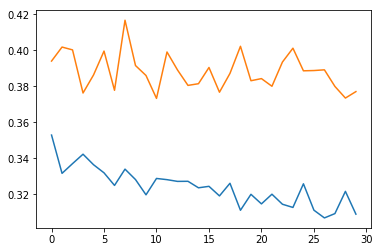

In [32]:
plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

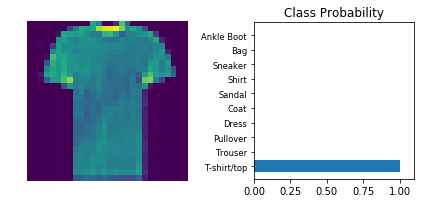

In [34]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.